# День 02 — Машинное обучение

Установим библиотеки, которые не установлены в Google Colab.

In [1]:
# !python.exe -m pip install --upgrade pip

In [2]:
# !pip install shap catboost

Сначала импортируй библиотеки, которые понадобятся нам в работе.

In [3]:
# Это не нужно, т.к. данные берем из каггла

# # пытаемся подключить гугл-диск, если работаем с колаба
# try:
#     from google.colab import drive
#     drive.mount('/content/drive')
# except:
#     pass

In [4]:
import re
import numpy as np
import pandas as pd

import gc
# import shap
import sklearn
import catboost

import seaborn as sns
import matplotlib.pyplot as plt

# Отключение предупреждений
__import__("warnings").filterwarnings("ignore")

sns.set_style("darkgrid") # У графиков будет красивая серая подложка.

In [5]:
from sklearn.metrics import roc_curve, auc

def show_roc_curve(Y_test, Y_proba):
    # Вычисляем значения метрик ROC
    fpr, tpr, thresholds = roc_curve(Y_test, Y_proba)
    roc_auc = auc(fpr, tpr)

    # Строим кривую ROC-AUC
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Диагональная линия случайного угадывания
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Давай загрузим наши данные.

## Загрузка данных

In [6]:
import os
import gc
from glob import glob
from pathlib import Path

# Путь к каталогу с датасетами
path_to_dataset = './datasets'

# Установка библиотеки Kaggle
# !pip install kaggle

if not Path(path_to_dataset).is_dir():
    # Загрузка датасета
    !kaggle datasets download -d saspav/21-school

    # Распаковка загруженного файла
    !unzip 21-school.zip -d datasets

In [7]:
%%time
train = pd.read_csv(os.path.join(path_to_dataset, 'dataset_01_06.csv'))
train = train.set_index("client_id") # Устанавливаем индекс клиента
train = train.drop_duplicates() # Убираем дубликаты

CPU times: total: 16.3 s
Wall time: 16.3 s


In [8]:
train.head(5) # Смотрим первые 5 строк в таблице

,prepay_ind_p1m,latitude_1m,building_type_key_1m,deferred_pay_1m,pay_count_p3m,crm_init_count_d1m,crm_out_count_p3m,prepay_ind_d2m,basic_day_debt_bad_max_d1m,bad_debt_p1m,...,avg_view_genre_dosug_2m,is_multiscreen_p1m,avg_view_other_p1m,count_purchase_1m,avg_view_multi_1m,total_duration_1m,avg_view_adult_1m,avg_view_category_18_d3m,avg_view_tvmarket_p2m,avg_view_category_0_2m
client_id,,,,,,,,,,,,,,,,,,,,,
161291,0.0,51.363170,377945938.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,18.37,1470.87,0.0,0.0,0.00,0.0
87256,0.0,50.547399,377945938.0,NaN,3.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
128419,0.0,51.738616,377945938.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,77.63,10.0,88.69,15110.70,0.0,0.0,0.00,0.0
198395,0.0,50.087963,377945938.0,NaN,3.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
194340,0.0,51.700059,377945938.0,NaN,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,173.79,7342.57,0.0,0.0,4.67,0.0


С помощью метода `.shape` можно вывести размерность датасета.

In [9]:
train.shape

(32092, 3647)

## Утечки данных

В наших данных о клиентах есть признаки, которое могут быть *утечками данных*. Утечка данных может привести к созданию чрезмерно оптимистичных, а то и вовсе бесполезных прогнозных моделей. Утечка данных — это когда для создания модели используется информация, которая не будет доступна на этапе эксплуатации модели. Например, такие признаки с приставками `hgid`, `hflat`.

Для того чтобы получить признаки c приставками `hgid`, воспользуемся кодом ниже:

In [10]:
# Из всех колонок возьмем только колонки, которые начинаются с "hgid":
lick_columns = []
lick_columns.extend([col for col in train.columns if col.startswith('hgid')])

In [11]:
lick_columns

['hgid_hm_1m', 'hgid_1m']

Теперь в переменной `lick_columns` хранятся признаки, которые могут быть утечками в данных. Добавим в этот список признаки с приставкой `hflat`.

In [12]:
lick_columns.extend([col for col in train.columns if col.startswith('hflat')])

In [13]:
lick_columns

['hgid_hm_1m', 'hgid_1m', 'hflat_1m']

## Задание 1

Удали признаки с приставками `charg_inst`, `charg_sale`, `hgid`, `hflat`, `hlid`, а также данные о координатах `latitude_1m` и `longitude_1m`. В удалении признаков тебе поможет метод [.drop()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html).

Выведи размерность получившейся таблицы:

In [14]:
# Отбор колонок для удаления с помощью регулярных выражений
pattern = re.compile(r'^(charg_inst|charg_sale|hgid|hflat|hlid)|latitude|longitude')
columns_to_drop = [col for col in train.columns if pattern.match(col)]
print(f'Будет удалено {len(columns_to_drop)} колонок')

# Удаление отобранных колонок
train.drop(columns=columns_to_drop, inplace=True)

# Вывод размерности получившейся таблицы
train.shape

Будет удалено 60 колонок


(32092, 3587)

## Разделение на признаки и предсказываемую величину

В машинном обучении, когда мы говорим о разделении на признаки и предсказываемую величину, мы имеем в виду следующее:

1. Признаки (features): Это переменные или характеристики, которые используются для прогнозирования. Например, если у нас есть данные о жилье, признаками могут быть количество спален, площадь, район и т. д.

2. Предсказываемая величина (target): Это величина, которую мы пытаемся предсказать с помощью модели машинного обучения. В задачах регрессии это может быть непрерывная величина, такая как цена жилья, вес человека и т. д. В задачах классификации это может быть категория или метка, например, «клиент уйдет» или «клиент останется.

При обучении модели машинного обучения мы используем признаки для предсказания целевой переменной. Таким образом, разделение на признаки и предсказываемую величину является важным этапом в подготовке данных для построения модели.

## Задание 2

Теперь разберемся, что в каждой из задач для нас будет являться признаком (Х), а что предсказываемой переменной (Y).

Раздели датасет `train` на признаки и предсказываемую величину. Признаки сохрани в переменную `X`, предсказываемую величину — в переменную `Y`. Выведи размерность `X` и `Y`:

In [15]:
X = train.drop(columns='label')
Y = train['label']
print(f'Размерность X: {X.shape} Размерность Y: {Y.shape}')

Размерность X: (32092, 3586) Размерность Y: (32092,)


## Разделение признаков на категориальные и численные

Разделение признаков на категориальные и численные важно в контексте подготовки данных для модели машинного обучения по нескольким причинам:

1. Обработка данных: Категориальные признаки представляют собой качественные переменные, которые могут принимать ограниченное количество значений (например, цвет, тип жилья и т. д.), в то время как численные признаки представляют собой количественные переменные (например, возраст, цена, площадь и т. д.). Обработка этих двух типов признаков может потребовать различных методов: категориальные признаки могут потребовать кодирования (например, One-Hot Encoding), в то время как численные признаки могут потребовать масштабирования или нормализации.

2. Выбор модели: Некоторые модели машинного обучения могут требовать явного указания типа признаков. Например, некоторые модели, такие как деревья решений, могут автоматически обрабатывать категориальные признаки, в то время как другие модели, такие как линейная регрессия, могут требовать предварительного преобразования категориальных признаков в численные.

3. Интерпретация результатов: Различные типы признаков могут оказывать разное влияние на модель. Например, при интерпретации коэффициентов в линейной регрессии, численные признаки могут иметь более прямое воздействие на предсказываемую величину, чем категориальные.

Таким образом, разделение признаков на категориальные и численные позволяет более эффективно обрабатывать данные и выбирать подходящие методы анализа и моделирования для конкретной задачи машинного обучения.

## Задание 3

Теперь нам потребуется разделить наши признаки на численные и категориальные. В этом нам поможет функция метод [.select_dtypes()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html). Численные переменные имеют тип `'number'`, а категориальные `'object'`.
Численные переменные сохрани в переменную X_num, категориальные — в переменную X_cat.

Выведи размерность этих таблиц.

In [16]:
# Разделение признаков на численные и категориальные
X_num = X.select_dtypes(include='number')
X_cat = X.select_dtypes(include='object')

# Вывод размерностей численных и категориальных таблиц
print(f'Размерность X_num: {X_num.shape} Размерность X_cat: {X_cat.shape}')

Размерность X_num: (32092, 3578) Размерность X_cat: (32092, 8)


## Задание 4

Некоторые алгоритмы машинного обучения чувствительны к пропускам данных, поэтому нам придется чем-то заполнить отсутствующие данные. Воспользуйся методом [.fillna()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html) для того, чтобы заполнить пропуски в численных признаках значением 0.

Затем выполни этот код `X_num.isna().sum().sum()`:

In [17]:
X_num.fillna(0, inplace=True)
X_num.isna().sum().sum()

0

## One-Hot Encoding

One-Hot Encoding — это процесс преобразования категориальных (номинальных) признаков в числовой формат. Зачем нам важно применять One-Hot Encoding:

1. Совместимость с моделями машинного обучения: Многие алгоритмы машинного обучения требуют, чтобы все данные были числовыми. One-Hot Encoding позволяет преобразовать категориальные данные в форму, которую модели могут использовать для обучения.

2. Избежание неявных порядковых отношений: При использовании One-Hot Encoding мы избегаем создания неявных порядковых отношений между категориями. Кодирование категорий числами (например, 1, 2, 3) может ввести модель в заблуждение, будто некоторые категории имеют порядок или значимость.

3. Предотвращение «расстояний» между категориями: При использовании One-Hot Encoding расстояние между любыми двумя закодированными категориями равно 1. Это помогает избежать неправильных выводов о сходстве или различии между категориями.


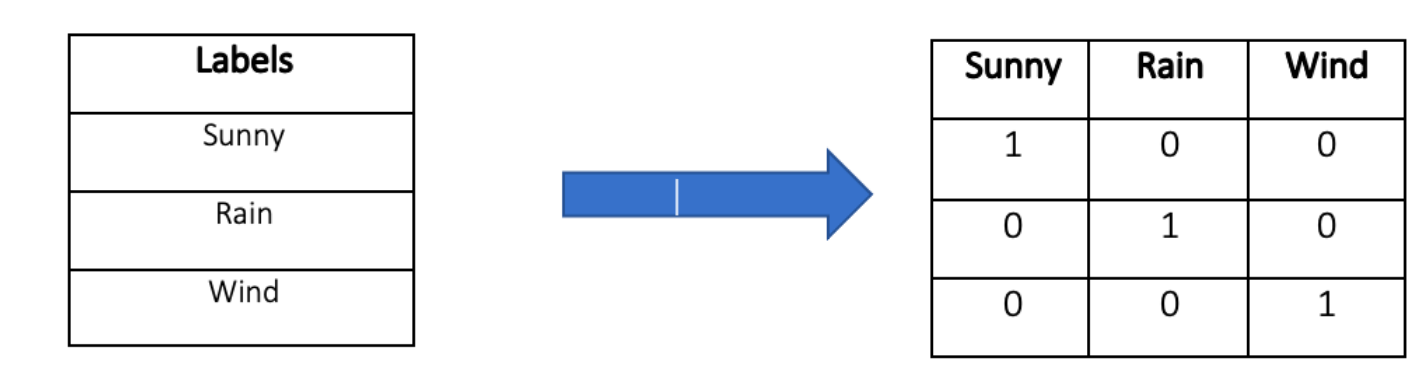

## Задание 5

Примени преобразования **One-Hot Encoding** для категориальных признаков. В этом тебе поможет функция [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

Выведи размерность получившейся таблицы:

In [18]:
# Применение One-Hot Encoding к категориальным признакам
X_cat_encoded = pd.get_dummies(X_cat)

# Вывод размерности получившейся таблицы
print(f'Размерность X_cat: {X_cat_encoded.shape}')

Размерность X_cat: (32092, 24895)


## Задание 6

Теперь уже преобразованные части требуется снова объединить в единый датасет. Соедини переменные `X_num` и `X_cat` в переменную `X`. Воспользуйся методом [.merge()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html).
Объединение проведи по индексам таблицы.

Выведи размерность получившейся таблицы:

*Чтобы объединить численные признаки (X_num) и категориальные признаки, преобразованные с помощью One-Hot Encoding (X_cat_encoded), в единый DataFrame X, лучше воспользоваться методом pd.concat(), а не merge(), так как merge() обычно используется для объединения по ключам, а concat() более подходящий для объединения по индексам и при этом работает быстрее.*

In [19]:
%%time
# Вариант 1
# Объединение численных и закодированных категориальных признаков
X = X_num.merge(X_cat_encoded, left_index=True, right_index=True)
# Вывод размерности получившейся таблицы
print(f'Размерность X: {X.shape}')

Размерность X: (32092, 28473)
CPU times: total: 4.64 s
Wall time: 4.63 s


In [20]:
%%time
# Вариант 2
# Объединение численных и закодированных категориальных признаков
X = pd.concat([X_num, X_cat_encoded], axis=1)

# Вывод размерности получившейся таблицы
print(f'Размерность X: {X.shape}')

Размерность X: (32092, 28473)
CPU times: total: 500 ms
Wall time: 512 ms


## Разделение на Train, Test части

Разделение на тренировочную и тестовую части является важным шагом при обучении моделей машинного обучения. Этот процесс помогает оценить производительность модели на данных, которые она ранее не видела. Обычно данные разделяются в соотношении 70-80% на тренировочную выборку и 20-30% на тестовую выборку.

Разделение на тренировочную и тестовую части помогает избежать переобучения (overfitting) и оценить способность модели к обобщению на новые данные.

## Задание 7

Раздели итоговый датасет на train и test части. В этом тебе поможет функция [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Разделение проведи с параметрами `test_size=0.2`, `random_state=21`.

Выведи размерности переменных `X_train` и `X_test`:

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
# Разделение итогового датасета на train и test части
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=21)

# Вывод размерностей получившихся частей
print(f'Размерность X_train: {X_train.shape}')
print(f'Размерность X_test: {X_test.shape}')
print(f'Размерность Y_train: {Y_train.shape}')
print(f'Размерность Y_test: {Y_test.shape}')

Размерность X_train: (25673, 28473)
Размерность X_test: (6419, 28473)
Размерность Y_train: (25673,)
Размерность Y_test: (6419,)


## Обучение модели

Теперь у нас все готово для обучения!
Мы попробуем обучить модель — градиентный бустинг. Градиентный бустинг — это метод машинного обучения, который используется для построения прогностических моделей, таких как регрессия или классификация. Он основан на идее построения ансамбля слабых моделей, обычно деревьев решений, и объединении их в сильную модель.

Теперь попробуй использовать алгоритм градиентного бустинга для обучения нашей модели предсказания оттока. Для этого воспользуйся алгоритмом `CatBoostRegressor` из библиотеки `catboost`.

In [23]:
from catboost import CatBoostClassifier, MetricVisualizer
from sklearn.metrics import roc_auc_score, accuracy_score

In [24]:
import torch

# # Проверка наличия GPU с помощью PyTorch
# if torch.cuda.is_available():
#     task_type = "GPU"
#     devices = '0'  # Укажите нужные вам GPU (например, '0', '0:1' и т.д.)
#     print("GPU доступен. Использую GPU для обчения!!! :)")
# else:
#     task_type = "CPU"
#     devices = None
#     print("В вашей системе нет GPU :( Обучаюсь на CPU.")
    
task_type = "CPU"
devices = None    

In [25]:
model = CatBoostClassifier(iterations=1000, 
                           eval_metric='AUC', 
                           train_dir="base",
                           task_type=task_type,
                           devices=devices
                          ).fit(X_train, Y_train, verbose=100, eval_set=(X_test, Y_test))

Learning rate set to 0.07064
0:	test: 0.4822824	best: 0.4822824 (0)	total: 295ms	remaining: 4m 54s
100:	test: 0.6540517	best: 0.6547688 (98)	total: 12.9s	remaining: 1m 55s
200:	test: 0.6695957	best: 0.6697262 (198)	total: 25.4s	remaining: 1m 40s
300:	test: 0.6705090	best: 0.6705661 (214)	total: 37.6s	remaining: 1m 27s
400:	test: 0.6712805	best: 0.6715443 (393)	total: 49.8s	remaining: 1m 14s
500:	test: 0.6734626	best: 0.6736611 (460)	total: 1m 1s	remaining: 1m 1s
600:	test: 0.6780993	best: 0.6781476 (564)	total: 1m 14s	remaining: 49.3s
700:	test: 0.6805030	best: 0.6808463 (678)	total: 1m 26s	remaining: 36.9s
800:	test: 0.6820903	best: 0.6822738 (757)	total: 1m 38s	remaining: 24.5s
900:	test: 0.6821005	best: 0.6822759 (818)	total: 1m 50s	remaining: 12.2s
999:	test: 0.6812032	best: 0.6829210 (925)	total: 2m 2s	remaining: 0us

bestTest = 0.68292096
bestIteration = 925

Shrink model to first 926 iterations.


## Задание 8

Рассчитай точность обученной модели. Для этого с помощью метода `.predict(X_test)` сделай предсказание на тестовой выборке `X_test`. Затем передай предсказанные классы и истинные значения оттока в функцию `accuracy_score`.

Не подозрительный ли получился результат? Рассчитай долю клиентов, которые **не уйдут**.

In [26]:
# Предсказание на тестовой выборке
Y_pred = model.predict(X_test)

# Рассчет точности модели
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Проверка доли клиентов, которые не уйдут
no_churn_fraction = (Y_pred == 0).mean()
print(f'Доля клиентов, которые не уйдут: {no_churn_fraction:.4f}')

Accuracy: 0.9634
Доля клиентов, которые не уйдут: 0.9995


In [27]:
# если есть сомнения в no_churn_fraction = (Y_pred == 0).mean() - то вот это дает такой же результат
no_churn_fraction = sum(Y_pred == 0) / len(Y_pred)
print(f'Доля клиентов, которые не уйдут: {no_churn_fraction:.4f}')

Доля клиентов, которые не уйдут: 0.9995


## Дисбаланс классов

При работе с несбалансированными классами использование метрики точности может привести к искаженным результатам оценки производительности модели. При дисбалансе классов модель может быть склонна предсказывать чаще наиболее представленный класс, что приведет к высокой точности для этого класса, но низкой для менее представленного класса. Точность может быть высокой, даже если модель предсказывает только доминирующий класс, игнорируя менее представленный класс. Это может создать ложное впечатление о качестве модели.

Для более информативной оценки модели в случае дисбаланса классов рекомендуется использовать другие метрики, такие как ROC AUC, F1-мера, точность и полнота. Эти метрики учитывают как правильность классификации положительных и отрицательных классов, так и способность модели находить все положительные случаи в данных.

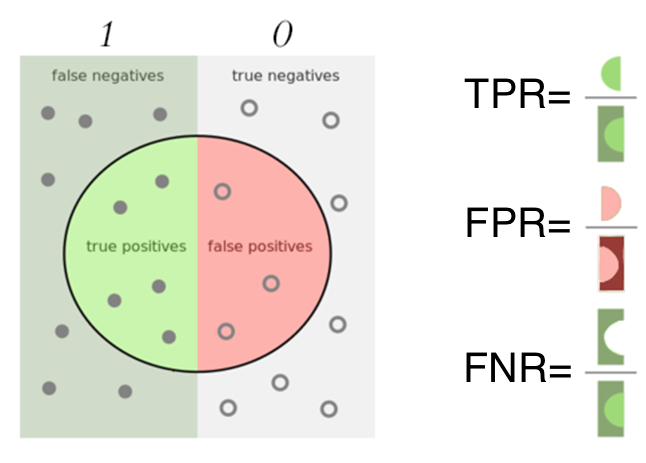

ROC AUC (Receiver Operating Characteristic Area Under the Curve) — это метрика, которая широко используется для оценки качества бинарной классификации моделей машинного обучения. Вот несколько причин, почему использовать ROC AUC полезно:

1. Интерпретируемость: ROC AUC предоставляет понятную интерпретацию качества классификационной модели. Значение ROC AUC находится между 0 и 1, где 1 означает идеальную модель, а 0.5 — модель, которая предсказывает случайно.

2. Устойчивость к дисбалансу классов: ROC AUC не зависит от дисбаланса классов в данных, что делает его хорошей метрикой для несбалансированных наборов данных.

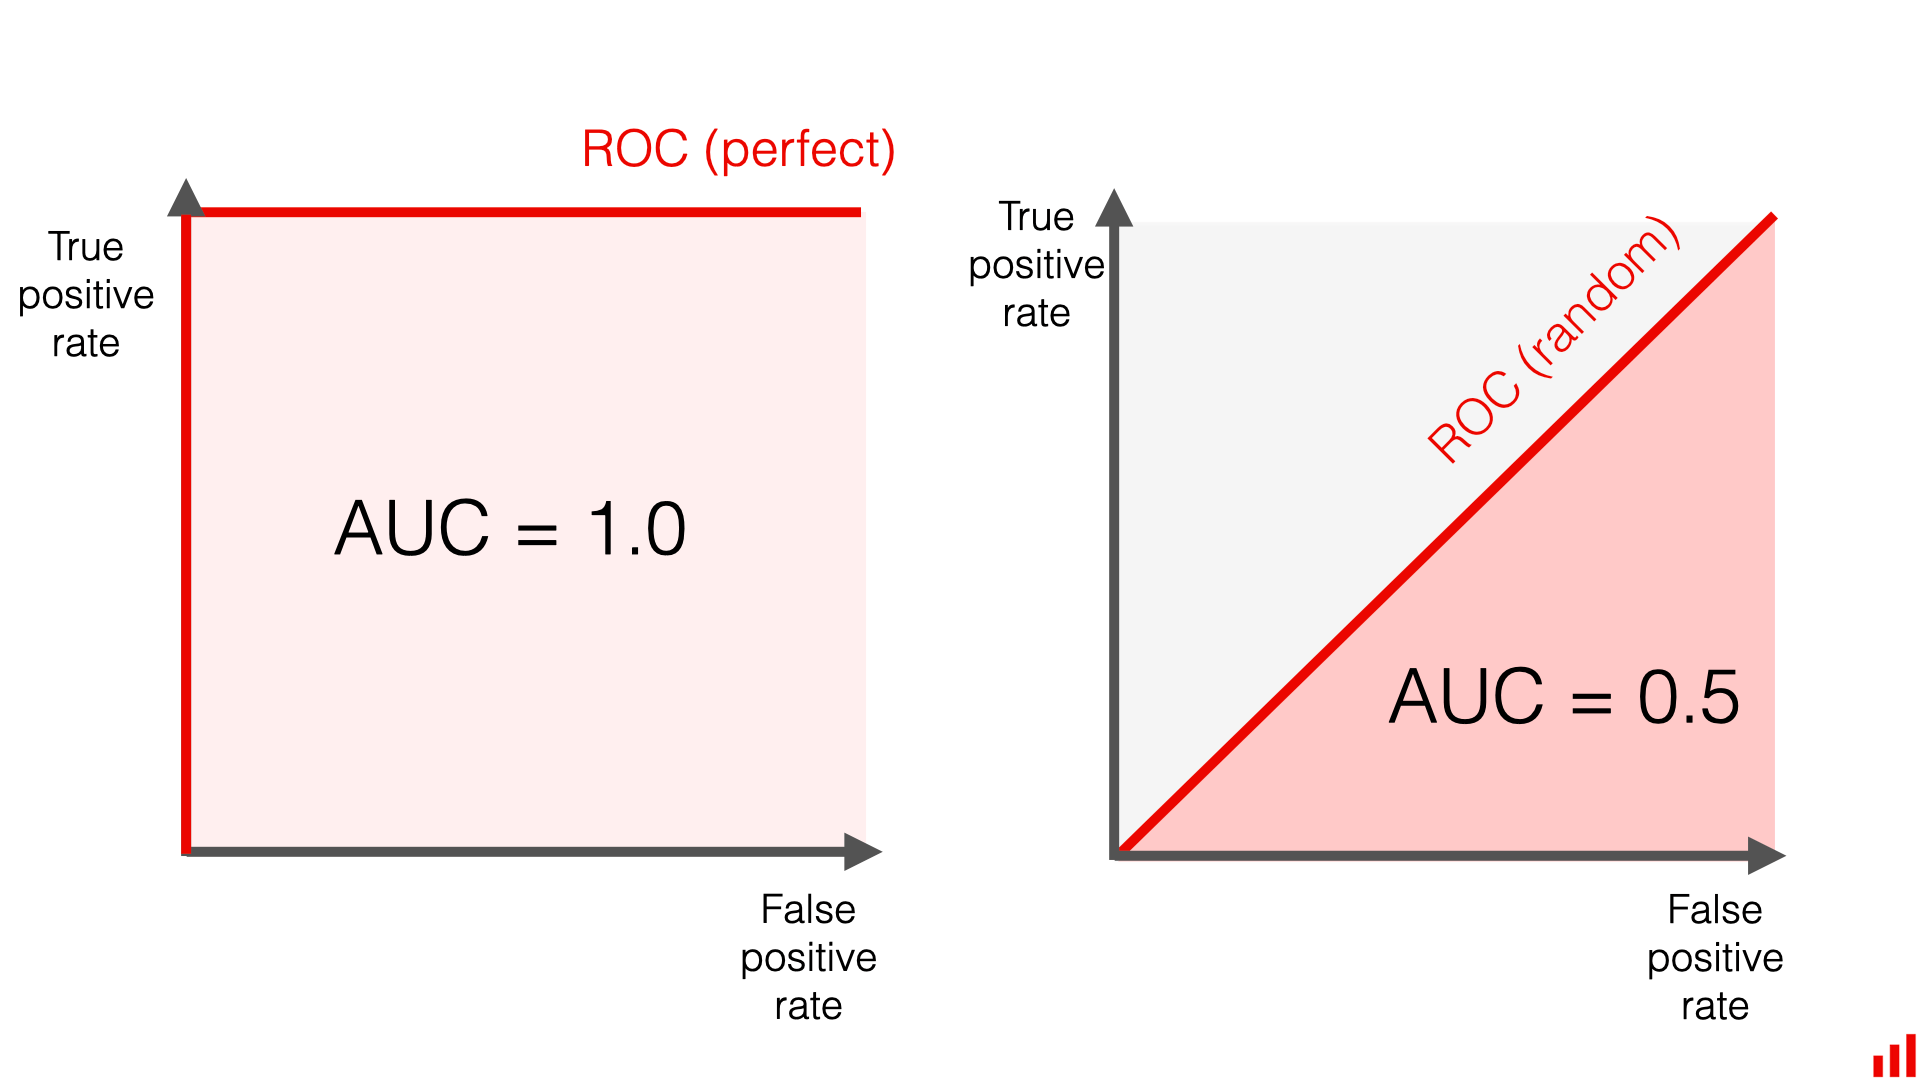

## Задание 9

Рассчитай метрику ROC-AUC. Для этого с помощью метода `.predict_proba(X_test)[:,1]` сделай предсказание на тестовой выборке `X_test`. Затем передай вероятности класса и истинные значения оттока в функцию `roc_auc_score`.

In [28]:
# Предсказание вероятностей на тестовой выборке
Y_proba = model.predict_proba(X_test)[:, 1]

# Рассчет метрики ROC-AUC
roc_auc = roc_auc_score(Y_test, Y_proba)
print(f'ROC-AUC: {roc_auc:.4f}')

ROC-AUC: 0.6829


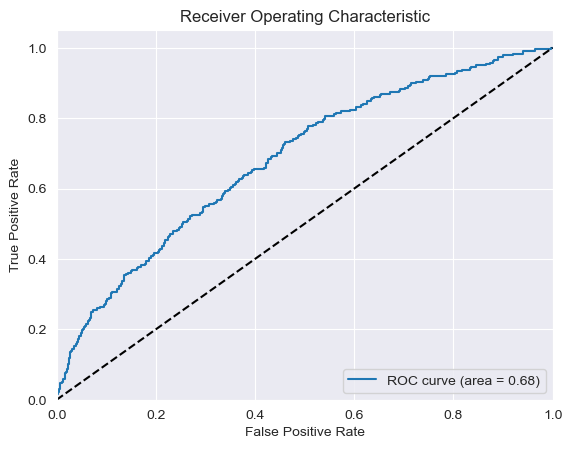

In [29]:
show_roc_curve(Y_test, Y_proba)

## Далее идет вольная программа: Вариант без One-Hot Encoding на всем датасете

In [30]:
%%time
# возьмем оба датасета
dataset_01_06 = pd.read_csv(os.path.join(path_to_dataset, 'dataset_01_06.csv'))
dataset_07_12 = pd.read_csv(os.path.join(path_to_dataset, 'dataset_07_12.csv'))

dataset = pd.concat([dataset_01_06, dataset_07_12], ignore_index=True)

# очистим память от неиспользуемых переменных
dataset_01_06 = dataset_07_12 = None
gc.collect()
dataset.shape

CPU times: total: 15.8 s
Wall time: 15.5 s


(66753, 3648)

In [31]:
# Отбор колонок для удаления с помощью регулярных выражений
pattern = re.compile(r'^(charg_inst|charg_sale|hgid|hflat|hlid)|latitude|longitude')
columns_to_drop = [col for col in dataset.columns if pattern.match(col)]
print(f'Будет удалено {len(columns_to_drop)} колонок')

# Удаление отобранных колонок
dataset.drop(columns=columns_to_drop, inplace=True)
dataset.drop_duplicates("client_id", keep='last', inplace=True)
print('Количество строк: {}, количество столбцов: {}'.format(*dataset.shape))

Будет удалено 60 колонок
Количество строк: 60699, количество столбцов: 3588


In [32]:
# !pip install -U imbalanced-learn

In [33]:
# from imblearn.over_sampling import SMOTE

Процент пропусков, считаемый допустимым, может зависеть от конкретной ситуации и типа данных. Обычно, если процент пропусков составляет менее 5%, его считают незначительным. Если процент пропусков составляет от 5% до 20%, это может потребовать дополнительного анализа и принятия решения по обработке пропущенных значений.

Однако, не существует строгого стандарта или универсального значения для допустимого процента пропусков. Решение о том, какой процент пропусков считать допустимым, зависит от специфики данных и целей анализа.

Также, следует учитывать, что некоторые модели машинного обучения имеют встроенную обработку пропущенных значений, и поэтому процент пропусков может быть менее значимым.

В целом, рекомендуется оценить влияние отсутствия данных на анализ, принять во внимание контекст и конкретную задачу, а также применять подходящие методы обработки пропущенных значений в зависимости от типа данных (например, удаление, заполнение, импутация и т. д.).

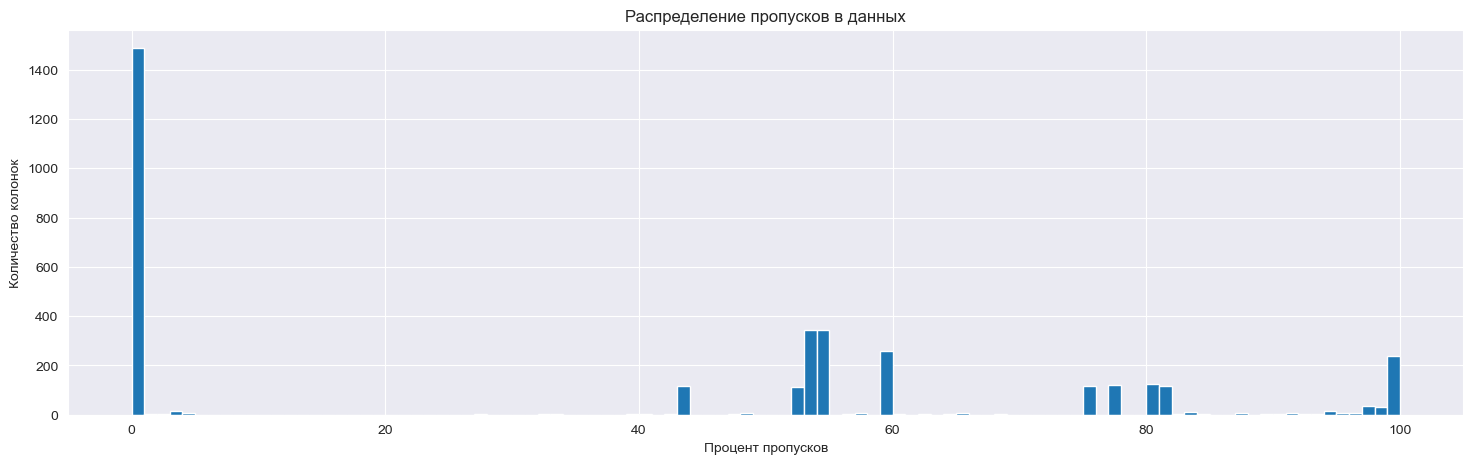

In [34]:
df = dataset
# Вычисляем процент пропусков для каждой колонки
missing_percent = df.isnull().mean() * 100

# Построение гистограммы
plt.figure(figsize=(18, 5))
plt.hist(missing_percent, bins=100)
plt.xlabel('Процент пропусков')
plt.ylabel('Количество колонок')
plt.title('Распределение пропусков в данных')
plt.show()

In [35]:
# Отбираем колонки, где процент пропусков более 20%
selected_columns = missing_percent[missing_percent > 20].index
len(selected_columns)

2078

In [36]:
# Удаляем выбранные колонки из датафрейма
df.drop([col for col in selected_columns if col in df.columns], axis=1, inplace=True)
print('Количество строк: {}, количество столбцов: {}'.format(*df.shape))

Количество строк: 60699, количество столбцов: 1510


In [37]:
# Выбираем категориальные колонки
categorical_columns = df.select_dtypes(include='object').columns.to_list()
# Отбираем колонки, где количество уникальных значений превышает 20% от общего числа значений
selected_columns = [column for column in categorical_columns if df[column].nunique() > 0.2 * len(df)]
# Выводим названия отобранных колонок
print(selected_columns)

['full_address_1m']


### Посмотрим на эти колонки

In [38]:
df[categorical_columns].nunique()

address_name_1m     2302
full_address_1m    37567
subject_name_1m        1
city_name_1m         583
subject_type_1m        1
dtype: int64

In [39]:
df[categorical_columns]

,address_name_1m,full_address_1m,subject_name_1m,city_name_1m,subject_type_1m
1,40 Лет Октября,"397563, Воронежская обл, Воробьевский р-н, Руд...",Воронежская,Рудня,Область
2,Чапаева,"396907, Воронежская обл, Семилукский р-н, Семи...",Воронежская,Семилуки,Область
4,Московский,"394016, Воронежская обл, Воронеж г., Московски...",Воронежская,Воронеж,Область
5,Мира,"397975, Воронежская обл, Лискинский р-н, Песко...",Воронежская,Песковатка,Область
6,Школьная,"397830, Воронежская обл, Острогожский р-н, свх...",Воронежская,свх Победа 1 отделение,Область
...,...,...,...,...,...
66748,Димитрова,"394002, Воронежская обл, Воронеж г., Димитрова...",Воронежская,Воронеж,Область
66749,Крупской,"396900, Воронежская обл, Семилукский р-н, Семи...",Воронежская,Семилуки,Область
66750,Мира,"396160, Воронежская обл, Панинский р-н, Переле...",Воронежская,Перелешинский,Область
66751,Утренняя,"394019, Воронежская обл, Воронеж г., Утренняя ...",Воронежская,Воронеж,Область


#### Из категориальных колонок реальную пользу принесут только нас.пункт и улица, т.к. колонка с одним значением бесполезна, как и полный адрес с множеством значений, уникальных значений более половины строк датасета, т.к. на уникальное значение на 1-2-3 строки.

In [40]:
# Удаляем выбранные колонки из датафрейма
selected_columns = ['full_address_1m', 'subject_name_1m', 'subject_type_1m']
df.drop([col for col in selected_columns if col in df.columns], axis=1, inplace=True)
print('Количество строк: {}, количество столбцов: {}'.format(*df.shape))

Количество строк: 60699, количество столбцов: 1507


In [41]:
# В категориальных колонках нет пропусков
df[df.select_dtypes(include='object').columns].isnull().sum()

address_name_1m    0
city_name_1m       0
dtype: int64

In [42]:
# Колонки с пропусками
df.isnull().sum()[df.isnull().sum() > 0]

building_type_key_1m    1612
bad_debt_p1m            2566
debt_max_period_2m      2025
deff_p2m                2074
data_shpd_p1m            290
bad_debt_2m             2025
bad_debt_p3m            1882
gender_1m               2286
deff_1m                 2550
bad_debt_p2m            2074
debt_max_period_1m      2550
house_area_type_1m       612
deff_3m                 1824
debt_max_period_3m      1824
deff_p1m                2566
deff_2m                 2025
calc_method_id_1m          2
debt_max_period_p3m     1882
lifetime_1m                1
debt_max_period_p2m     2074
quality_code_1m            7
debt_max_period_p1m     2566
data_shpd_p3m            224
data_shpd_p2m            275
deff_p3m                1882
age_1m                  2291
bad_debt_1m             2550
bad_debt_3m             1824
lifetime_tp_shpd_1m      592
lifetime_shpd_1m           3
dtype: int64

In [43]:
# Для пола заполним пропуски нулем и преобразуем в строковый тип
df['gender_1m'] = df['gender_1m'].fillna(0).astype(int).astype(str)

In [44]:
df['gender_1m'].value_counts()

2    30924
1    27447
0     2328
Name: gender_1m, dtype: int64

In [45]:
# Вычисляем медиану для каждой колонки
median_values = df.median()
# Заполняем пропуски медианой
df.fillna(median_values, inplace=True)

In [46]:
df.isnull().sum().sum()

0

In [47]:
cat_features = df.select_dtypes(include='object').columns.to_list()
cat_features

['address_name_1m', 'gender_1m', 'city_name_1m']

In [48]:
%%time
X = df.drop(columns='label')
Y = df['label']

# Разделение итогового датасета на train и test части
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=21, stratify=Y)

# # Балансировка классов с использованием SMOTE
# smote = SMOTE(random_state=21)
# X_train, Y_train = smote.fit_resample(X_train, Y_train)

# Вывод размерностей получившихся частей
print(f'Размерность X_train: {X_train.shape}')
print(f'Размерность X_test: {X_test.shape}')
print(f'Размерность Y_train: {Y_train.shape}')
print(f'Размерность Y_test: {Y_test.shape}')

Размерность X_train: (42489, 1506)
Размерность X_test: (18210, 1506)
Размерность Y_train: (42489,)
Размерность Y_test: (18210,)
CPU times: total: 469 ms
Wall time: 471 ms


In [49]:
model2 = CatBoostClassifier(
    iterations=1000,
    eval_metric='AUC',
    train_dir="base",
    task_type=task_type,
    devices=devices,
    cat_features=cat_features
).fit(
    X_train,
    Y_train,
    verbose=100,
    early_stopping_rounds=80,
    eval_set=(X_test, Y_test),
)

# Предсказание вероятностей на тестовой выборке
Y_proba = model2.predict_proba(X_test)[:, 1]

# Рассчет метрики ROC-AUC
roc_auc = roc_auc_score(Y_test, Y_proba)
print(f'ROC-AUC: {roc_auc:.4f}')  # ROC-AUC: 0.6919

Learning rate set to 0.051775


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4971528	best: 0.4971528 (0)	total: 51.8ms	remaining: 51.7s
100:	test: 0.6828715	best: 0.6832320 (96)	total: 5.95s	remaining: 53s
200:	test: 0.6908876	best: 0.6913479 (192)	total: 11.8s	remaining: 47s
bestTest = 0.6918996871
bestIteration = 203
Shrink model to first 204 iterations.
ROC-AUC: 0.6919


### После удаления колонок с пропусками результат стал чуть лучше (был ROC-AUC: 0.6842)

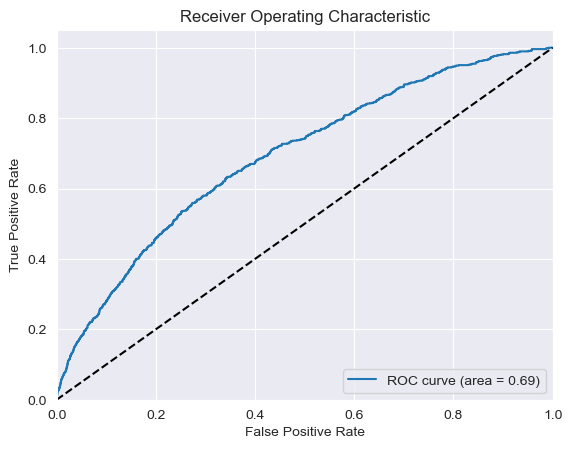

In [50]:
show_roc_curve(Y_test, Y_proba)

In [51]:
SEED = 20240713

In [52]:
# Опыты...

model3 = CatBoostClassifier(
    iterations=2000,
#     learning_rate=0.03,
#     auto_class_weights='Balanced',
#     loss_function='Logloss',
#     loss_function='CrossEntropy',
#     random_seed=SEED,
    eval_metric='AUC',
    train_dir="base",
    task_type=task_type,
    devices=devices,
    cat_features=cat_features,
).fit(
    X_train,
    Y_train,
    verbose=100,
    early_stopping_rounds=80,
    eval_set=(X_test, Y_test),
)

# Предсказание вероятностей на тестовой выборке
Y_proba = model3.predict_proba(X_test)[:, 1]

# Рассчет метрики ROC-AUC
roc_auc = roc_auc_score(Y_test, Y_proba)
print(f'ROC-AUC: {roc_auc:.4f}')

Learning rate set to 0.038859


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4971528	best: 0.4971528 (0)	total: 50.9ms	remaining: 1m 41s
100:	test: 0.6830674	best: 0.6830674 (100)	total: 5.91s	remaining: 1m 51s
200:	test: 0.6882167	best: 0.6882167 (200)	total: 11.7s	remaining: 1m 45s
300:	test: 0.6918750	best: 0.6918750 (300)	total: 17.5s	remaining: 1m 38s
400:	test: 0.6928759	best: 0.6929938 (393)	total: 23s	remaining: 1m 31s
500:	test: 0.6941192	best: 0.6941795 (499)	total: 28.7s	remaining: 1m 25s
600:	test: 0.6946151	best: 0.6947131 (581)	total: 34.6s	remaining: 1m 20s
700:	test: 0.6948092	best: 0.6951720 (660)	total: 40.5s	remaining: 1m 15s
800:	test: 0.6945214	best: 0.6958592 (740)	total: 46.4s	remaining: 1m 9s
bestTest = 0.695859164
bestIteration = 740
Shrink model to first 741 iterations.
ROC-AUC: 0.6959


In [143]:
# ROC-AUC: 0.0.6959 - iterations=2000

In [144]:
stop

NameError: name 'stop' is not defined

In [201]:
import optuna
from optuna.integration import CatBoostPruningCallback

from catboost import CatBoostClassifier, Pool

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report


def objective(trial: optuna.Trial) -> float:
    param = {
#         "loss_function": trial.suggest_categorical("loss_function", ['Logloss', 'CrossEntropy']),
#         "auto_class_weights": trial.suggest_categorical("auto_class_weights", [None, "Balanced"]),
        "iterations": trial.suggest_int("iterations", 500, 3000, step=100),
#         "depth": trial.suggest_int("depth", 1, 12),
#         "learning_rate": trial.suggest_float("learning_rate", 0.04, 0.06, step=0.001),
    }

    clf = CatBoostClassifier(cat_features=cat_features,
                             eval_metric='AUC',
                             train_dir="base",
                             early_stopping_rounds=80,
#                              random_seed=SEED,
                             task_type=task_type,
                             devices=devices,                             
                             **param)

    clf.fit(X_train, Y_train,
            eval_set=[(X_test, Y_test)],
            verbose=100,
            early_stopping_rounds=80)

    roc_auc = roc_auc_score(Y_test, clf.predict(X_test))

    return roc_auc

In [202]:
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
)
study.optimize(objective, n_trials=120, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_params = trial.params

[I 2024-07-12 16:52:40,235] A new study created in memory with name: no-name-3401c57a-c3d7-40df-8692-5fcdb6fdac39


Learning rate set to 0.03486


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 54.5ms	remaining: 2m 21s
100:	test: 0.6740567	best: 0.6747120 (94)	total: 5.92s	remaining: 2m 26s
200:	test: 0.6823274	best: 0.6823445 (199)	total: 11.8s	remaining: 2m 20s
300:	test: 0.6857532	best: 0.6858443 (296)	total: 17.5s	remaining: 2m 13s
400:	test: 0.6871719	best: 0.6874456 (393)	total: 23.2s	remaining: 2m 7s
500:	test: 0.6882660	best: 0.6882660 (500)	total: 28.9s	remaining: 2m 1s
600:	test: 0.6886754	best: 0.6889064 (571)	total: 34.6s	remaining: 1m 55s


[I 2024-07-12 16:53:19,163] Trial 0 finished with value: 0.5017212405278835 and parameters: {'iterations': 2600}. Best is trial 0 with value: 0.5017212405278835.


bestTest = 0.6889063716
bestIteration = 571
Shrink model to first 572 iterations.
Learning rate set to 0.036675


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 55.4ms	remaining: 2m 7s
100:	test: 0.6716744	best: 0.6719933 (94)	total: 5.65s	remaining: 2m 3s
200:	test: 0.6819148	best: 0.6819148 (200)	total: 11.6s	remaining: 2m 1s
300:	test: 0.6867969	best: 0.6870640 (292)	total: 17.5s	remaining: 1m 56s
400:	test: 0.6885447	best: 0.6889786 (380)	total: 23.3s	remaining: 1m 50s
500:	test: 0.6891721	best: 0.6895827 (441)	total: 29.1s	remaining: 1m 44s
600:	test: 0.6897762	best: 0.6898148 (522)	total: 35s	remaining: 1m 38s
bestTest = 0.6898498833
bestIteration = 602
Shrink model to first 603 iterations.


[I 2024-07-12 16:54:00,143] Trial 1 finished with value: 0.5017785766898007 and parameters: {'iterations': 2300}. Best is trial 1 with value: 0.5017785766898007.


Learning rate set to 0.036034


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 56.4ms	remaining: 2m 15s
100:	test: 0.6712677	best: 0.6718543 (94)	total: 5.86s	remaining: 2m 13s
200:	test: 0.6816200	best: 0.6816200 (200)	total: 11.7s	remaining: 2m 7s
300:	test: 0.6846722	best: 0.6850084 (291)	total: 17.5s	remaining: 2m 2s
400:	test: 0.6853762	best: 0.6855907 (381)	total: 23.4s	remaining: 1m 56s
500:	test: 0.6869936	best: 0.6869936 (500)	total: 29.2s	remaining: 1m 50s
600:	test: 0.6877259	best: 0.6879860 (595)	total: 35.1s	remaining: 1m 45s
bestTest = 0.6879859865
bestIteration = 595
Shrink model to first 596 iterations.


[I 2024-07-12 16:54:40,828] Trial 2 finished with value: 0.5017785766898007 and parameters: {'iterations': 2400}. Best is trial 1 with value: 0.5017785766898007.


Learning rate set to 0.063969


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 56.5ms	remaining: 33.8s
100:	test: 0.6787103	best: 0.6787103 (100)	total: 5.85s	remaining: 28.9s
200:	test: 0.6865453	best: 0.6867852 (191)	total: 11.6s	remaining: 23.1s
300:	test: 0.6868410	best: 0.6884321 (279)	total: 17.5s	remaining: 17.4s


[I 2024-07-12 16:55:02,800] Trial 3 finished with value: 0.5043793569238709 and parameters: {'iterations': 600}. Best is trial 3 with value: 0.5043793569238709.


bestTest = 0.6884321272
bestIteration = 279
Shrink model to first 280 iterations.
Learning rate set to 0.033806


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 54.5ms	remaining: 2m 32s
100:	test: 0.6702901	best: 0.6702901 (100)	total: 5.74s	remaining: 2m 33s
200:	test: 0.6797438	best: 0.6797438 (200)	total: 11.5s	remaining: 2m 29s
300:	test: 0.6841142	best: 0.6841323 (273)	total: 17.2s	remaining: 2m 22s
400:	test: 0.6851784	best: 0.6856655 (341)	total: 22.9s	remaining: 2m 16s


[I 2024-07-12 16:55:32,594] Trial 4 finished with value: 0.5024287717483182 and parameters: {'iterations': 2800}. Best is trial 3 with value: 0.5043793569238709.


500:	test: 0.6853513	best: 0.6857602 (420)	total: 28.5s	remaining: 2m 10s
bestTest = 0.6857602
bestIteration = 420
Shrink model to first 421 iterations.
Learning rate set to 0.036034


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 56.4ms	remaining: 2m 15s
100:	test: 0.6712677	best: 0.6718543 (94)	total: 5.67s	remaining: 2m 8s
200:	test: 0.6816202	best: 0.6816202 (200)	total: 11.3s	remaining: 2m 4s
300:	test: 0.6846510	best: 0.6846684 (298)	total: 17s	remaining: 1m 58s


[I 2024-07-12 16:55:56,347] Trial 5 finished with value: 0.5031076348877945 and parameters: {'iterations': 2400}. Best is trial 3 with value: 0.5043793569238709.


bestTest = 0.6849094629
bestIteration = 319
Shrink model to first 320 iterations.
Learning rate set to 0.048011


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 54.4ms	remaining: 1m 5s
100:	test: 0.6732768	best: 0.6754879 (81)	total: 5.64s	remaining: 1m 1s
200:	test: 0.6819987	best: 0.6821464 (182)	total: 11.4s	remaining: 56.5s
300:	test: 0.6857086	best: 0.6858883 (296)	total: 17.1s	remaining: 51.1s
400:	test: 0.6858816	best: 0.6866306 (383)	total: 22.8s	remaining: 45.3s


[I 2024-07-12 16:56:23,818] Trial 6 finished with value: 0.5029929625639598 and parameters: {'iterations': 1200}. Best is trial 3 with value: 0.5043793569238709.


bestTest = 0.6866306365
bestIteration = 383
Shrink model to first 384 iterations.
Learning rate set to 0.038859


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 53.3ms	remaining: 1m 46s
100:	test: 0.6748267	best: 0.6750084 (94)	total: 5.65s	remaining: 1m 46s
200:	test: 0.6862217	best: 0.6862217 (200)	total: 11.5s	remaining: 1m 42s
300:	test: 0.6885451	best: 0.6887526 (298)	total: 17.3s	remaining: 1m 37s


[I 2024-07-12 16:56:46,824] Trial 7 finished with value: 0.5029929625639598 and parameters: {'iterations': 2000}. Best is trial 3 with value: 0.5043793569238709.


bestTest = 0.6887526214
bestIteration = 298
Shrink model to first 299 iterations.
Learning rate set to 0.03486


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 56.7ms	remaining: 2m 27s
100:	test: 0.6740567	best: 0.6747120 (94)	total: 5.93s	remaining: 2m 26s
200:	test: 0.6823274	best: 0.6823445 (199)	total: 11.9s	remaining: 2m 21s
300:	test: 0.6857532	best: 0.6858443 (296)	total: 17.7s	remaining: 2m 15s
400:	test: 0.6871719	best: 0.6874456 (393)	total: 23.5s	remaining: 2m 9s
500:	test: 0.6882660	best: 0.6882660 (500)	total: 29.4s	remaining: 2m 3s
600:	test: 0.6886754	best: 0.6889064 (571)	total: 35.3s	remaining: 1m 57s


[I 2024-07-12 16:57:26,258] Trial 8 finished with value: 0.5017212405278835 and parameters: {'iterations': 2600}. Best is trial 3 with value: 0.5043793569238709.


bestTest = 0.6889063716
bestIteration = 571
Shrink model to first 572 iterations.
Learning rate set to 0.039693


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 55.5ms	remaining: 1m 45s
100:	test: 0.6751471	best: 0.6751471 (100)	total: 5.83s	remaining: 1m 43s
200:	test: 0.6849072	best: 0.6849072 (200)	total: 11.7s	remaining: 1m 38s
300:	test: 0.6866172	best: 0.6868700 (296)	total: 17.5s	remaining: 1m 32s
400:	test: 0.6873078	best: 0.6885313 (380)	total: 23.3s	remaining: 1m 27s
500:	test: 0.6874633	best: 0.6887113 (435)	total: 29.1s	remaining: 1m 21s


[I 2024-07-12 16:57:57,434] Trial 9 finished with value: 0.5043220207619536 and parameters: {'iterations': 1900}. Best is trial 3 with value: 0.5043793569238709.


bestTest = 0.6887113452
bestIteration = 435
Shrink model to first 436 iterations.
Learning rate set to 0.063969


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 54.5ms	remaining: 32.6s
100:	test: 0.6787103	best: 0.6787103 (100)	total: 5.85s	remaining: 28.9s
200:	test: 0.6865453	best: 0.6867852 (191)	total: 11.7s	remaining: 23.2s
300:	test: 0.6868410	best: 0.6884321 (279)	total: 17.5s	remaining: 17.3s


[I 2024-07-12 16:58:19,550] Trial 10 finished with value: 0.5043793569238709 and parameters: {'iterations': 600}. Best is trial 3 with value: 0.5043793569238709.


bestTest = 0.6884321272
bestIteration = 279
Shrink model to first 280 iterations.
Learning rate set to 0.063969


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 55.9ms	remaining: 33.5s
100:	test: 0.6787103	best: 0.6787103 (100)	total: 5.73s	remaining: 28.3s
200:	test: 0.6865447	best: 0.6867847 (188)	total: 11.4s	remaining: 22.6s
300:	test: 0.6871976	best: 0.6882565 (289)	total: 17.1s	remaining: 17s


[I 2024-07-12 16:58:41,750] Trial 11 finished with value: 0.5043793569238709 and parameters: {'iterations': 600}. Best is trial 3 with value: 0.5043793569238709.


bestTest = 0.6882564723
bestIteration = 289
Shrink model to first 290 iterations.
Learning rate set to 0.068984


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 53.5ms	remaining: 26.7s
100:	test: 0.6792789	best: 0.6798965 (98)	total: 5.71s	remaining: 22.6s
200:	test: 0.6859788	best: 0.6863500 (167)	total: 11.5s	remaining: 17.1s
300:	test: 0.6877038	best: 0.6892033 (254)	total: 17.3s	remaining: 11.5s


[I 2024-07-12 16:59:02,284] Trial 12 finished with value: 0.5030216306449184 and parameters: {'iterations': 500}. Best is trial 3 with value: 0.5043793569238709.


bestTest = 0.6892032921
bestIteration = 254
Shrink model to first 255 iterations.
Learning rate set to 0.049772


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 56.9ms	remaining: 1m 2s
100:	test: 0.6756279	best: 0.6767743 (66)	total: 5.79s	remaining: 57.3s
200:	test: 0.6849318	best: 0.6851656 (187)	total: 11.6s	remaining: 52.1s
300:	test: 0.6865296	best: 0.6872064 (262)	total: 17.6s	remaining: 46.6s


[I 2024-07-12 16:59:23,438] Trial 13 finished with value: 0.501749908608842 and parameters: {'iterations': 1100}. Best is trial 3 with value: 0.5043793569238709.


bestTest = 0.6872064471
bestIteration = 262
Shrink model to first 263 iterations.
Learning rate set to 0.051775


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 55.3ms	remaining: 55.2s
100:	test: 0.6739335	best: 0.6739335 (100)	total: 5.83s	remaining: 51.9s
200:	test: 0.6811032	best: 0.6812040 (179)	total: 11.8s	remaining: 46.8s
300:	test: 0.6830626	best: 0.6849534 (267)	total: 17.6s	remaining: 40.9s


[I 2024-07-12 16:59:44,909] Trial 14 finished with value: 0.5011570497122418 and parameters: {'iterations': 1000}. Best is trial 3 with value: 0.5043793569238709.


bestTest = 0.6849533617
bestIteration = 267
Shrink model to first 268 iterations.
Learning rate set to 0.045043


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 57.7ms	remaining: 1m 20s
100:	test: 0.6725152	best: 0.6736622 (83)	total: 5.82s	remaining: 1m 14s
200:	test: 0.6835974	best: 0.6835974 (200)	total: 11.7s	remaining: 1m 9s
300:	test: 0.6866093	best: 0.6871106 (272)	total: 17.5s	remaining: 1m 3s


[I 2024-07-12 17:00:06,518] Trial 15 finished with value: 0.5030502987258771 and parameters: {'iterations': 1400}. Best is trial 3 with value: 0.5043793569238709.


bestTest = 0.6871105731
bestIteration = 272
Shrink model to first 273 iterations.
Learning rate set to 0.060014


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 57.9ms	remaining: 40.4s
100:	test: 0.6762115	best: 0.6762115 (100)	total: 5.93s	remaining: 35.2s
200:	test: 0.6854480	best: 0.6856056 (196)	total: 11.8s	remaining: 29.4s
300:	test: 0.6877824	best: 0.6883259 (266)	total: 17.9s	remaining: 23.7s


[I 2024-07-12 17:00:28,292] Trial 16 finished with value: 0.5023427675054423 and parameters: {'iterations': 700}. Best is trial 3 with value: 0.5043793569238709.


bestTest = 0.6883259416
bestIteration = 266
Shrink model to first 267 iterations.
Learning rate set to 0.043774


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 61.9ms	remaining: 1m 32s
100:	test: 0.6715037	best: 0.6734553 (86)	total: 6.05s	remaining: 1m 23s
200:	test: 0.6811129	best: 0.6811129 (200)	total: 12.2s	remaining: 1m 18s
300:	test: 0.6854400	best: 0.6854400 (300)	total: 18.2s	remaining: 1m 12s
400:	test: 0.6859198	best: 0.6864846 (381)	total: 24.2s	remaining: 1m 6s


[I 2024-07-12 17:00:57,341] Trial 17 finished with value: 0.5023714355864008 and parameters: {'iterations': 1500}. Best is trial 3 with value: 0.5043793569238709.


bestTest = 0.6864846051
bestIteration = 381
Shrink model to first 382 iterations.
Learning rate set to 0.054084


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 56.1ms	remaining: 50.4s
100:	test: 0.6735114	best: 0.6735114 (100)	total: 6.04s	remaining: 47.8s
200:	test: 0.6843166	best: 0.6845998 (187)	total: 12.1s	remaining: 42.1s
300:	test: 0.6857359	best: 0.6863181 (259)	total: 18.2s	remaining: 36.2s
400:	test: 0.6858827	best: 0.6869628 (329)	total: 24.3s	remaining: 30.2s


[I 2024-07-12 17:01:23,386] Trial 18 finished with value: 0.501749908608842 and parameters: {'iterations': 900}. Best is trial 3 with value: 0.5043793569238709.


bestTest = 0.6869628131
bestIteration = 329
Shrink model to first 330 iterations.
Learning rate set to 0.056786


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 58.8ms	remaining: 47s
100:	test: 0.6740683	best: 0.6744176 (51)	total: 6.07s	remaining: 42s
200:	test: 0.6873606	best: 0.6873620 (199)	total: 12s	remaining: 35.7s


[I 2024-07-12 17:01:41,793] Trial 19 finished with value: 0.5024001036673595 and parameters: {'iterations': 800}. Best is trial 3 with value: 0.5043793569238709.


bestTest = 0.6880185306
bestIteration = 211
Shrink model to first 212 iterations.
Learning rate set to 0.04262


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 57ms	remaining: 1m 31s
100:	test: 0.6680696	best: 0.6700247 (83)	total: 6.1s	remaining: 1m 30s
200:	test: 0.6805459	best: 0.6805819 (176)	total: 12.2s	remaining: 1m 25s
300:	test: 0.6845936	best: 0.6849495 (296)	total: 18.3s	remaining: 1m 18s
400:	test: 0.6853936	best: 0.6853936 (400)	total: 24.4s	remaining: 1m 12s
500:	test: 0.6854356	best: 0.6862811 (430)	total: 30.5s	remaining: 1m 6s


[I 2024-07-12 17:02:14,110] Trial 20 finished with value: 0.5024287717483182 and parameters: {'iterations': 1600}. Best is trial 3 with value: 0.5043793569238709.


bestTest = 0.6862811148
bestIteration = 430
Shrink model to first 431 iterations.
Learning rate set to 0.068984


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 55.5ms	remaining: 27.7s
100:	test: 0.6792789	best: 0.6798965 (98)	total: 5.82s	remaining: 23s
200:	test: 0.6859788	best: 0.6863500 (167)	total: 11.7s	remaining: 17.4s
300:	test: 0.6877038	best: 0.6892033 (254)	total: 17.8s	remaining: 11.7s


[I 2024-07-12 17:02:35,072] Trial 21 finished with value: 0.5030216306449184 and parameters: {'iterations': 500}. Best is trial 3 with value: 0.5043793569238709.


bestTest = 0.6892032921
bestIteration = 254
Shrink model to first 255 iterations.
Learning rate set to 0.060014


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5274599	best: 0.5274599 (0)	total: 57.5ms	remaining: 40.2s
100:	test: 0.6762115	best: 0.6762115 (100)	total: 6.05s	remaining: 35.9s
200:	test: 0.6854480	best: 0.6856056 (196)	total: 12.2s	remaining: 30.2s
300:	test: 0.6877824	best: 0.6883259 (266)	total: 18.3s	remaining: 24.3s


[I 2024-07-12 17:02:57,340] Trial 22 finished with value: 0.5023427675054423 and parameters: {'iterations': 700}. Best is trial 3 with value: 0.5043793569238709.


bestTest = 0.6883259416
bestIteration = 266
Shrink model to first 267 iterations.
Number of finished trials: 23
Best trial:
  Value: 0.5043793569238709
  Params: 
    iterations: 600


In [203]:
best_params

{'iterations': 600}

In [204]:
clf = CatBoostClassifier(cat_features=cat_features,
                         eval_metric='AUC',
                         train_dir="base",
                         early_stopping_rounds=80,
                         random_seed=SEED,
#                          task_type=task_type,
#                          devices=devices,                             
                         **best_params)

clf.fit(X_train, Y_train,
        eval_set=[(X_test, Y_test)],
        verbose=100,
        early_stopping_rounds=80,
        )
# Предсказание вероятностей на тестовой выборке
Y_proba = clf.predict_proba(X_test)[:, 1]

# Рассчет метрики ROC-AUC
roc_auc = roc_auc_score(Y_test, Y_proba)
print(f'ROC-AUC: {roc_auc:.4f}')

Learning rate set to 0.099907
0:	test: 0.5047920	best: 0.5047920 (0)	total: 60.5ms	remaining: 36.2s
100:	test: 0.6766880	best: 0.6772351 (69)	total: 6.09s	remaining: 30.1s
200:	test: 0.6775306	best: 0.6801100 (147)	total: 12.1s	remaining: 24.1s
300:	test: 0.6816620	best: 0.6821614 (298)	total: 18.1s	remaining: 18s
Stopped by overfitting detector  (80 iterations wait)

bestTest = 0.6821614227
bestIteration = 298

Shrink model to first 299 iterations.
ROC-AUC: 0.6822


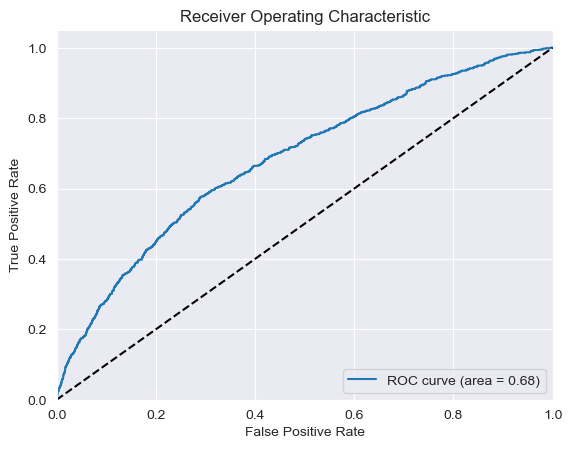

In [205]:
show_roc_curve(Y_test, Y_proba)

In [206]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ParameterGrid

# Определение параметров для поиска по сетке
param_grid = {
    "iterations": [500, 1000, 1500, 2000, 2500, 3000],
    "depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "border_count": [32, 64, 128],
}

# Подготовка данных (пример)
# X_train, X_test, Y_train, Y_test - ваши данные
# cat_features - категориальные признаки

# Объединение данных в пул
train_pool = Pool(X_train, Y_train, cat_features=cat_features)
eval_pool = Pool(X_test, Y_test, cat_features=cat_features)

best_score = 0
best_params = {}

# Перебор всех комбинаций параметров
for params in ParameterGrid(param_grid):
    clf = CatBoostClassifier(
        cat_features=cat_features,
        eval_metric='AUC',
        train_dir="base",
        early_stopping_rounds=80,
        task_type=task_type,
        devices=devices,
        **params
    )
    
    clf.fit(
        train_pool,
        eval_set=eval_pool,
        verbose=100,
        early_stopping_rounds=80
    )
    
    roc_auc = roc_auc_score(Y_test, clf.predict_proba(X_test)[:, 1])
    
    if roc_auc > best_score:
        best_score = roc_auc
        best_params = params

print("Best AUC: ", best_score)
print("Best Params: ", best_params)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 25.1ms	remaining: 12.5s
100:	test: 0.6492525	best: 0.6503350 (91)	total: 2.64s	remaining: 10.4s
200:	test: 0.6711235	best: 0.6711843 (199)	total: 5.35s	remaining: 7.96s
300:	test: 0.6762710	best: 0.6762710 (300)	total: 8.03s	remaining: 5.31s
400:	test: 0.6773821	best: 0.6774374 (393)	total: 10.7s	remaining: 2.64s
499:	test: 0.6793701	best: 0.6793838 (498)	total: 13.3s	remaining: 0us
bestTest = 0.6793838143
bestIteration = 498
Shrink model to first 499 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 25ms	remaining: 12.5s
100:	test: 0.6702237	best: 0.6705583 (99)	total: 2.66s	remaining: 10.5s
200:	test: 0.6759773	best: 0.6759773 (200)	total: 5.37s	remaining: 7.99s
300:	test: 0.6803105	best: 0.6804742 (293)	total: 8.18s	remaining: 5.41s
400:	test: 0.6829726	best: 0.6831819 (394)	total: 10.9s	remaining: 2.68s
499:	test: 0.6834363	best: 0.6837795 (484)	total: 13.5s	remaining: 0us
bestTest = 0.6837794781
bestIteration = 484
Shrink model to first 485 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 27ms	remaining: 13.5s
100:	test: 0.6771752	best: 0.6771752 (100)	total: 2.71s	remaining: 10.7s
200:	test: 0.6815974	best: 0.6815974 (200)	total: 5.41s	remaining: 8.05s
300:	test: 0.6852677	best: 0.6853830 (293)	total: 8.2s	remaining: 5.42s
400:	test: 0.6856081	best: 0.6857827 (371)	total: 10.9s	remaining: 2.69s
499:	test: 0.6851408	best: 0.6860488 (473)	total: 13.5s	remaining: 0us
bestTest = 0.6860488355
bestIteration = 473
Shrink model to first 474 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 28.9ms	remaining: 14.4s
100:	test: 0.6810890	best: 0.6813509 (98)	total: 2.67s	remaining: 10.5s
200:	test: 0.6830139	best: 0.6831466 (197)	total: 5.34s	remaining: 7.95s
300:	test: 0.6847503	best: 0.6852261 (292)	total: 8.08s	remaining: 5.34s
400:	test: 0.6857251	best: 0.6860683 (392)	total: 10.8s	remaining: 2.66s
499:	test: 0.6849303	best: 0.6864044 (447)	total: 13.4s	remaining: 0us
bestTest = 0.686404407
bestIteration = 447
Shrink model to first 448 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 25.9ms	remaining: 12.9s
100:	test: 0.6798923	best: 0.6800299 (97)	total: 2.68s	remaining: 10.6s
200:	test: 0.6849536	best: 0.6849536 (200)	total: 5.36s	remaining: 7.97s
300:	test: 0.6861083	best: 0.6870912 (283)	total: 8.11s	remaining: 5.36s
400:	test: 0.6866882	best: 0.6872965 (335)	total: 10.8s	remaining: 2.67s
bestTest = 0.6872964799
bestIteration = 335
Shrink model to first 336 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 28.3ms	remaining: 14.1s
100:	test: 0.6506866	best: 0.6518820 (96)	total: 2.62s	remaining: 10.4s
200:	test: 0.6695410	best: 0.6695437 (199)	total: 5.25s	remaining: 7.81s
300:	test: 0.6749203	best: 0.6749203 (300)	total: 7.95s	remaining: 5.25s
400:	test: 0.6786869	best: 0.6786869 (400)	total: 10.7s	remaining: 2.63s
499:	test: 0.6798137	best: 0.6798726 (486)	total: 13.3s	remaining: 0us
bestTest = 0.6798725724
bestIteration = 486
Shrink model to first 487 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 25.9ms	remaining: 12.9s
100:	test: 0.6708106	best: 0.6717027 (98)	total: 2.62s	remaining: 10.3s
200:	test: 0.6795127	best: 0.6795602 (199)	total: 5.27s	remaining: 7.84s
300:	test: 0.6829633	best: 0.6829633 (300)	total: 7.97s	remaining: 5.27s
400:	test: 0.6851210	best: 0.6852394 (394)	total: 10.7s	remaining: 2.63s
499:	test: 0.6858264	best: 0.6860796 (450)	total: 13.3s	remaining: 0us
bestTest = 0.6860795617
bestIteration = 450
Shrink model to first 451 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 26ms	remaining: 13s
100:	test: 0.6768973	best: 0.6771680 (98)	total: 2.67s	remaining: 10.6s
200:	test: 0.6797471	best: 0.6797471 (200)	total: 5.36s	remaining: 7.97s
300:	test: 0.6835499	best: 0.6838612 (292)	total: 8.06s	remaining: 5.33s
400:	test: 0.6850677	best: 0.6852179 (393)	total: 10.8s	remaining: 2.66s
499:	test: 0.6862697	best: 0.6867624 (473)	total: 13.5s	remaining: 0us
bestTest = 0.6867624223
bestIteration = 473
Shrink model to first 474 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 27.8ms	remaining: 13.9s
100:	test: 0.6812730	best: 0.6817286 (97)	total: 2.77s	remaining: 11s
200:	test: 0.6846664	best: 0.6847012 (198)	total: 5.48s	remaining: 8.16s
300:	test: 0.6872901	best: 0.6877297 (290)	total: 8.2s	remaining: 5.42s
400:	test: 0.6881389	best: 0.6884671 (327)	total: 11s	remaining: 2.71s
bestTest = 0.688467145
bestIteration = 327
Shrink model to first 328 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 28.4ms	remaining: 14.2s
100:	test: 0.6804118	best: 0.6806776 (96)	total: 2.73s	remaining: 10.8s
200:	test: 0.6832027	best: 0.6832707 (188)	total: 5.49s	remaining: 8.17s
300:	test: 0.6846703	best: 0.6848169 (295)	total: 8.28s	remaining: 5.47s
400:	test: 0.6853453	best: 0.6864261 (366)	total: 11s	remaining: 2.72s
bestTest = 0.6864261031
bestIteration = 366
Shrink model to first 367 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.5ms	remaining: 12.7s
100:	test: 0.6489863	best: 0.6506839 (86)	total: 2.71s	remaining: 10.7s
200:	test: 0.6705132	best: 0.6705132 (200)	total: 5.36s	remaining: 7.97s
300:	test: 0.6752197	best: 0.6752197 (300)	total: 8.08s	remaining: 5.34s
400:	test: 0.6793580	best: 0.6793580 (400)	total: 10.8s	remaining: 2.66s
499:	test: 0.6813241	best: 0.6813366 (481)	total: 13.5s	remaining: 0us
bestTest = 0.6813366115
bestIteration = 481
Shrink model to first 482 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.2ms	remaining: 12.6s
100:	test: 0.6717128	best: 0.6726654 (98)	total: 2.73s	remaining: 10.8s
200:	test: 0.6784606	best: 0.6786014 (199)	total: 5.44s	remaining: 8.1s
300:	test: 0.6835144	best: 0.6835375 (293)	total: 8.18s	remaining: 5.41s
400:	test: 0.6857551	best: 0.6857882 (394)	total: 10.9s	remaining: 2.69s
499:	test: 0.6877177	best: 0.6877362 (498)	total: 13.6s	remaining: 0us
bestTest = 0.6877361834
bestIteration = 498
Shrink model to first 499 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.5ms	remaining: 12.7s
100:	test: 0.6767732	best: 0.6767978 (96)	total: 2.73s	remaining: 10.8s
200:	test: 0.6833034	best: 0.6833051 (199)	total: 5.44s	remaining: 8.09s
300:	test: 0.6857785	best: 0.6859260 (292)	total: 8.21s	remaining: 5.43s
400:	test: 0.6883433	best: 0.6883897 (390)	total: 10.9s	remaining: 2.7s
499:	test: 0.6890738	best: 0.6892364 (481)	total: 13.7s	remaining: 0us
bestTest = 0.6892363727
bestIteration = 481
Shrink model to first 482 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 26.2ms	remaining: 13.1s
100:	test: 0.6813512	best: 0.6817074 (97)	total: 2.76s	remaining: 10.9s
200:	test: 0.6861601	best: 0.6861882 (198)	total: 5.49s	remaining: 8.17s
300:	test: 0.6884089	best: 0.6885352 (290)	total: 8.22s	remaining: 5.43s
400:	test: 0.6895119	best: 0.6902301 (391)	total: 11s	remaining: 2.71s
499:	test: 0.6895765	best: 0.6903017 (478)	total: 13.7s	remaining: 0us
bestTest = 0.6903017163
bestIteration = 478
Shrink model to first 479 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.4ms	remaining: 12.7s
100:	test: 0.6814512	best: 0.6815825 (96)	total: 2.74s	remaining: 10.8s
200:	test: 0.6853347	best: 0.6853347 (200)	total: 5.4s	remaining: 8.04s
300:	test: 0.6885412	best: 0.6886481 (294)	total: 8.08s	remaining: 5.34s
bestTest = 0.6886481047
bestIteration = 294
Shrink model to first 295 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.3ms	remaining: 12.6s
100:	test: 0.6481019	best: 0.6489938 (94)	total: 2.6s	remaining: 10.3s
200:	test: 0.6710037	best: 0.6710037 (200)	total: 5.22s	remaining: 7.76s
300:	test: 0.6763496	best: 0.6763496 (300)	total: 7.94s	remaining: 5.25s
400:	test: 0.6803890	best: 0.6804180 (398)	total: 10.6s	remaining: 2.62s
499:	test: 0.6817445	best: 0.6817982 (489)	total: 13.3s	remaining: 0us
bestTest = 0.6817981601
bestIteration = 489
Shrink model to first 490 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 24.7ms	remaining: 12.3s
100:	test: 0.6728513	best: 0.6736284 (98)	total: 2.66s	remaining: 10.5s
200:	test: 0.6804642	best: 0.6804642 (200)	total: 5.34s	remaining: 7.94s
300:	test: 0.6851104	best: 0.6851614 (295)	total: 8.11s	remaining: 5.36s
400:	test: 0.6873998	best: 0.6874555 (396)	total: 10.9s	remaining: 2.69s
499:	test: 0.6876217	best: 0.6877196 (489)	total: 13.6s	remaining: 0us
bestTest = 0.6877195537
bestIteration = 489
Shrink model to first 490 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 26.6ms	remaining: 13.3s
100:	test: 0.6792883	best: 0.6792883 (100)	total: 2.67s	remaining: 10.5s
200:	test: 0.6831379	best: 0.6832939 (198)	total: 5.33s	remaining: 7.93s
300:	test: 0.6863819	best: 0.6865558 (292)	total: 8.05s	remaining: 5.32s
400:	test: 0.6881263	best: 0.6882990 (392)	total: 10.7s	remaining: 2.65s
499:	test: 0.6894912	best: 0.6894912 (499)	total: 13.4s	remaining: 0us
bestTest = 0.6894911528
bestIteration = 499


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25ms	remaining: 12.5s
100:	test: 0.6818265	best: 0.6823867 (97)	total: 2.67s	remaining: 10.6s
200:	test: 0.6851378	best: 0.6851600 (198)	total: 5.35s	remaining: 7.95s
300:	test: 0.6873980	best: 0.6875722 (293)	total: 8.07s	remaining: 5.34s
400:	test: 0.6891629	best: 0.6896008 (391)	total: 10.8s	remaining: 2.66s
bestTest = 0.6896007657
bestIteration = 391
Shrink model to first 392 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 24.6ms	remaining: 12.3s
100:	test: 0.6811063	best: 0.6813488 (96)	total: 2.67s	remaining: 10.5s
200:	test: 0.6860135	best: 0.6860923 (198)	total: 5.33s	remaining: 7.93s
300:	test: 0.6898552	best: 0.6898552 (300)	total: 8.06s	remaining: 5.33s
bestTest = 0.6898554564
bestIteration = 301
Shrink model to first 302 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.6ms	remaining: 12.8s
100:	test: 0.6485182	best: 0.6490508 (94)	total: 2.59s	remaining: 10.2s
200:	test: 0.6718477	best: 0.6718477 (200)	total: 5.2s	remaining: 7.74s
300:	test: 0.6763064	best: 0.6763064 (300)	total: 7.85s	remaining: 5.19s
400:	test: 0.6805996	best: 0.6806325 (398)	total: 10.5s	remaining: 2.59s
499:	test: 0.6826240	best: 0.6826272 (498)	total: 13.2s	remaining: 0us
bestTest = 0.6826271713
bestIteration = 498
Shrink model to first 499 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 24.8ms	remaining: 12.4s
100:	test: 0.6745645	best: 0.6745645 (100)	total: 2.61s	remaining: 10.3s
200:	test: 0.6797347	best: 0.6797347 (200)	total: 5.25s	remaining: 7.81s
300:	test: 0.6851266	best: 0.6852221 (295)	total: 7.91s	remaining: 5.23s
400:	test: 0.6873258	best: 0.6874385 (396)	total: 10.5s	remaining: 2.6s
bestTest = 0.687438488
bestIteration = 396
Shrink model to first 397 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 24.7ms	remaining: 12.3s
100:	test: 0.6808272	best: 0.6808272 (100)	total: 2.63s	remaining: 10.4s
200:	test: 0.6837032	best: 0.6838406 (198)	total: 5.26s	remaining: 7.83s
300:	test: 0.6872940	best: 0.6875029 (290)	total: 7.93s	remaining: 5.25s
bestTest = 0.6875028908
bestIteration = 290
Shrink model to first 291 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.3ms	remaining: 12.6s
100:	test: 0.6823298	best: 0.6826855 (97)	total: 2.65s	remaining: 10.5s
200:	test: 0.6852681	best: 0.6853007 (198)	total: 5.39s	remaining: 8.02s
300:	test: 0.6874004	best: 0.6876012 (292)	total: 8.08s	remaining: 5.34s
400:	test: 0.6895162	best: 0.6898062 (391)	total: 10.8s	remaining: 2.66s
499:	test: 0.6908430	best: 0.6908576 (496)	total: 13.5s	remaining: 0us
bestTest = 0.6908576488
bestIteration = 496
Shrink model to first 497 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.9ms	remaining: 12.9s
100:	test: 0.6801271	best: 0.6803787 (97)	total: 2.72s	remaining: 10.8s
200:	test: 0.6854017	best: 0.6854751 (198)	total: 5.52s	remaining: 8.21s
300:	test: 0.6875886	best: 0.6878211 (291)	total: 8.28s	remaining: 5.48s
400:	test: 0.6894236	best: 0.6895436 (392)	total: 11.1s	remaining: 2.73s
bestTest = 0.6895436049
bestIteration = 392
Shrink model to first 393 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 26ms	remaining: 26s
100:	test: 0.6492525	best: 0.6503350 (91)	total: 2.67s	remaining: 23.8s
200:	test: 0.6711235	best: 0.6711843 (199)	total: 5.42s	remaining: 21.6s
300:	test: 0.6762710	best: 0.6762710 (300)	total: 8.11s	remaining: 18.8s
400:	test: 0.6773821	best: 0.6774374 (393)	total: 10.8s	remaining: 16.1s
500:	test: 0.6793835	best: 0.6793838 (498)	total: 13.4s	remaining: 13.4s
600:	test: 0.6805359	best: 0.6809461 (569)	total: 16.1s	remaining: 10.7s
700:	test: 0.6816303	best: 0.6817195 (666)	total: 18.8s	remaining: 8s
800:	test: 0.6836059	best: 0.6836059 (800)	total: 21.5s	remaining: 5.34s
900:	test: 0.6835772	best: 0.6837336 (826)	total: 24.2s	remaining: 2.66s
bestTest = 0.6837336421
bestIteration = 826
Shrink model to first 827 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 26ms	remaining: 25.9s
100:	test: 0.6702236	best: 0.6705580 (99)	total: 2.68s	remaining: 23.9s
200:	test: 0.6759771	best: 0.6759771 (200)	total: 5.37s	remaining: 21.3s
300:	test: 0.6802822	best: 0.6804430 (293)	total: 8.09s	remaining: 18.8s
400:	test: 0.6829433	best: 0.6831520 (394)	total: 10.8s	remaining: 16.1s
500:	test: 0.6834704	best: 0.6837534 (484)	total: 13.4s	remaining: 13.4s
600:	test: 0.6840104	best: 0.6840311 (599)	total: 16.1s	remaining: 10.7s
700:	test: 0.6850267	best: 0.6851989 (696)	total: 18.8s	remaining: 8s
800:	test: 0.6871715	best: 0.6871715 (800)	total: 21.4s	remaining: 5.32s
900:	test: 0.6875853	best: 0.6876385 (892)	total: 24.1s	remaining: 2.64s
999:	test: 0.6884249	best: 0.6885751 (995)	total: 26.7s	remaining: 0us
bestTest = 0.688575089
bestIteration = 995
Shrink model to first 996 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 25.6ms	remaining: 25.5s
100:	test: 0.6771752	best: 0.6771752 (100)	total: 2.65s	remaining: 23.6s
200:	test: 0.6815974	best: 0.6815974 (200)	total: 5.29s	remaining: 21.1s
300:	test: 0.6852747	best: 0.6853923 (293)	total: 7.97s	remaining: 18.5s
400:	test: 0.6856118	best: 0.6857874 (371)	total: 10.7s	remaining: 15.9s
bestTest = 0.6857874095
bestIteration = 371
Shrink model to first 372 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 24.8ms	remaining: 24.8s
100:	test: 0.6810890	best: 0.6813509 (98)	total: 2.72s	remaining: 24.2s
200:	test: 0.6829453	best: 0.6830774 (197)	total: 5.43s	remaining: 21.6s
300:	test: 0.6847214	best: 0.6851889 (292)	total: 8.19s	remaining: 19s
400:	test: 0.6856982	best: 0.6860408 (392)	total: 10.9s	remaining: 16.3s
500:	test: 0.6849424	best: 0.6863798 (447)	total: 13.7s	remaining: 13.7s
bestTest = 0.6863797903
bestIteration = 447
Shrink model to first 448 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 25.7ms	remaining: 25.7s
100:	test: 0.6798923	best: 0.6800299 (97)	total: 2.75s	remaining: 24.5s
200:	test: 0.6849536	best: 0.6849536 (200)	total: 5.49s	remaining: 21.8s
300:	test: 0.6861083	best: 0.6870912 (283)	total: 8.24s	remaining: 19.1s
400:	test: 0.6866882	best: 0.6872965 (335)	total: 11s	remaining: 16.4s
bestTest = 0.6872964799
bestIteration = 335
Shrink model to first 336 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 26ms	remaining: 26s
100:	test: 0.6506866	best: 0.6518820 (96)	total: 2.76s	remaining: 24.6s
200:	test: 0.6695410	best: 0.6695437 (199)	total: 5.49s	remaining: 21.8s
300:	test: 0.6749203	best: 0.6749203 (300)	total: 8.27s	remaining: 19.2s
400:	test: 0.6786869	best: 0.6786869 (400)	total: 11s	remaining: 16.5s
500:	test: 0.6798440	best: 0.6798726 (486)	total: 13.8s	remaining: 13.7s
600:	test: 0.6811636	best: 0.6811642 (597)	total: 16.6s	remaining: 11s
700:	test: 0.6817574	best: 0.6819403 (640)	total: 19.3s	remaining: 8.23s
800:	test: 0.6834639	best: 0.6834713 (797)	total: 22s	remaining: 5.47s
900:	test: 0.6839378	best: 0.6839387 (897)	total: 24.8s	remaining: 2.72s
999:	test: 0.6844229	best: 0.6844229 (999)	total: 27.5s	remaining: 0us
bestTest = 0.6844228804
bestIteration = 999


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 25.8ms	remaining: 25.8s
100:	test: 0.6708106	best: 0.6717027 (98)	total: 2.68s	remaining: 23.9s
200:	test: 0.6795127	best: 0.6795602 (199)	total: 5.32s	remaining: 21.1s
300:	test: 0.6829633	best: 0.6829633 (300)	total: 7.99s	remaining: 18.6s
400:	test: 0.6851210	best: 0.6852394 (394)	total: 10.6s	remaining: 15.9s
500:	test: 0.6858697	best: 0.6860796 (450)	total: 13.3s	remaining: 13.2s
600:	test: 0.6863745	best: 0.6866394 (549)	total: 15.9s	remaining: 10.6s
700:	test: 0.6873466	best: 0.6873673 (688)	total: 18.7s	remaining: 7.98s
800:	test: 0.6879373	best: 0.6879552 (799)	total: 21.4s	remaining: 5.31s
900:	test: 0.6889318	best: 0.6889318 (900)	total: 24.1s	remaining: 2.65s
999:	test: 0.6901959	best: 0.6901959 (999)	total: 26.7s	remaining: 0us
bestTest = 0.6901958585
bestIteration = 999


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 24.8ms	remaining: 24.8s
100:	test: 0.6768973	best: 0.6771680 (98)	total: 2.63s	remaining: 23.4s
200:	test: 0.6797471	best: 0.6797471 (200)	total: 5.34s	remaining: 21.2s
300:	test: 0.6835385	best: 0.6838612 (292)	total: 8.01s	remaining: 18.6s
400:	test: 0.6850596	best: 0.6852089 (393)	total: 10.7s	remaining: 16s
500:	test: 0.6863095	best: 0.6867550 (473)	total: 13.4s	remaining: 13.3s
bestTest = 0.6867550313
bestIteration = 473
Shrink model to first 474 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 24.9ms	remaining: 24.8s
100:	test: 0.6812739	best: 0.6817296 (97)	total: 2.67s	remaining: 23.7s
200:	test: 0.6846685	best: 0.6847026 (198)	total: 5.38s	remaining: 21.4s
300:	test: 0.6872913	best: 0.6877301 (290)	total: 8.08s	remaining: 18.8s
400:	test: 0.6881411	best: 0.6884689 (327)	total: 10.9s	remaining: 16.2s
bestTest = 0.6884689033
bestIteration = 327
Shrink model to first 328 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 29ms	remaining: 28.9s
100:	test: 0.6804118	best: 0.6806776 (96)	total: 2.65s	remaining: 23.5s
200:	test: 0.6832027	best: 0.6832707 (188)	total: 5.35s	remaining: 21.3s
300:	test: 0.6846956	best: 0.6848425 (295)	total: 8.12s	remaining: 18.9s
400:	test: 0.6853654	best: 0.6864482 (366)	total: 10.8s	remaining: 16.1s
bestTest = 0.6864481866
bestIteration = 366
Shrink model to first 367 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 24.6ms	remaining: 24.6s
100:	test: 0.6489863	best: 0.6506839 (86)	total: 2.62s	remaining: 23.3s
200:	test: 0.6705132	best: 0.6705132 (200)	total: 5.29s	remaining: 21s
300:	test: 0.6752197	best: 0.6752197 (300)	total: 8.02s	remaining: 18.6s
400:	test: 0.6793580	best: 0.6793580 (400)	total: 10.7s	remaining: 15.9s
500:	test: 0.6813720	best: 0.6813720 (500)	total: 13.4s	remaining: 13.3s
600:	test: 0.6823657	best: 0.6823657 (600)	total: 16.1s	remaining: 10.7s
700:	test: 0.6827168	best: 0.6828436 (662)	total: 18.9s	remaining: 8.07s
800:	test: 0.6840611	best: 0.6840624 (798)	total: 21.6s	remaining: 5.38s
900:	test: 0.6848690	best: 0.6849066 (890)	total: 24.4s	remaining: 2.68s
999:	test: 0.6860668	best: 0.6860668 (999)	total: 27s	remaining: 0us
bestTest = 0.6860668063
bestIteration = 999


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.8ms	remaining: 25.7s
100:	test: 0.6717128	best: 0.6726654 (98)	total: 2.67s	remaining: 23.8s
200:	test: 0.6784606	best: 0.6786014 (199)	total: 5.44s	remaining: 21.6s
300:	test: 0.6835012	best: 0.6835325 (293)	total: 8.23s	remaining: 19.1s
400:	test: 0.6857449	best: 0.6857779 (394)	total: 11s	remaining: 16.4s
500:	test: 0.6877157	best: 0.6877272 (498)	total: 13.6s	remaining: 13.6s
600:	test: 0.6885137	best: 0.6887068 (549)	total: 16.3s	remaining: 10.8s
700:	test: 0.6896615	best: 0.6896615 (700)	total: 19s	remaining: 8.11s
800:	test: 0.6902185	best: 0.6902414 (797)	total: 21.7s	remaining: 5.39s
900:	test: 0.6908711	best: 0.6908711 (900)	total: 24.4s	remaining: 2.67s
999:	test: 0.6927109	best: 0.6927109 (999)	total: 27s	remaining: 0us
bestTest = 0.6927109361
bestIteration = 999


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 24.9ms	remaining: 24.9s
100:	test: 0.6767732	best: 0.6767978 (96)	total: 2.68s	remaining: 23.9s
200:	test: 0.6833049	best: 0.6833067 (199)	total: 5.42s	remaining: 21.5s
300:	test: 0.6857888	best: 0.6859363 (292)	total: 8.24s	remaining: 19.1s
400:	test: 0.6883507	best: 0.6883960 (390)	total: 11s	remaining: 16.4s
500:	test: 0.6890793	best: 0.6892426 (481)	total: 13.9s	remaining: 13.8s
600:	test: 0.6897294	best: 0.6901022 (561)	total: 16.6s	remaining: 11s
700:	test: 0.6910213	best: 0.6910475 (699)	total: 19.4s	remaining: 8.26s
800:	test: 0.6921738	best: 0.6921900 (797)	total: 22.1s	remaining: 5.49s
900:	test: 0.6918130	best: 0.6924089 (842)	total: 24.8s	remaining: 2.73s
bestTest = 0.6924088895
bestIteration = 842
Shrink model to first 843 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.6ms	remaining: 25.6s
100:	test: 0.6813512	best: 0.6817074 (97)	total: 2.6s	remaining: 23.2s
200:	test: 0.6861601	best: 0.6861882 (198)	total: 5.24s	remaining: 20.8s
300:	test: 0.6884065	best: 0.6885410 (290)	total: 7.9s	remaining: 18.3s
400:	test: 0.6895102	best: 0.6902282 (391)	total: 10.6s	remaining: 15.8s
500:	test: 0.6895835	best: 0.6903005 (478)	total: 13.2s	remaining: 13.2s
bestTest = 0.6903004646
bestIteration = 478
Shrink model to first 479 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.7ms	remaining: 25.7s
100:	test: 0.6814512	best: 0.6815825 (96)	total: 2.7s	remaining: 24.1s
200:	test: 0.6853347	best: 0.6853347 (200)	total: 5.36s	remaining: 21.3s
300:	test: 0.6885385	best: 0.6886557 (294)	total: 8.02s	remaining: 18.6s
bestTest = 0.6886557341
bestIteration = 294
Shrink model to first 295 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 24.7ms	remaining: 24.6s
100:	test: 0.6481019	best: 0.6489938 (94)	total: 2.61s	remaining: 23.2s
200:	test: 0.6710037	best: 0.6710037 (200)	total: 5.26s	remaining: 20.9s
300:	test: 0.6763496	best: 0.6763496 (300)	total: 7.9s	remaining: 18.3s
400:	test: 0.6803890	best: 0.6804180 (398)	total: 10.5s	remaining: 15.8s
500:	test: 0.6817944	best: 0.6817982 (489)	total: 13.2s	remaining: 13.2s
600:	test: 0.6832064	best: 0.6832064 (600)	total: 15.9s	remaining: 10.5s
700:	test: 0.6833119	best: 0.6833966 (646)	total: 18.6s	remaining: 7.92s
800:	test: 0.6844896	best: 0.6844896 (800)	total: 21.2s	remaining: 5.27s
900:	test: 0.6851820	best: 0.6852814 (858)	total: 23.9s	remaining: 2.62s
999:	test: 0.6860116	best: 0.6860116 (999)	total: 26.5s	remaining: 0us
bestTest = 0.6860115826
bestIteration = 999


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 24.8ms	remaining: 24.7s
100:	test: 0.6728513	best: 0.6736284 (98)	total: 2.6s	remaining: 23.2s
200:	test: 0.6804642	best: 0.6804642 (200)	total: 5.28s	remaining: 21s
300:	test: 0.6851051	best: 0.6851614 (295)	total: 7.95s	remaining: 18.5s
400:	test: 0.6873951	best: 0.6874511 (396)	total: 10.6s	remaining: 15.8s
500:	test: 0.6876270	best: 0.6877156 (489)	total: 13.3s	remaining: 13.2s
600:	test: 0.6891008	best: 0.6891491 (584)	total: 15.9s	remaining: 10.6s
700:	test: 0.6895364	best: 0.6895364 (700)	total: 18.6s	remaining: 7.93s
800:	test: 0.6902364	best: 0.6902364 (800)	total: 21.4s	remaining: 5.31s
900:	test: 0.6912193	best: 0.6912193 (900)	total: 24.1s	remaining: 2.65s
999:	test: 0.6925591	best: 0.6925591 (999)	total: 26.7s	remaining: 0us
bestTest = 0.692559123
bestIteration = 999


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 24.5ms	remaining: 24.5s
100:	test: 0.6792883	best: 0.6792883 (100)	total: 2.63s	remaining: 23.4s
200:	test: 0.6831379	best: 0.6832939 (198)	total: 5.36s	remaining: 21.3s
300:	test: 0.6863756	best: 0.6865491 (292)	total: 8.09s	remaining: 18.8s
400:	test: 0.6881212	best: 0.6882943 (392)	total: 10.8s	remaining: 16.1s
500:	test: 0.6897756	best: 0.6897756 (500)	total: 13.4s	remaining: 13.4s
600:	test: 0.6901220	best: 0.6906846 (538)	total: 16.1s	remaining: 10.7s
700:	test: 0.6905718	best: 0.6908556 (643)	total: 18.8s	remaining: 8.04s
800:	test: 0.6923021	best: 0.6923682 (797)	total: 21.6s	remaining: 5.36s
900:	test: 0.6925364	best: 0.6927936 (825)	total: 24.3s	remaining: 2.67s
bestTest = 0.6927936077
bestIteration = 825
Shrink model to first 826 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 27.6ms	remaining: 27.6s
100:	test: 0.6818265	best: 0.6823867 (97)	total: 2.68s	remaining: 23.9s
200:	test: 0.6851378	best: 0.6851600 (198)	total: 5.38s	remaining: 21.4s
300:	test: 0.6873960	best: 0.6875776 (293)	total: 8.11s	remaining: 18.8s
400:	test: 0.6891611	best: 0.6896002 (391)	total: 10.8s	remaining: 16.2s
bestTest = 0.6896001697
bestIteration = 391
Shrink model to first 392 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.7ms	remaining: 25.7s
100:	test: 0.6811063	best: 0.6813488 (96)	total: 2.68s	remaining: 23.8s
200:	test: 0.6860135	best: 0.6860923 (198)	total: 5.39s	remaining: 21.4s
300:	test: 0.6898552	best: 0.6898552 (300)	total: 8.11s	remaining: 18.8s
bestTest = 0.6898554564
bestIteration = 301
Shrink model to first 302 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.6ms	remaining: 25.5s
100:	test: 0.6485182	best: 0.6490508 (94)	total: 2.68s	remaining: 23.8s
200:	test: 0.6718477	best: 0.6718477 (200)	total: 5.28s	remaining: 21s
300:	test: 0.6763064	best: 0.6763064 (300)	total: 7.92s	remaining: 18.4s
400:	test: 0.6805996	best: 0.6806325 (398)	total: 10.6s	remaining: 15.8s
500:	test: 0.6826725	best: 0.6826725 (500)	total: 13.2s	remaining: 13.2s
600:	test: 0.6839461	best: 0.6839461 (600)	total: 15.9s	remaining: 10.6s
700:	test: 0.6842286	best: 0.6844165 (646)	total: 18.6s	remaining: 7.93s
800:	test: 0.6852571	best: 0.6852727 (782)	total: 21.3s	remaining: 5.29s
900:	test: 0.6858662	best: 0.6860564 (869)	total: 23.9s	remaining: 2.63s
999:	test: 0.6866311	best: 0.6866311 (999)	total: 26.6s	remaining: 0us
bestTest = 0.6866311431
bestIteration = 999


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.1ms	remaining: 25.1s
100:	test: 0.6745645	best: 0.6745645 (100)	total: 2.62s	remaining: 23.3s
200:	test: 0.6797347	best: 0.6797347 (200)	total: 5.31s	remaining: 21.1s
300:	test: 0.6851266	best: 0.6852221 (295)	total: 7.97s	remaining: 18.5s
400:	test: 0.6873228	best: 0.6874385 (396)	total: 10.6s	remaining: 15.9s
bestTest = 0.687438488
bestIteration = 396
Shrink model to first 397 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 24.9ms	remaining: 24.9s
100:	test: 0.6808272	best: 0.6808272 (100)	total: 2.63s	remaining: 23.4s
200:	test: 0.6837032	best: 0.6838406 (198)	total: 5.33s	remaining: 21.2s
300:	test: 0.6872940	best: 0.6875029 (290)	total: 8.02s	remaining: 18.6s
bestTest = 0.6875028908
bestIteration = 290
Shrink model to first 291 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.3ms	remaining: 25.3s
100:	test: 0.6823298	best: 0.6826855 (97)	total: 2.67s	remaining: 23.8s
200:	test: 0.6852681	best: 0.6853007 (198)	total: 5.34s	remaining: 21.2s
300:	test: 0.6874004	best: 0.6876012 (292)	total: 8.03s	remaining: 18.6s
400:	test: 0.6895162	best: 0.6898062 (391)	total: 10.8s	remaining: 16.1s
500:	test: 0.6908142	best: 0.6908576 (496)	total: 13.4s	remaining: 13.4s
600:	test: 0.6915405	best: 0.6919408 (590)	total: 16.2s	remaining: 10.7s
bestTest = 0.6919408441
bestIteration = 590
Shrink model to first 591 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.5ms	remaining: 25.4s
100:	test: 0.6801271	best: 0.6803787 (97)	total: 2.66s	remaining: 23.7s
200:	test: 0.6854017	best: 0.6854751 (198)	total: 5.38s	remaining: 21.4s
300:	test: 0.6876057	best: 0.6878292 (291)	total: 8.1s	remaining: 18.8s
400:	test: 0.6894393	best: 0.6895601 (392)	total: 10.8s	remaining: 16.1s
bestTest = 0.6895601153
bestIteration = 392
Shrink model to first 393 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 24.8ms	remaining: 37.1s
100:	test: 0.6492525	best: 0.6503350 (91)	total: 2.6s	remaining: 36.1s
200:	test: 0.6711235	best: 0.6711843 (199)	total: 5.22s	remaining: 33.7s
300:	test: 0.6762710	best: 0.6762710 (300)	total: 7.92s	remaining: 31.5s
400:	test: 0.6773821	best: 0.6774374 (393)	total: 10.6s	remaining: 28.9s
500:	test: 0.6793835	best: 0.6793838 (498)	total: 13.2s	remaining: 26.3s
600:	test: 0.6805549	best: 0.6809652 (569)	total: 15.9s	remaining: 23.7s
700:	test: 0.6816622	best: 0.6817514 (666)	total: 18.5s	remaining: 21.1s
800:	test: 0.6836359	best: 0.6836359 (800)	total: 21.2s	remaining: 18.5s
900:	test: 0.6835927	best: 0.6837595 (826)	total: 23.9s	remaining: 15.9s
bestTest = 0.6837595403
bestIteration = 826
Shrink model to first 827 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 25ms	remaining: 37.5s
100:	test: 0.6702237	best: 0.6705583 (99)	total: 2.65s	remaining: 36.7s
200:	test: 0.6759773	best: 0.6759773 (200)	total: 5.3s	remaining: 34.3s
300:	test: 0.6802824	best: 0.6804431 (293)	total: 7.98s	remaining: 31.8s
400:	test: 0.6829436	best: 0.6831523 (394)	total: 10.6s	remaining: 29.2s
500:	test: 0.6834705	best: 0.6837535 (484)	total: 13.3s	remaining: 26.6s
600:	test: 0.6840105	best: 0.6840313 (599)	total: 16s	remaining: 23.9s
700:	test: 0.6850269	best: 0.6851992 (696)	total: 18.7s	remaining: 21.3s
800:	test: 0.6871719	best: 0.6871719 (800)	total: 21.4s	remaining: 18.7s
900:	test: 0.6875856	best: 0.6876388 (892)	total: 24.1s	remaining: 16s
1000:	test: 0.6884564	best: 0.6885754 (995)	total: 26.8s	remaining: 13.3s
1100:	test: 0.6885529	best: 0.6888905 (1052)	total: 29.5s	remaining: 10.7s
bestTest = 0.6888905466
bestIteration = 1052
Shrink model to first 1053 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 25.6ms	remaining: 38.4s
100:	test: 0.6771752	best: 0.6771752 (100)	total: 2.7s	remaining: 37.4s
200:	test: 0.6815974	best: 0.6815974 (200)	total: 5.39s	remaining: 34.9s
300:	test: 0.6852677	best: 0.6853830 (293)	total: 8.1s	remaining: 32.3s
400:	test: 0.6856081	best: 0.6857827 (371)	total: 10.8s	remaining: 29.7s
500:	test: 0.6851609	best: 0.6860488 (473)	total: 13.6s	remaining: 27s
600:	test: 0.6858051	best: 0.6861237 (542)	total: 16.3s	remaining: 24.4s
700:	test: 0.6857928	best: 0.6865267 (643)	total: 19s	remaining: 21.7s
bestTest = 0.6865267158
bestIteration = 643
Shrink model to first 644 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 25.6ms	remaining: 38.4s
100:	test: 0.6810890	best: 0.6813509 (98)	total: 2.69s	remaining: 37.3s
200:	test: 0.6830139	best: 0.6831466 (197)	total: 5.43s	remaining: 35.1s
300:	test: 0.6847503	best: 0.6852261 (292)	total: 8.12s	remaining: 32.3s
400:	test: 0.6857251	best: 0.6860683 (392)	total: 10.8s	remaining: 29.7s
500:	test: 0.6849682	best: 0.6864044 (447)	total: 13.5s	remaining: 26.9s
bestTest = 0.686404407
bestIteration = 447
Shrink model to first 448 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 25ms	remaining: 37.5s
100:	test: 0.6798923	best: 0.6800299 (97)	total: 2.62s	remaining: 36.3s
200:	test: 0.6849536	best: 0.6849536 (200)	total: 5.3s	remaining: 34.3s
300:	test: 0.6861041	best: 0.6870862 (283)	total: 7.98s	remaining: 31.8s
400:	test: 0.6866851	best: 0.6872924 (335)	total: 10.7s	remaining: 29.3s
bestTest = 0.6872923672
bestIteration = 335
Shrink model to first 336 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 26ms	remaining: 39s
100:	test: 0.6506866	best: 0.6518820 (96)	total: 2.64s	remaining: 36.6s
200:	test: 0.6695410	best: 0.6695437 (199)	total: 5.3s	remaining: 34.3s
300:	test: 0.6749203	best: 0.6749203 (300)	total: 8.09s	remaining: 32.2s
400:	test: 0.6786869	best: 0.6786869 (400)	total: 10.8s	remaining: 29.6s
500:	test: 0.6798440	best: 0.6798726 (486)	total: 13.5s	remaining: 27s
600:	test: 0.6811696	best: 0.6811710 (597)	total: 16.4s	remaining: 24.5s
700:	test: 0.6817637	best: 0.6819476 (640)	total: 19.2s	remaining: 21.9s
800:	test: 0.6834635	best: 0.6834709 (797)	total: 22s	remaining: 19.2s
900:	test: 0.6839375	best: 0.6839384 (897)	total: 24.7s	remaining: 16.4s
1000:	test: 0.6844546	best: 0.6844546 (1000)	total: 27.4s	remaining: 13.7s
1100:	test: 0.6848706	best: 0.6848779 (1099)	total: 30.2s	remaining: 10.9s
1200:	test: 0.6856665	best: 0.6856665 (1200)	total: 32.8s	remaining: 8.17s
1300:	test: 0.6863834	best: 0.6864056 (1296)	total: 35.5s	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 25.4ms	remaining: 38.1s
100:	test: 0.6708106	best: 0.6717027 (98)	total: 2.69s	remaining: 37.3s
200:	test: 0.6795127	best: 0.6795602 (199)	total: 5.41s	remaining: 34.9s
300:	test: 0.6829485	best: 0.6829485 (300)	total: 8.07s	remaining: 32.1s
400:	test: 0.6851085	best: 0.6852261 (394)	total: 10.8s	remaining: 29.7s
500:	test: 0.6858608	best: 0.6860691 (450)	total: 13.5s	remaining: 27s
600:	test: 0.6863671	best: 0.6866320 (549)	total: 16.3s	remaining: 24.3s
700:	test: 0.6873414	best: 0.6873613 (688)	total: 19s	remaining: 21.7s
800:	test: 0.6879368	best: 0.6879559 (799)	total: 21.7s	remaining: 19s
900:	test: 0.6889316	best: 0.6889316 (900)	total: 24.5s	remaining: 16.3s
1000:	test: 0.6902284	best: 0.6902284 (1000)	total: 27.3s	remaining: 13.6s
bestTest = 0.6902284324
bestIteration = 1000
Shrink model to first 1001 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 25.3ms	remaining: 38s
100:	test: 0.6768973	best: 0.6771680 (98)	total: 2.63s	remaining: 36.5s
200:	test: 0.6797471	best: 0.6797471 (200)	total: 5.46s	remaining: 35.3s
300:	test: 0.6835499	best: 0.6838612 (292)	total: 8.13s	remaining: 32.4s
400:	test: 0.6850677	best: 0.6852179 (393)	total: 10.9s	remaining: 29.8s
500:	test: 0.6863151	best: 0.6867624 (473)	total: 13.6s	remaining: 27.2s
bestTest = 0.6867624223
bestIteration = 473
Shrink model to first 474 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 28.1ms	remaining: 42.1s
100:	test: 0.6812739	best: 0.6817296 (97)	total: 2.71s	remaining: 37.5s
200:	test: 0.6846685	best: 0.6847026 (198)	total: 5.4s	remaining: 34.9s
300:	test: 0.6872913	best: 0.6877301 (290)	total: 8.14s	remaining: 32.4s
400:	test: 0.6881411	best: 0.6884689 (327)	total: 10.9s	remaining: 29.9s
bestTest = 0.6884689033
bestIteration = 327
Shrink model to first 328 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 25.2ms	remaining: 37.8s
100:	test: 0.6804118	best: 0.6806776 (96)	total: 2.71s	remaining: 37.6s
200:	test: 0.6832027	best: 0.6832707 (188)	total: 5.43s	remaining: 35.1s
300:	test: 0.6846703	best: 0.6848169 (295)	total: 8.18s	remaining: 32.6s
400:	test: 0.6853453	best: 0.6864261 (366)	total: 11s	remaining: 30.1s
bestTest = 0.6864261031
bestIteration = 366
Shrink model to first 367 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 26.2ms	remaining: 39.2s
100:	test: 0.6489863	best: 0.6506839 (86)	total: 2.64s	remaining: 36.6s
200:	test: 0.6705132	best: 0.6705132 (200)	total: 5.3s	remaining: 34.2s
300:	test: 0.6752197	best: 0.6752197 (300)	total: 8.02s	remaining: 32s
400:	test: 0.6793580	best: 0.6793580 (400)	total: 10.7s	remaining: 29.4s
500:	test: 0.6813680	best: 0.6813680 (500)	total: 13.5s	remaining: 27s
600:	test: 0.6823628	best: 0.6823628 (600)	total: 16.2s	remaining: 24.3s
700:	test: 0.6827186	best: 0.6828451 (662)	total: 18.9s	remaining: 21.5s
800:	test: 0.6840655	best: 0.6840675 (798)	total: 21.5s	remaining: 18.8s
900:	test: 0.6848731	best: 0.6849111 (890)	total: 24.2s	remaining: 16.1s
1000:	test: 0.6860489	best: 0.6860666 (999)	total: 26.9s	remaining: 13.4s
1100:	test: 0.6865084	best: 0.6865315 (1078)	total: 29.6s	remaining: 10.7s
1200:	test: 0.6869094	best: 0.6869094 (1200)	total: 32.2s	remaining: 8.02s
1300:	test: 0.6874925	best: 0.6874932 (1299)	total: 34.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 24.6ms	remaining: 36.9s
100:	test: 0.6717128	best: 0.6726654 (98)	total: 2.68s	remaining: 37.1s
200:	test: 0.6784606	best: 0.6786014 (199)	total: 5.3s	remaining: 34.3s
300:	test: 0.6835073	best: 0.6835375 (293)	total: 7.97s	remaining: 31.8s
400:	test: 0.6857492	best: 0.6857817 (394)	total: 10.6s	remaining: 29.2s
500:	test: 0.6877193	best: 0.6877308 (498)	total: 13.3s	remaining: 26.6s
600:	test: 0.6885170	best: 0.6887098 (549)	total: 16s	remaining: 23.9s
700:	test: 0.6896665	best: 0.6896665 (700)	total: 18.7s	remaining: 21.3s
800:	test: 0.6902215	best: 0.6902438 (797)	total: 21.3s	remaining: 18.6s
900:	test: 0.6908739	best: 0.6908739 (900)	total: 24s	remaining: 16s
1000:	test: 0.6927376	best: 0.6927376 (1000)	total: 26.7s	remaining: 13.3s
bestTest = 0.6927605569
bestIteration = 1001
Shrink model to first 1002 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 24.6ms	remaining: 36.9s
100:	test: 0.6767732	best: 0.6767978 (96)	total: 2.69s	remaining: 37.3s
200:	test: 0.6833034	best: 0.6833051 (199)	total: 5.38s	remaining: 34.8s
300:	test: 0.6857792	best: 0.6859270 (292)	total: 8.07s	remaining: 32.2s
400:	test: 0.6883435	best: 0.6883899 (390)	total: 10.7s	remaining: 29.4s
500:	test: 0.6890751	best: 0.6892367 (481)	total: 13.4s	remaining: 26.8s
600:	test: 0.6897247	best: 0.6900971 (561)	total: 16.2s	remaining: 24.2s
700:	test: 0.6910199	best: 0.6910462 (699)	total: 18.9s	remaining: 21.6s
800:	test: 0.6921714	best: 0.6921896 (797)	total: 21.6s	remaining: 18.9s
900:	test: 0.6918130	best: 0.6924108 (842)	total: 24.4s	remaining: 16.2s
bestTest = 0.6924107671
bestIteration = 842
Shrink model to first 843 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.1ms	remaining: 37.6s
100:	test: 0.6813512	best: 0.6817074 (97)	total: 2.63s	remaining: 36.4s
200:	test: 0.6861601	best: 0.6861882 (198)	total: 5.34s	remaining: 34.5s
300:	test: 0.6884089	best: 0.6885352 (290)	total: 8.05s	remaining: 32.1s
400:	test: 0.6895119	best: 0.6902301 (391)	total: 10.8s	remaining: 29.6s
500:	test: 0.6895866	best: 0.6903034 (478)	total: 13.5s	remaining: 27s
bestTest = 0.6903033853
bestIteration = 478
Shrink model to first 479 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.6ms	remaining: 38.4s
100:	test: 0.6814512	best: 0.6815825 (96)	total: 2.69s	remaining: 37.3s
200:	test: 0.6853347	best: 0.6853347 (200)	total: 5.47s	remaining: 35.4s
300:	test: 0.6885310	best: 0.6886481 (294)	total: 8.21s	remaining: 32.7s
bestTest = 0.6886481047
bestIteration = 294
Shrink model to first 295 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.7ms	remaining: 38.6s
100:	test: 0.6481019	best: 0.6489938 (94)	total: 2.63s	remaining: 36.4s
200:	test: 0.6710037	best: 0.6710037 (200)	total: 5.25s	remaining: 34s
300:	test: 0.6763496	best: 0.6763496 (300)	total: 7.94s	remaining: 31.6s
400:	test: 0.6803890	best: 0.6804180 (398)	total: 10.6s	remaining: 29.2s
500:	test: 0.6817966	best: 0.6817982 (489)	total: 13.4s	remaining: 26.7s
600:	test: 0.6832083	best: 0.6832083 (600)	total: 16.2s	remaining: 24.2s
700:	test: 0.6833163	best: 0.6834004 (646)	total: 18.9s	remaining: 21.6s
800:	test: 0.6844969	best: 0.6844969 (800)	total: 21.7s	remaining: 18.9s
900:	test: 0.6851880	best: 0.6852863 (858)	total: 24.4s	remaining: 16.2s
1000:	test: 0.6860777	best: 0.6860777 (1000)	total: 27.2s	remaining: 13.5s
1100:	test: 0.6865225	best: 0.6866250 (1079)	total: 29.9s	remaining: 10.8s
1200:	test: 0.6871594	best: 0.6871594 (1200)	total: 32.6s	remaining: 8.13s
1300:	test: 0.6877859	best: 0.6877864 (1299)	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 26.2ms	remaining: 39.3s
100:	test: 0.6728513	best: 0.6736284 (98)	total: 2.7s	remaining: 37.4s
200:	test: 0.6804642	best: 0.6804642 (200)	total: 5.43s	remaining: 35.1s
300:	test: 0.6851065	best: 0.6851576 (295)	total: 8.19s	remaining: 32.6s
400:	test: 0.6873962	best: 0.6874518 (396)	total: 10.9s	remaining: 30s
500:	test: 0.6876277	best: 0.6877162 (489)	total: 13.7s	remaining: 27.2s
600:	test: 0.6890963	best: 0.6891455 (584)	total: 16.4s	remaining: 24.5s
700:	test: 0.6895357	best: 0.6895357 (700)	total: 19.1s	remaining: 21.8s
800:	test: 0.6902353	best: 0.6902353 (800)	total: 21.8s	remaining: 19.1s
900:	test: 0.6912187	best: 0.6912187 (900)	total: 24.6s	remaining: 16.3s
1000:	test: 0.6925767	best: 0.6925767 (1000)	total: 27.3s	remaining: 13.6s
bestTest = 0.6926125884
bestIteration = 1005
Shrink model to first 1006 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.7ms	remaining: 38.5s
100:	test: 0.6792883	best: 0.6792883 (100)	total: 2.68s	remaining: 37.1s
200:	test: 0.6831379	best: 0.6832939 (198)	total: 5.36s	remaining: 34.6s
300:	test: 0.6863875	best: 0.6865607 (292)	total: 8.06s	remaining: 32.1s
400:	test: 0.6881306	best: 0.6883039 (392)	total: 10.8s	remaining: 29.7s
500:	test: 0.6897832	best: 0.6897832 (500)	total: 13.5s	remaining: 27s
600:	test: 0.6901298	best: 0.6906911 (538)	total: 16.3s	remaining: 24.3s
700:	test: 0.6905789	best: 0.6908622 (643)	total: 19s	remaining: 21.6s
800:	test: 0.6923099	best: 0.6923754 (797)	total: 21.7s	remaining: 18.9s
900:	test: 0.6925438	best: 0.6928024 (825)	total: 24.4s	remaining: 16.2s
bestTest = 0.6928023696
bestIteration = 825
Shrink model to first 826 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 26.4ms	remaining: 39.6s
100:	test: 0.6818265	best: 0.6823867 (97)	total: 2.72s	remaining: 37.6s
200:	test: 0.6851378	best: 0.6851600 (198)	total: 5.49s	remaining: 35.5s
300:	test: 0.6873980	best: 0.6875722 (293)	total: 8.24s	remaining: 32.8s
400:	test: 0.6891629	best: 0.6896008 (391)	total: 11s	remaining: 30.1s
bestTest = 0.6896007657
bestIteration = 391
Shrink model to first 392 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 27.4ms	remaining: 41s
100:	test: 0.6811063	best: 0.6813488 (96)	total: 2.94s	remaining: 40.7s
200:	test: 0.6860135	best: 0.6860923 (198)	total: 5.95s	remaining: 38.4s
300:	test: 0.6898552	best: 0.6898552 (300)	total: 8.92s	remaining: 35.5s
bestTest = 0.6898554564
bestIteration = 301
Shrink model to first 302 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.6ms	remaining: 38.4s
100:	test: 0.6485182	best: 0.6490508 (94)	total: 2.73s	remaining: 37.9s
200:	test: 0.6718477	best: 0.6718477 (200)	total: 5.42s	remaining: 35s
300:	test: 0.6763064	best: 0.6763064 (300)	total: 8.09s	remaining: 32.2s
400:	test: 0.6805996	best: 0.6806325 (398)	total: 10.8s	remaining: 29.5s
500:	test: 0.6826725	best: 0.6826725 (500)	total: 13.4s	remaining: 26.8s
600:	test: 0.6839461	best: 0.6839461 (600)	total: 16.1s	remaining: 24.1s
700:	test: 0.6842293	best: 0.6844198 (646)	total: 18.8s	remaining: 21.4s
800:	test: 0.6852584	best: 0.6852734 (782)	total: 21.5s	remaining: 18.8s
900:	test: 0.6858670	best: 0.6860571 (869)	total: 24.2s	remaining: 16.1s
1000:	test: 0.6867132	best: 0.6867132 (1000)	total: 26.8s	remaining: 13.4s
1100:	test: 0.6868908	best: 0.6869629 (1079)	total: 29.4s	remaining: 10.7s
1200:	test: 0.6874880	best: 0.6874880 (1200)	total: 32.1s	remaining: 7.99s
1300:	test: 0.6879843	best: 0.6880013 (1295)	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.5ms	remaining: 38.2s
100:	test: 0.6745645	best: 0.6745645 (100)	total: 2.69s	remaining: 37.2s
200:	test: 0.6797347	best: 0.6797347 (200)	total: 5.38s	remaining: 34.8s
300:	test: 0.6851325	best: 0.6852269 (295)	total: 8.17s	remaining: 32.5s
400:	test: 0.6873294	best: 0.6874421 (396)	total: 10.9s	remaining: 29.8s
bestTest = 0.6874420643
bestIteration = 396
Shrink model to first 397 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 26ms	remaining: 38.9s
100:	test: 0.6808272	best: 0.6808272 (100)	total: 2.68s	remaining: 37.1s
200:	test: 0.6836976	best: 0.6838352 (198)	total: 5.39s	remaining: 34.8s
300:	test: 0.6872801	best: 0.6874888 (290)	total: 8.17s	remaining: 32.6s
bestTest = 0.6874887943
bestIteration = 290
Shrink model to first 291 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.2ms	remaining: 37.8s
100:	test: 0.6823298	best: 0.6826855 (97)	total: 2.7s	remaining: 37.4s
200:	test: 0.6852681	best: 0.6853007 (198)	total: 5.43s	remaining: 35.1s
300:	test: 0.6873969	best: 0.6875961 (292)	total: 8.17s	remaining: 32.5s
400:	test: 0.6895125	best: 0.6898025 (391)	total: 11s	remaining: 30s
500:	test: 0.6908112	best: 0.6908549 (496)	total: 13.7s	remaining: 27.3s
600:	test: 0.6915307	best: 0.6919313 (590)	total: 16.5s	remaining: 24.7s
bestTest = 0.6919313073
bestIteration = 590
Shrink model to first 591 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.7ms	remaining: 38.5s
100:	test: 0.6801271	best: 0.6803787 (97)	total: 2.69s	remaining: 37.3s
200:	test: 0.6854017	best: 0.6854751 (198)	total: 5.35s	remaining: 34.6s
300:	test: 0.6876065	best: 0.6878211 (291)	total: 8.12s	remaining: 32.4s
400:	test: 0.6894410	best: 0.6895613 (392)	total: 10.9s	remaining: 29.8s
bestTest = 0.6895613074
bestIteration = 392
Shrink model to first 393 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 26.1ms	remaining: 52.3s
100:	test: 0.6492525	best: 0.6503350 (91)	total: 2.63s	remaining: 49.5s
200:	test: 0.6711235	best: 0.6711843 (199)	total: 5.28s	remaining: 47.2s
300:	test: 0.6762710	best: 0.6762710 (300)	total: 8.03s	remaining: 45.3s
400:	test: 0.6773821	best: 0.6774374 (393)	total: 10.7s	remaining: 42.7s
500:	test: 0.6793835	best: 0.6793838 (498)	total: 13.4s	remaining: 40.1s
600:	test: 0.6805549	best: 0.6809652 (569)	total: 16.1s	remaining: 37.4s
700:	test: 0.6816797	best: 0.6817704 (666)	total: 18.8s	remaining: 34.8s
800:	test: 0.6836514	best: 0.6836514 (800)	total: 21.5s	remaining: 32.1s
900:	test: 0.6836128	best: 0.6837735 (826)	total: 24.2s	remaining: 29.5s
bestTest = 0.6837735474
bestIteration = 826
Shrink model to first 827 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 26.8ms	remaining: 53.6s
100:	test: 0.6702236	best: 0.6705580 (99)	total: 2.69s	remaining: 50.5s
200:	test: 0.6759771	best: 0.6759771 (200)	total: 5.37s	remaining: 48s
300:	test: 0.6803103	best: 0.6804741 (293)	total: 8.07s	remaining: 45.5s
400:	test: 0.6829723	best: 0.6831816 (394)	total: 10.7s	remaining: 42.8s
500:	test: 0.6834959	best: 0.6837793 (484)	total: 13.4s	remaining: 40.2s
600:	test: 0.6840327	best: 0.6840535 (599)	total: 16.1s	remaining: 37.6s
700:	test: 0.6850433	best: 0.6852162 (696)	total: 18.8s	remaining: 34.9s
800:	test: 0.6871864	best: 0.6871864 (800)	total: 21.5s	remaining: 32.2s
900:	test: 0.6875994	best: 0.6876525 (892)	total: 24.2s	remaining: 29.6s
1000:	test: 0.6884673	best: 0.6885862 (995)	total: 26.9s	remaining: 26.9s
1100:	test: 0.6885644	best: 0.6889033 (1052)	total: 29.7s	remaining: 24.2s
bestTest = 0.688903302
bestIteration = 1052
Shrink model to first 1053 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 26.5ms	remaining: 53.1s
100:	test: 0.6771752	best: 0.6771752 (100)	total: 2.69s	remaining: 50.6s
200:	test: 0.6815974	best: 0.6815974 (200)	total: 5.39s	remaining: 48.2s
300:	test: 0.6852677	best: 0.6853830 (293)	total: 8.02s	remaining: 45.3s
400:	test: 0.6856081	best: 0.6857827 (371)	total: 10.8s	remaining: 42.9s
500:	test: 0.6851609	best: 0.6860488 (473)	total: 13.4s	remaining: 40.1s
600:	test: 0.6858051	best: 0.6861237 (542)	total: 16.1s	remaining: 37.4s
700:	test: 0.6857924	best: 0.6865273 (643)	total: 18.7s	remaining: 34.7s
bestTest = 0.6865273118
bestIteration = 643
Shrink model to first 644 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 26ms	remaining: 51.9s
100:	test: 0.6810890	best: 0.6813509 (98)	total: 2.62s	remaining: 49.4s
200:	test: 0.6829453	best: 0.6830774 (197)	total: 5.31s	remaining: 47.5s
300:	test: 0.6847214	best: 0.6851889 (292)	total: 7.96s	remaining: 44.9s
400:	test: 0.6856982	best: 0.6860408 (392)	total: 10.6s	remaining: 42.4s
500:	test: 0.6849424	best: 0.6863798 (447)	total: 13.3s	remaining: 39.7s
bestTest = 0.6863797903
bestIteration = 447
Shrink model to first 448 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 25.1ms	remaining: 50.1s
100:	test: 0.6798923	best: 0.6800299 (97)	total: 2.63s	remaining: 49.5s
200:	test: 0.6849536	best: 0.6849536 (200)	total: 5.3s	remaining: 47.5s
300:	test: 0.6861083	best: 0.6870912 (283)	total: 7.95s	remaining: 44.9s
400:	test: 0.6866882	best: 0.6872965 (335)	total: 10.6s	remaining: 42.3s
bestTest = 0.6872964799
bestIteration = 335
Shrink model to first 336 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 25ms	remaining: 50s
100:	test: 0.6506866	best: 0.6518820 (96)	total: 2.58s	remaining: 48.4s
200:	test: 0.6695410	best: 0.6695437 (199)	total: 5.2s	remaining: 46.6s
300:	test: 0.6749203	best: 0.6749203 (300)	total: 7.97s	remaining: 45s
400:	test: 0.6786869	best: 0.6786869 (400)	total: 10.7s	remaining: 42.6s
500:	test: 0.6798504	best: 0.6798726 (486)	total: 13.3s	remaining: 39.9s
600:	test: 0.6811767	best: 0.6811779 (597)	total: 16s	remaining: 37.2s
700:	test: 0.6817686	best: 0.6819537 (640)	total: 18.6s	remaining: 34.5s
800:	test: 0.6834669	best: 0.6834759 (797)	total: 21.2s	remaining: 31.8s
900:	test: 0.6839402	best: 0.6839418 (897)	total: 23.9s	remaining: 29.2s
1000:	test: 0.6844576	best: 0.6844576 (1000)	total: 26.7s	remaining: 26.6s
1100:	test: 0.6848729	best: 0.6848801 (1099)	total: 29.4s	remaining: 24s
1200:	test: 0.6856688	best: 0.6856688 (1200)	total: 32.1s	remaining: 21.4s
1300:	test: 0.6863855	best: 0.6864076 (1296)	total: 34.8s	re

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 25.4ms	remaining: 50.7s
100:	test: 0.6708106	best: 0.6717027 (98)	total: 2.67s	remaining: 50.2s
200:	test: 0.6795127	best: 0.6795602 (199)	total: 5.33s	remaining: 47.7s
300:	test: 0.6829628	best: 0.6829628 (300)	total: 8.01s	remaining: 45.2s
400:	test: 0.6851203	best: 0.6852383 (394)	total: 10.7s	remaining: 42.8s
500:	test: 0.6858691	best: 0.6860790 (450)	total: 13.5s	remaining: 40.3s
600:	test: 0.6863738	best: 0.6866391 (549)	total: 16.3s	remaining: 37.9s
700:	test: 0.6873461	best: 0.6873669 (688)	total: 19s	remaining: 35.2s
800:	test: 0.6879370	best: 0.6879549 (799)	total: 21.7s	remaining: 32.5s
900:	test: 0.6889316	best: 0.6889316 (900)	total: 24.6s	remaining: 30s
1000:	test: 0.6902278	best: 0.6902278 (1000)	total: 27.5s	remaining: 27.4s
bestTest = 0.6902278364
bestIteration = 1000
Shrink model to first 1001 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 26ms	remaining: 51.9s
100:	test: 0.6768973	best: 0.6771680 (98)	total: 2.77s	remaining: 52s
200:	test: 0.6797471	best: 0.6797471 (200)	total: 5.47s	remaining: 49s
300:	test: 0.6835599	best: 0.6838706 (292)	total: 8.2s	remaining: 46.3s
400:	test: 0.6850753	best: 0.6852249 (393)	total: 10.9s	remaining: 43.6s
500:	test: 0.6863294	best: 0.6867766 (473)	total: 13.7s	remaining: 41.1s
bestTest = 0.6867765784
bestIteration = 473
Shrink model to first 474 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 25.7ms	remaining: 51.3s
100:	test: 0.6812739	best: 0.6817296 (97)	total: 2.76s	remaining: 51.9s
200:	test: 0.6846685	best: 0.6847026 (198)	total: 5.64s	remaining: 50.5s
300:	test: 0.6872913	best: 0.6877301 (290)	total: 8.4s	remaining: 47.4s
400:	test: 0.6881411	best: 0.6884689 (327)	total: 11.2s	remaining: 44.8s
bestTest = 0.6884689033
bestIteration = 327
Shrink model to first 328 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 26.8ms	remaining: 53.5s
100:	test: 0.6804118	best: 0.6806776 (96)	total: 2.79s	remaining: 52.4s
200:	test: 0.6832004	best: 0.6832675 (188)	total: 5.81s	remaining: 52s
300:	test: 0.6846660	best: 0.6848136 (295)	total: 8.69s	remaining: 49s
400:	test: 0.6853421	best: 0.6864234 (366)	total: 11.4s	remaining: 45.5s
bestTest = 0.6864234209
bestIteration = 366
Shrink model to first 367 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 24.5ms	remaining: 49s
100:	test: 0.6489863	best: 0.6506839 (86)	total: 2.6s	remaining: 48.9s
200:	test: 0.6705132	best: 0.6705132 (200)	total: 5.32s	remaining: 47.6s
300:	test: 0.6752197	best: 0.6752197 (300)	total: 8.03s	remaining: 45.3s
400:	test: 0.6793580	best: 0.6793580 (400)	total: 10.8s	remaining: 43s
500:	test: 0.6813680	best: 0.6813680 (500)	total: 13.5s	remaining: 40.5s
600:	test: 0.6823628	best: 0.6823628 (600)	total: 16.2s	remaining: 37.7s
700:	test: 0.6827092	best: 0.6828379 (662)	total: 18.9s	remaining: 35s
800:	test: 0.6840518	best: 0.6840528 (798)	total: 21.6s	remaining: 32.3s
900:	test: 0.6848636	best: 0.6849017 (890)	total: 24.2s	remaining: 29.5s
1000:	test: 0.6860406	best: 0.6860587 (999)	total: 26.8s	remaining: 26.8s
1100:	test: 0.6865019	best: 0.6865246 (1078)	total: 29.5s	remaining: 24.1s
1200:	test: 0.6869046	best: 0.6869046 (1200)	total: 32.1s	remaining: 21.4s
1300:	test: 0.6874858	best: 0.6874866 (1299)	total: 34.8s

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.6ms	remaining: 51.2s
100:	test: 0.6717128	best: 0.6726654 (98)	total: 2.68s	remaining: 50.4s
200:	test: 0.6784606	best: 0.6786014 (199)	total: 5.38s	remaining: 48.2s
300:	test: 0.6835096	best: 0.6835325 (293)	total: 8.1s	remaining: 45.7s
400:	test: 0.6857511	best: 0.6857841 (394)	total: 10.9s	remaining: 43.3s
500:	test: 0.6877219	best: 0.6877326 (498)	total: 13.6s	remaining: 40.7s
600:	test: 0.6885182	best: 0.6887116 (549)	total: 16.3s	remaining: 37.9s
700:	test: 0.6896679	best: 0.6896679 (700)	total: 18.9s	remaining: 35.1s
800:	test: 0.6902244	best: 0.6902469 (797)	total: 21.6s	remaining: 32.3s
900:	test: 0.6908745	best: 0.6908745 (900)	total: 24.2s	remaining: 29.5s
1000:	test: 0.6927381	best: 0.6927381 (1000)	total: 26.9s	remaining: 26.9s
bestTest = 0.692761451
bestIteration = 1001
Shrink model to first 1002 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.7ms	remaining: 51.3s
100:	test: 0.6767732	best: 0.6767978 (96)	total: 2.69s	remaining: 50.5s
200:	test: 0.6833034	best: 0.6833051 (199)	total: 5.38s	remaining: 48.1s
300:	test: 0.6857785	best: 0.6859260 (292)	total: 8.1s	remaining: 45.7s
400:	test: 0.6883433	best: 0.6883897 (390)	total: 10.9s	remaining: 43.3s
500:	test: 0.6890810	best: 0.6892426 (481)	total: 13.6s	remaining: 40.5s
600:	test: 0.6897239	best: 0.6900967 (561)	total: 16.2s	remaining: 37.7s
700:	test: 0.6910163	best: 0.6910425 (699)	total: 19s	remaining: 35.1s
800:	test: 0.6921675	best: 0.6921861 (797)	total: 21.8s	remaining: 32.6s
900:	test: 0.6918089	best: 0.6924074 (842)	total: 24.5s	remaining: 29.9s
bestTest = 0.6924074292
bestIteration = 842
Shrink model to first 843 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.4ms	remaining: 50.8s
100:	test: 0.6813512	best: 0.6817074 (97)	total: 2.68s	remaining: 50.4s
200:	test: 0.6861601	best: 0.6861882 (198)	total: 5.39s	remaining: 48.2s
300:	test: 0.6884146	best: 0.6885410 (290)	total: 8.05s	remaining: 45.5s
400:	test: 0.6895164	best: 0.6902348 (391)	total: 10.7s	remaining: 42.8s
500:	test: 0.6895884	best: 0.6903056 (478)	total: 13.5s	remaining: 40.3s
bestTest = 0.6903055906
bestIteration = 478
Shrink model to first 479 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.7ms	remaining: 51.4s
100:	test: 0.6814512	best: 0.6815825 (96)	total: 2.63s	remaining: 49.5s
200:	test: 0.6853347	best: 0.6853347 (200)	total: 5.29s	remaining: 47.3s
300:	test: 0.6885412	best: 0.6886481 (294)	total: 7.99s	remaining: 45.1s
bestTest = 0.6886481047
bestIteration = 294
Shrink model to first 295 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 26.2ms	remaining: 52.3s
100:	test: 0.6481019	best: 0.6489938 (94)	total: 2.69s	remaining: 50.6s
200:	test: 0.6710037	best: 0.6710037 (200)	total: 5.35s	remaining: 47.9s
300:	test: 0.6763496	best: 0.6763496 (300)	total: 8.07s	remaining: 45.5s
400:	test: 0.6803890	best: 0.6804180 (398)	total: 10.8s	remaining: 43s
500:	test: 0.6817944	best: 0.6817982 (489)	total: 13.5s	remaining: 40.4s
600:	test: 0.6832064	best: 0.6832064 (600)	total: 16.3s	remaining: 37.8s
700:	test: 0.6833119	best: 0.6833966 (646)	total: 19s	remaining: 35.2s
800:	test: 0.6844928	best: 0.6844928 (800)	total: 21.7s	remaining: 32.4s
900:	test: 0.6851854	best: 0.6852833 (858)	total: 24.3s	remaining: 29.6s
1000:	test: 0.6860752	best: 0.6860752 (1000)	total: 27s	remaining: 26.9s
1100:	test: 0.6865208	best: 0.6866225 (1079)	total: 29.7s	remaining: 24.2s
1200:	test: 0.6871569	best: 0.6871569 (1200)	total: 32.4s	remaining: 21.5s
1300:	test: 0.6877836	best: 0.6877840 (1299)	total: 35.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.1ms	remaining: 50.2s
100:	test: 0.6728513	best: 0.6736284 (98)	total: 2.6s	remaining: 48.8s
200:	test: 0.6804642	best: 0.6804642 (200)	total: 5.24s	remaining: 46.9s
300:	test: 0.6851104	best: 0.6851614 (295)	total: 7.94s	remaining: 44.8s
400:	test: 0.6873998	best: 0.6874555 (396)	total: 10.6s	remaining: 42.2s
500:	test: 0.6876299	best: 0.6877196 (489)	total: 13.2s	remaining: 39.6s
600:	test: 0.6890990	best: 0.6891475 (584)	total: 15.9s	remaining: 37.1s
700:	test: 0.6895364	best: 0.6895364 (700)	total: 18.6s	remaining: 34.5s
800:	test: 0.6902346	best: 0.6902346 (800)	total: 21.3s	remaining: 31.9s
900:	test: 0.6912178	best: 0.6912178 (900)	total: 24s	remaining: 29.3s
1000:	test: 0.6925745	best: 0.6925745 (1000)	total: 26.7s	remaining: 26.6s
bestTest = 0.6926104426
bestIteration = 1006
Shrink model to first 1007 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 24.6ms	remaining: 49.1s
100:	test: 0.6792883	best: 0.6792883 (100)	total: 2.62s	remaining: 49.3s
200:	test: 0.6831379	best: 0.6832939 (198)	total: 5.26s	remaining: 47.1s
300:	test: 0.6863756	best: 0.6865491 (292)	total: 7.97s	remaining: 45s
400:	test: 0.6881212	best: 0.6882943 (392)	total: 10.6s	remaining: 42.4s
500:	test: 0.6897756	best: 0.6897756 (500)	total: 13.3s	remaining: 39.9s
600:	test: 0.6901131	best: 0.6906806 (538)	total: 16s	remaining: 37.3s
700:	test: 0.6905577	best: 0.6908448 (643)	total: 18.7s	remaining: 34.7s
800:	test: 0.6922880	best: 0.6923519 (797)	total: 21.4s	remaining: 32s
900:	test: 0.6925240	best: 0.6927794 (825)	total: 24s	remaining: 29.3s
bestTest = 0.692779392
bestIteration = 825
Shrink model to first 826 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.6ms	remaining: 51.2s
100:	test: 0.6818265	best: 0.6823867 (97)	total: 2.62s	remaining: 49.4s
200:	test: 0.6851378	best: 0.6851600 (198)	total: 5.27s	remaining: 47.1s
300:	test: 0.6873954	best: 0.6875776 (293)	total: 7.93s	remaining: 44.8s
400:	test: 0.6891604	best: 0.6895993 (391)	total: 10.6s	remaining: 42.3s
bestTest = 0.6895992756
bestIteration = 391
Shrink model to first 392 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 24.5ms	remaining: 49s
100:	test: 0.6811063	best: 0.6813488 (96)	total: 2.64s	remaining: 49.7s
200:	test: 0.6860135	best: 0.6860923 (198)	total: 5.3s	remaining: 47.4s
300:	test: 0.6898552	best: 0.6898552 (300)	total: 8.02s	remaining: 45.3s
bestTest = 0.6898554564
bestIteration = 301
Shrink model to first 302 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 26.4ms	remaining: 52.7s
100:	test: 0.6485182	best: 0.6490508 (94)	total: 2.69s	remaining: 50.6s
200:	test: 0.6718477	best: 0.6718477 (200)	total: 5.34s	remaining: 47.8s
300:	test: 0.6763064	best: 0.6763064 (300)	total: 8.03s	remaining: 45.3s
400:	test: 0.6805996	best: 0.6806325 (398)	total: 10.7s	remaining: 42.8s
500:	test: 0.6826725	best: 0.6826725 (500)	total: 13.5s	remaining: 40.3s
600:	test: 0.6839461	best: 0.6839461 (600)	total: 16.2s	remaining: 37.6s
700:	test: 0.6842286	best: 0.6844165 (646)	total: 18.8s	remaining: 34.9s
800:	test: 0.6852571	best: 0.6852727 (782)	total: 21.5s	remaining: 32.2s
900:	test: 0.6858662	best: 0.6860564 (869)	total: 24.3s	remaining: 29.6s
1000:	test: 0.6867102	best: 0.6867102 (1000)	total: 27s	remaining: 26.9s
1100:	test: 0.6868881	best: 0.6869598 (1079)	total: 29.7s	remaining: 24.2s
1200:	test: 0.6874871	best: 0.6874871 (1200)	total: 32.4s	remaining: 21.6s
1300:	test: 0.6879826	best: 0.6880000 (1295)	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 24.7ms	remaining: 49.3s
100:	test: 0.6745645	best: 0.6745645 (100)	total: 2.6s	remaining: 48.9s
200:	test: 0.6797347	best: 0.6797347 (200)	total: 5.24s	remaining: 46.9s
300:	test: 0.6851265	best: 0.6852269 (295)	total: 7.97s	remaining: 45s
400:	test: 0.6873227	best: 0.6874382 (396)	total: 10.7s	remaining: 42.6s
bestTest = 0.68743819
bestIteration = 396
Shrink model to first 397 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.4ms	remaining: 50.7s
100:	test: 0.6808272	best: 0.6808272 (100)	total: 2.68s	remaining: 50.4s
200:	test: 0.6837032	best: 0.6838406 (198)	total: 5.38s	remaining: 48.2s
300:	test: 0.6872891	best: 0.6874984 (290)	total: 8.09s	remaining: 45.7s
bestTest = 0.6874984205
bestIteration = 290
Shrink model to first 291 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 26.9ms	remaining: 53.8s
100:	test: 0.6823298	best: 0.6826855 (97)	total: 2.73s	remaining: 51.4s
200:	test: 0.6852681	best: 0.6853007 (198)	total: 5.46s	remaining: 48.9s
300:	test: 0.6874004	best: 0.6876012 (292)	total: 8.2s	remaining: 46.3s
400:	test: 0.6895162	best: 0.6898062 (391)	total: 10.9s	remaining: 43.6s
500:	test: 0.6908153	best: 0.6908587 (496)	total: 13.6s	remaining: 40.7s
600:	test: 0.6915433	best: 0.6919426 (590)	total: 16.3s	remaining: 38s
bestTest = 0.6919426322
bestIteration = 590
Shrink model to first 591 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 24.6ms	remaining: 49.2s
100:	test: 0.6801271	best: 0.6803787 (97)	total: 2.64s	remaining: 49.7s
200:	test: 0.6854017	best: 0.6854751 (198)	total: 5.3s	remaining: 47.5s
300:	test: 0.6876057	best: 0.6878292 (291)	total: 7.99s	remaining: 45.1s
400:	test: 0.6894393	best: 0.6895601 (392)	total: 10.7s	remaining: 42.6s
bestTest = 0.6895601153
bestIteration = 392
Shrink model to first 393 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 24.6ms	remaining: 1m 1s
100:	test: 0.6492525	best: 0.6503350 (91)	total: 2.57s	remaining: 1m 1s
200:	test: 0.6711235	best: 0.6711843 (199)	total: 5.15s	remaining: 58.9s
300:	test: 0.6762710	best: 0.6762710 (300)	total: 7.78s	remaining: 56.8s
400:	test: 0.6773821	best: 0.6774374 (393)	total: 10.4s	remaining: 54.4s
500:	test: 0.6793835	best: 0.6793838 (498)	total: 13s	remaining: 51.9s
600:	test: 0.6805359	best: 0.6809461 (569)	total: 15.7s	remaining: 49.6s
700:	test: 0.6816489	best: 0.6817385 (666)	total: 18.3s	remaining: 47.1s
800:	test: 0.6836247	best: 0.6836247 (800)	total: 21s	remaining: 44.6s
900:	test: 0.6835835	best: 0.6837486 (826)	total: 23.6s	remaining: 42s
bestTest = 0.6837486327
bestIteration = 826
Shrink model to first 827 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 24.9ms	remaining: 1m 2s
100:	test: 0.6702237	best: 0.6705583 (99)	total: 2.63s	remaining: 1m 2s
200:	test: 0.6759773	best: 0.6759773 (200)	total: 5.31s	remaining: 1m
300:	test: 0.6802824	best: 0.6804431 (293)	total: 7.96s	remaining: 58.2s
400:	test: 0.6829436	best: 0.6831523 (394)	total: 10.6s	remaining: 55.4s
500:	test: 0.6834705	best: 0.6837535 (484)	total: 13.2s	remaining: 52.7s
600:	test: 0.6840105	best: 0.6840313 (599)	total: 15.9s	remaining: 50.3s
700:	test: 0.6850269	best: 0.6851992 (696)	total: 18.7s	remaining: 48.1s
800:	test: 0.6871719	best: 0.6871719 (800)	total: 21.5s	remaining: 45.6s
900:	test: 0.6875856	best: 0.6876388 (892)	total: 24.3s	remaining: 43.1s
1000:	test: 0.6884564	best: 0.6885754 (995)	total: 27.1s	remaining: 40.5s
1100:	test: 0.6885529	best: 0.6888905 (1052)	total: 29.9s	remaining: 38s
bestTest = 0.6888905466
bestIteration = 1052
Shrink model to first 1053 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 26.3ms	remaining: 1m 5s
100:	test: 0.6771752	best: 0.6771752 (100)	total: 2.82s	remaining: 1m 6s
200:	test: 0.6815974	best: 0.6815974 (200)	total: 5.62s	remaining: 1m 4s
300:	test: 0.6852677	best: 0.6853830 (293)	total: 8.44s	remaining: 1m 1s
400:	test: 0.6856081	best: 0.6857827 (371)	total: 11.2s	remaining: 58.9s
500:	test: 0.6851609	best: 0.6860488 (473)	total: 14.1s	remaining: 56.1s
600:	test: 0.6858051	best: 0.6861237 (542)	total: 16.9s	remaining: 53.3s
700:	test: 0.6857924	best: 0.6865273 (643)	total: 19.7s	remaining: 50.5s
bestTest = 0.6865273118
bestIteration = 643
Shrink model to first 644 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 27ms	remaining: 1m 7s
100:	test: 0.6810890	best: 0.6813509 (98)	total: 2.79s	remaining: 1m 6s
200:	test: 0.6830139	best: 0.6831466 (197)	total: 5.6s	remaining: 1m 4s
300:	test: 0.6847503	best: 0.6852261 (292)	total: 8.43s	remaining: 1m 1s
400:	test: 0.6857251	best: 0.6860683 (392)	total: 11.3s	remaining: 59.1s
500:	test: 0.6849628	best: 0.6864044 (447)	total: 14.1s	remaining: 56.1s
bestTest = 0.686404407
bestIteration = 447
Shrink model to first 448 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 26.5ms	remaining: 1m 6s
100:	test: 0.6798923	best: 0.6800299 (97)	total: 2.77s	remaining: 1m 5s
200:	test: 0.6849536	best: 0.6849536 (200)	total: 5.53s	remaining: 1m 3s
300:	test: 0.6861083	best: 0.6870912 (283)	total: 8.32s	remaining: 1m
400:	test: 0.6866882	best: 0.6872965 (335)	total: 11.2s	remaining: 58.4s
bestTest = 0.6872964799
bestIteration = 335
Shrink model to first 336 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 26.6ms	remaining: 1m 6s
100:	test: 0.6506866	best: 0.6518820 (96)	total: 2.73s	remaining: 1m 4s
200:	test: 0.6695410	best: 0.6695437 (199)	total: 5.45s	remaining: 1m 2s
300:	test: 0.6749203	best: 0.6749203 (300)	total: 8.25s	remaining: 1m
400:	test: 0.6786869	best: 0.6786869 (400)	total: 11s	remaining: 57.8s
500:	test: 0.6798504	best: 0.6798726 (486)	total: 13.9s	remaining: 55.3s
600:	test: 0.6811767	best: 0.6811779 (597)	total: 16.6s	remaining: 52.6s
700:	test: 0.6817658	best: 0.6819537 (640)	total: 19.4s	remaining: 49.8s
800:	test: 0.6834650	best: 0.6834735 (797)	total: 22.2s	remaining: 47.1s
900:	test: 0.6839390	best: 0.6839402 (897)	total: 25s	remaining: 44.3s
1000:	test: 0.6844562	best: 0.6844562 (1000)	total: 27.8s	remaining: 41.6s
1100:	test: 0.6848720	best: 0.6848792 (1099)	total: 30.5s	remaining: 38.8s
1200:	test: 0.6856683	best: 0.6856683 (1200)	total: 33.3s	remaining: 36s
1300:	test: 0.6863847	best: 0.6864068 (1296)	total: 36.1s	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 27.3ms	remaining: 1m 8s
100:	test: 0.6708106	best: 0.6717027 (98)	total: 2.82s	remaining: 1m 6s
200:	test: 0.6795127	best: 0.6795602 (199)	total: 5.6s	remaining: 1m 4s
300:	test: 0.6829756	best: 0.6829756 (300)	total: 8.42s	remaining: 1m 1s
400:	test: 0.6851324	best: 0.6852509 (394)	total: 11.2s	remaining: 58.7s
500:	test: 0.6858758	best: 0.6860889 (450)	total: 14s	remaining: 55.8s
600:	test: 0.6863802	best: 0.6866458 (549)	total: 16.8s	remaining: 53.1s
700:	test: 0.6873521	best: 0.6873723 (688)	total: 19.6s	remaining: 50.4s
800:	test: 0.6879456	best: 0.6879647 (799)	total: 22.4s	remaining: 47.6s
900:	test: 0.6889388	best: 0.6889388 (900)	total: 25.3s	remaining: 44.9s
1000:	test: 0.6902354	best: 0.6902354 (1000)	total: 28.2s	remaining: 42.2s
bestTest = 0.6902354062
bestIteration = 1000
Shrink model to first 1001 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 26.3ms	remaining: 1m 5s
100:	test: 0.6768973	best: 0.6771680 (98)	total: 2.85s	remaining: 1m 7s
200:	test: 0.6797471	best: 0.6797471 (200)	total: 5.66s	remaining: 1m 4s
300:	test: 0.6835499	best: 0.6838612 (292)	total: 8.48s	remaining: 1m 1s
400:	test: 0.6850677	best: 0.6852179 (393)	total: 11.3s	remaining: 59.1s
500:	test: 0.6863151	best: 0.6867624 (473)	total: 14.1s	remaining: 56.3s
bestTest = 0.6867624223
bestIteration = 473
Shrink model to first 474 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 26.1ms	remaining: 1m 5s
100:	test: 0.6812739	best: 0.6817296 (97)	total: 2.79s	remaining: 1m 6s
200:	test: 0.6846681	best: 0.6847021 (198)	total: 5.58s	remaining: 1m 3s
300:	test: 0.6872903	best: 0.6877305 (290)	total: 8.36s	remaining: 1m 1s
400:	test: 0.6881405	best: 0.6884686 (327)	total: 11.2s	remaining: 58.4s
bestTest = 0.6884685755
bestIteration = 327
Shrink model to first 328 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 26.5ms	remaining: 1m 6s
100:	test: 0.6804118	best: 0.6806776 (96)	total: 2.84s	remaining: 1m 7s
200:	test: 0.6832027	best: 0.6832707 (188)	total: 5.64s	remaining: 1m 4s
300:	test: 0.6846703	best: 0.6848169 (295)	total: 8.46s	remaining: 1m 1s
400:	test: 0.6853453	best: 0.6864261 (366)	total: 11.3s	remaining: 59.1s
bestTest = 0.6864261031
bestIteration = 366
Shrink model to first 367 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.7ms	remaining: 1m 4s
100:	test: 0.6489863	best: 0.6506839 (86)	total: 2.72s	remaining: 1m 4s
200:	test: 0.6705132	best: 0.6705132 (200)	total: 5.47s	remaining: 1m 2s
300:	test: 0.6752197	best: 0.6752197 (300)	total: 8.26s	remaining: 1m
400:	test: 0.6793580	best: 0.6793580 (400)	total: 11s	remaining: 57.8s
500:	test: 0.6813720	best: 0.6813720 (500)	total: 13.9s	remaining: 55.4s
600:	test: 0.6823663	best: 0.6823663 (600)	total: 16.7s	remaining: 52.7s
700:	test: 0.6827191	best: 0.6828458 (662)	total: 19.5s	remaining: 50s
800:	test: 0.6840665	best: 0.6840674 (798)	total: 22.3s	remaining: 47.3s
900:	test: 0.6848739	best: 0.6849111 (890)	total: 25.1s	remaining: 44.5s
1000:	test: 0.6860493	best: 0.6860667 (999)	total: 27.9s	remaining: 41.8s
1100:	test: 0.6865095	best: 0.6865320 (1078)	total: 30.7s	remaining: 39s
1200:	test: 0.6869097	best: 0.6869097 (1200)	total: 33.5s	remaining: 36.2s
1300:	test: 0.6874900	best: 0.6874909 (1299)	total: 36.3s	r

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 27.1ms	remaining: 1m 7s
100:	test: 0.6717128	best: 0.6726654 (98)	total: 2.77s	remaining: 1m 5s
200:	test: 0.6784606	best: 0.6786014 (199)	total: 5.55s	remaining: 1m 3s
300:	test: 0.6834999	best: 0.6835307 (293)	total: 8.36s	remaining: 1m 1s
400:	test: 0.6857437	best: 0.6857760 (394)	total: 11.2s	remaining: 58.5s
500:	test: 0.6877143	best: 0.6877263 (498)	total: 14s	remaining: 55.9s
600:	test: 0.6885132	best: 0.6887060 (549)	total: 16.8s	remaining: 53.1s
700:	test: 0.6896630	best: 0.6896630 (700)	total: 19.6s	remaining: 50.3s
800:	test: 0.6902201	best: 0.6902431 (797)	total: 22.4s	remaining: 47.6s
900:	test: 0.6908722	best: 0.6908722 (900)	total: 25.2s	remaining: 44.8s
1000:	test: 0.6927349	best: 0.6927349 (1000)	total: 28.1s	remaining: 42s
bestTest = 0.6927582622
bestIteration = 1001
Shrink model to first 1002 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 26.4ms	remaining: 1m 5s
100:	test: 0.6767732	best: 0.6767978 (96)	total: 2.75s	remaining: 1m 5s
200:	test: 0.6833034	best: 0.6833051 (199)	total: 5.54s	remaining: 1m 3s
300:	test: 0.6857785	best: 0.6859260 (292)	total: 8.4s	remaining: 1m 1s
400:	test: 0.6883433	best: 0.6883897 (390)	total: 11.2s	remaining: 58.6s
500:	test: 0.6890747	best: 0.6892364 (481)	total: 14s	remaining: 55.9s
600:	test: 0.6897244	best: 0.6900969 (561)	total: 16.8s	remaining: 53.1s
700:	test: 0.6910204	best: 0.6910466 (699)	total: 19.6s	remaining: 50.3s
800:	test: 0.6921718	best: 0.6921896 (797)	total: 22.4s	remaining: 47.5s
900:	test: 0.6918134	best: 0.6924109 (842)	total: 25.2s	remaining: 44.8s
bestTest = 0.6924109459
bestIteration = 842
Shrink model to first 843 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 26.1ms	remaining: 1m 5s
100:	test: 0.6813512	best: 0.6817074 (97)	total: 2.76s	remaining: 1m 5s
200:	test: 0.6861751	best: 0.6862049 (198)	total: 5.54s	remaining: 1m 3s
300:	test: 0.6884145	best: 0.6885409 (290)	total: 8.33s	remaining: 1m
400:	test: 0.6895160	best: 0.6902346 (391)	total: 11.2s	remaining: 58.6s
500:	test: 0.6895884	best: 0.6903056 (478)	total: 14s	remaining: 55.9s
bestTest = 0.6903055906
bestIteration = 478
Shrink model to first 479 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 27.2ms	remaining: 1m 8s
100:	test: 0.6814512	best: 0.6815825 (96)	total: 2.77s	remaining: 1m 5s
200:	test: 0.6853347	best: 0.6853347 (200)	total: 5.57s	remaining: 1m 3s
300:	test: 0.6885412	best: 0.6886481 (294)	total: 8.39s	remaining: 1m 1s
bestTest = 0.6886481047
bestIteration = 294
Shrink model to first 295 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 26.3ms	remaining: 1m 5s
100:	test: 0.6481019	best: 0.6489938 (94)	total: 2.71s	remaining: 1m 4s
200:	test: 0.6710037	best: 0.6710037 (200)	total: 5.46s	remaining: 1m 2s
300:	test: 0.6763496	best: 0.6763496 (300)	total: 8.27s	remaining: 1m
400:	test: 0.6803890	best: 0.6804180 (398)	total: 11.1s	remaining: 57.9s
500:	test: 0.6817966	best: 0.6817982 (489)	total: 13.9s	remaining: 55.5s
600:	test: 0.6832083	best: 0.6832083 (600)	total: 16.7s	remaining: 52.8s
700:	test: 0.6833123	best: 0.6833975 (646)	total: 19.5s	remaining: 50s
800:	test: 0.6844928	best: 0.6844928 (800)	total: 22.3s	remaining: 47.3s
900:	test: 0.6851875	best: 0.6852833 (858)	total: 25.1s	remaining: 44.5s
1000:	test: 0.6860772	best: 0.6860772 (1000)	total: 27.9s	remaining: 41.8s
1100:	test: 0.6865217	best: 0.6866241 (1079)	total: 30.7s	remaining: 39s
1200:	test: 0.6871585	best: 0.6871585 (1200)	total: 33.5s	remaining: 36.3s
1300:	test: 0.6877857	best: 0.6877862 (1299)	total: 36.4

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 26.9ms	remaining: 1m 7s
100:	test: 0.6728513	best: 0.6736284 (98)	total: 2.74s	remaining: 1m 5s
200:	test: 0.6804642	best: 0.6804642 (200)	total: 5.56s	remaining: 1m 3s
300:	test: 0.6851065	best: 0.6851576 (295)	total: 8.35s	remaining: 1m
400:	test: 0.6873962	best: 0.6874518 (396)	total: 11.1s	remaining: 58.2s
500:	test: 0.6876277	best: 0.6877162 (489)	total: 13.9s	remaining: 55.5s
600:	test: 0.6890963	best: 0.6891455 (584)	total: 16.7s	remaining: 52.8s
700:	test: 0.6895337	best: 0.6895337 (700)	total: 19.5s	remaining: 50.1s
800:	test: 0.6902341	best: 0.6902341 (800)	total: 22.3s	remaining: 47.4s
900:	test: 0.6912175	best: 0.6912175 (900)	total: 25.1s	remaining: 44.6s
1000:	test: 0.6925740	best: 0.6925740 (1000)	total: 27.9s	remaining: 41.8s
bestTest = 0.6926100552
bestIteration = 1006
Shrink model to first 1007 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 26.3ms	remaining: 1m 5s
100:	test: 0.6792883	best: 0.6792883 (100)	total: 2.8s	remaining: 1m 6s
200:	test: 0.6831379	best: 0.6832939 (198)	total: 5.57s	remaining: 1m 3s
300:	test: 0.6863816	best: 0.6865607 (292)	total: 8.37s	remaining: 1m 1s
400:	test: 0.6881261	best: 0.6882989 (392)	total: 11.2s	remaining: 58.6s
500:	test: 0.6897787	best: 0.6897787 (500)	total: 14s	remaining: 55.9s
600:	test: 0.6901161	best: 0.6906828 (538)	total: 16.8s	remaining: 53.2s
700:	test: 0.6905628	best: 0.6908489 (643)	total: 19.7s	remaining: 50.5s
800:	test: 0.6922929	best: 0.6923583 (797)	total: 22.5s	remaining: 47.6s
900:	test: 0.6925258	best: 0.6927839 (825)	total: 25.3s	remaining: 44.9s
bestTest = 0.6927838624
bestIteration = 825
Shrink model to first 826 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 27.3ms	remaining: 1m 8s
100:	test: 0.6818265	best: 0.6823867 (97)	total: 2.75s	remaining: 1m 5s
200:	test: 0.6851378	best: 0.6851600 (198)	total: 5.57s	remaining: 1m 3s
300:	test: 0.6873980	best: 0.6875722 (293)	total: 8.37s	remaining: 1m 1s
400:	test: 0.6891629	best: 0.6896008 (391)	total: 11.2s	remaining: 58.6s
bestTest = 0.6896007657
bestIteration = 391
Shrink model to first 392 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 26.5ms	remaining: 1m 6s
100:	test: 0.6811063	best: 0.6813488 (96)	total: 2.77s	remaining: 1m 5s
200:	test: 0.6860135	best: 0.6860923 (198)	total: 5.6s	remaining: 1m 4s
300:	test: 0.6898641	best: 0.6898641 (300)	total: 8.44s	remaining: 1m 1s
bestTest = 0.689864397
bestIteration = 301
Shrink model to first 302 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 26.2ms	remaining: 1m 5s
100:	test: 0.6485182	best: 0.6490508 (94)	total: 2.72s	remaining: 1m 4s
200:	test: 0.6718477	best: 0.6718477 (200)	total: 5.46s	remaining: 1m 2s
300:	test: 0.6763064	best: 0.6763064 (300)	total: 8.23s	remaining: 1m
400:	test: 0.6805996	best: 0.6806325 (398)	total: 11.1s	remaining: 58s
500:	test: 0.6826725	best: 0.6826725 (500)	total: 13.9s	remaining: 55.4s
600:	test: 0.6839461	best: 0.6839461 (600)	total: 16.7s	remaining: 52.7s
700:	test: 0.6842302	best: 0.6844186 (646)	total: 19.5s	remaining: 50s
800:	test: 0.6852590	best: 0.6852743 (782)	total: 22.3s	remaining: 47.2s
900:	test: 0.6858681	best: 0.6860578 (869)	total: 25.1s	remaining: 44.5s
1000:	test: 0.6867099	best: 0.6867099 (1000)	total: 27.9s	remaining: 41.7s
1100:	test: 0.6868877	best: 0.6869595 (1079)	total: 30.7s	remaining: 39s
1200:	test: 0.6874856	best: 0.6874856 (1200)	total: 33.5s	remaining: 36.2s
1300:	test: 0.6879813	best: 0.6879989 (1295)	total: 36.3s	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 26.7ms	remaining: 1m 6s
100:	test: 0.6745645	best: 0.6745645 (100)	total: 2.78s	remaining: 1m 6s
200:	test: 0.6797347	best: 0.6797347 (200)	total: 5.54s	remaining: 1m 3s
300:	test: 0.6851266	best: 0.6852221 (295)	total: 8.35s	remaining: 1m 1s
400:	test: 0.6873258	best: 0.6874385 (396)	total: 11.2s	remaining: 58.4s
bestTest = 0.687438488
bestIteration = 396
Shrink model to first 397 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 26.6ms	remaining: 1m 6s
100:	test: 0.6808272	best: 0.6808272 (100)	total: 2.8s	remaining: 1m 6s
200:	test: 0.6837032	best: 0.6838406 (198)	total: 5.61s	remaining: 1m 4s
300:	test: 0.6872844	best: 0.6874929 (290)	total: 8.38s	remaining: 1m 1s
bestTest = 0.687492907
bestIteration = 290
Shrink model to first 291 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 24.7ms	remaining: 1m 1s
100:	test: 0.6823298	best: 0.6826855 (97)	total: 2.64s	remaining: 1m 2s
200:	test: 0.6852681	best: 0.6853007 (198)	total: 5.3s	remaining: 1m
300:	test: 0.6873954	best: 0.6876012 (292)	total: 8.01s	remaining: 58.5s
400:	test: 0.6895117	best: 0.6898011 (391)	total: 10.7s	remaining: 56s
500:	test: 0.6908117	best: 0.6908554 (496)	total: 13.4s	remaining: 53.4s
600:	test: 0.6915439	best: 0.6919438 (590)	total: 16.1s	remaining: 50.8s
bestTest = 0.6919437647
bestIteration = 590
Shrink model to first 591 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25ms	remaining: 1m 2s
100:	test: 0.6801271	best: 0.6803787 (97)	total: 2.67s	remaining: 1m 3s
200:	test: 0.6854017	best: 0.6854751 (198)	total: 5.33s	remaining: 1m 1s
300:	test: 0.6875886	best: 0.6878211 (291)	total: 8.02s	remaining: 58.6s
400:	test: 0.6894246	best: 0.6895443 (392)	total: 10.7s	remaining: 56s
bestTest = 0.6895443201
bestIteration = 392
Shrink model to first 393 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 25.1ms	remaining: 1m 15s
100:	test: 0.6492525	best: 0.6503350 (91)	total: 2.6s	remaining: 1m 14s
200:	test: 0.6711235	best: 0.6711843 (199)	total: 5.27s	remaining: 1m 13s
300:	test: 0.6762710	best: 0.6762710 (300)	total: 7.92s	remaining: 1m 10s
400:	test: 0.6773821	best: 0.6774374 (393)	total: 10.6s	remaining: 1m 8s
500:	test: 0.6793835	best: 0.6793838 (498)	total: 13.2s	remaining: 1m 5s
600:	test: 0.6805549	best: 0.6809652 (569)	total: 15.8s	remaining: 1m 3s
700:	test: 0.6816673	best: 0.6817568 (666)	total: 18.5s	remaining: 1m
800:	test: 0.6836410	best: 0.6836410 (800)	total: 21.2s	remaining: 58.1s
900:	test: 0.6835960	best: 0.6837634 (826)	total: 23.8s	remaining: 55.4s
bestTest = 0.6837634146
bestIteration = 826
Shrink model to first 827 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 24.8ms	remaining: 1m 14s
100:	test: 0.6702237	best: 0.6705583 (99)	total: 2.61s	remaining: 1m 15s
200:	test: 0.6759773	best: 0.6759773 (200)	total: 5.26s	remaining: 1m 13s
300:	test: 0.6802824	best: 0.6804431 (293)	total: 7.9s	remaining: 1m 10s
400:	test: 0.6829436	best: 0.6831523 (394)	total: 10.6s	remaining: 1m 8s
500:	test: 0.6834705	best: 0.6837535 (484)	total: 13.2s	remaining: 1m 5s
600:	test: 0.6840105	best: 0.6840313 (599)	total: 15.8s	remaining: 1m 3s
700:	test: 0.6850269	best: 0.6851992 (696)	total: 18.7s	remaining: 1m 1s
800:	test: 0.6871719	best: 0.6871719 (800)	total: 21.4s	remaining: 58.7s
900:	test: 0.6875856	best: 0.6876388 (892)	total: 24.1s	remaining: 56.1s
1000:	test: 0.6884564	best: 0.6885754 (995)	total: 26.7s	remaining: 53.4s
1100:	test: 0.6885529	best: 0.6888905 (1052)	total: 29.4s	remaining: 50.7s
bestTest = 0.6888905466
bestIteration = 1052
Shrink model to first 1053 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 24.9ms	remaining: 1m 14s
100:	test: 0.6771752	best: 0.6771752 (100)	total: 2.63s	remaining: 1m 15s
200:	test: 0.6815974	best: 0.6815974 (200)	total: 5.28s	remaining: 1m 13s
300:	test: 0.6852677	best: 0.6853830 (293)	total: 7.97s	remaining: 1m 11s
400:	test: 0.6856081	best: 0.6857827 (371)	total: 10.6s	remaining: 1m 8s
500:	test: 0.6851609	best: 0.6860488 (473)	total: 13.3s	remaining: 1m 6s
600:	test: 0.6858051	best: 0.6861237 (542)	total: 16s	remaining: 1m 3s
700:	test: 0.6857924	best: 0.6865273 (643)	total: 18.6s	remaining: 1m 1s
bestTest = 0.6865273118
bestIteration = 643
Shrink model to first 644 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 25.9ms	remaining: 1m 17s
100:	test: 0.6810890	best: 0.6813509 (98)	total: 2.69s	remaining: 1m 17s
200:	test: 0.6830139	best: 0.6831466 (197)	total: 5.38s	remaining: 1m 14s
300:	test: 0.6847405	best: 0.6852161 (292)	total: 8.04s	remaining: 1m 12s
400:	test: 0.6857147	best: 0.6860577 (392)	total: 10.7s	remaining: 1m 9s
500:	test: 0.6849563	best: 0.6863937 (447)	total: 13.3s	remaining: 1m 6s
bestTest = 0.6863937378
bestIteration = 447
Shrink model to first 448 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5078242	best: 0.5078242 (0)	total: 24.8ms	remaining: 1m 14s
100:	test: 0.6798923	best: 0.6800299 (97)	total: 2.73s	remaining: 1m 18s
200:	test: 0.6849536	best: 0.6849536 (200)	total: 5.39s	remaining: 1m 15s
300:	test: 0.6861083	best: 0.6870912 (283)	total: 8.04s	remaining: 1m 12s
400:	test: 0.6866882	best: 0.6872965 (335)	total: 10.7s	remaining: 1m 9s
bestTest = 0.6872964799
bestIteration = 335
Shrink model to first 336 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 24.7ms	remaining: 1m 14s
100:	test: 0.6506866	best: 0.6518820 (96)	total: 2.58s	remaining: 1m 13s
200:	test: 0.6695410	best: 0.6695437 (199)	total: 5.25s	remaining: 1m 13s
300:	test: 0.6749203	best: 0.6749203 (300)	total: 7.93s	remaining: 1m 11s
400:	test: 0.6786869	best: 0.6786869 (400)	total: 10.6s	remaining: 1m 8s
500:	test: 0.6798440	best: 0.6798726 (486)	total: 13.3s	remaining: 1m 6s
600:	test: 0.6811696	best: 0.6811710 (597)	total: 15.9s	remaining: 1m 3s
700:	test: 0.6817637	best: 0.6819476 (640)	total: 18.6s	remaining: 1m
800:	test: 0.6834674	best: 0.6834766 (797)	total: 21.3s	remaining: 58.4s
900:	test: 0.6839405	best: 0.6839422 (897)	total: 23.9s	remaining: 55.7s
1000:	test: 0.6844582	best: 0.6844582 (1000)	total: 26.6s	remaining: 53.1s
1100:	test: 0.6848733	best: 0.6848809 (1099)	total: 29.3s	remaining: 50.5s
1200:	test: 0.6856695	best: 0.6856695 (1200)	total: 31.9s	remaining: 47.8s
1300:	test: 0.6863828	best: 0.6864047 (1296)	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 25.4ms	remaining: 1m 16s
100:	test: 0.6708106	best: 0.6717027 (98)	total: 2.59s	remaining: 1m 14s
200:	test: 0.6795127	best: 0.6795602 (199)	total: 5.21s	remaining: 1m 12s
300:	test: 0.6829496	best: 0.6829496 (300)	total: 7.86s	remaining: 1m 10s
400:	test: 0.6851093	best: 0.6852269 (394)	total: 10.5s	remaining: 1m 8s
500:	test: 0.6858616	best: 0.6860701 (450)	total: 13.1s	remaining: 1m 5s
600:	test: 0.6863674	best: 0.6866329 (549)	total: 15.9s	remaining: 1m 3s
700:	test: 0.6873419	best: 0.6873617 (688)	total: 18.5s	remaining: 1m
800:	test: 0.6879362	best: 0.6879551 (799)	total: 21.2s	remaining: 58.1s
900:	test: 0.6889312	best: 0.6889312 (900)	total: 23.8s	remaining: 55.5s
1000:	test: 0.6902277	best: 0.6902277 (1000)	total: 26.5s	remaining: 53s
bestTest = 0.690227747
bestIteration = 1000
Shrink model to first 1001 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 25.2ms	remaining: 1m 15s
100:	test: 0.6768973	best: 0.6771680 (98)	total: 2.62s	remaining: 1m 15s
200:	test: 0.6797471	best: 0.6797471 (200)	total: 5.25s	remaining: 1m 13s
300:	test: 0.6835499	best: 0.6838612 (292)	total: 7.91s	remaining: 1m 10s
400:	test: 0.6850677	best: 0.6852179 (393)	total: 10.6s	remaining: 1m 8s
500:	test: 0.6863151	best: 0.6867624 (473)	total: 13.2s	remaining: 1m 6s
bestTest = 0.6867624223
bestIteration = 473
Shrink model to first 474 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 25.1ms	remaining: 1m 15s
100:	test: 0.6812739	best: 0.6817296 (97)	total: 2.62s	remaining: 1m 15s
200:	test: 0.6846681	best: 0.6847021 (198)	total: 5.26s	remaining: 1m 13s
300:	test: 0.6872775	best: 0.6877305 (290)	total: 7.89s	remaining: 1m 10s
400:	test: 0.6881300	best: 0.6884573 (327)	total: 10.6s	remaining: 1m 8s
bestTest = 0.6884573102
bestIteration = 327
Shrink model to first 328 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5084738	best: 0.5084738 (0)	total: 26.3ms	remaining: 1m 18s
100:	test: 0.6804118	best: 0.6806776 (96)	total: 2.75s	remaining: 1m 18s
200:	test: 0.6832020	best: 0.6832703 (188)	total: 5.47s	remaining: 1m 16s
300:	test: 0.6846704	best: 0.6848163 (295)	total: 8.22s	remaining: 1m 13s
400:	test: 0.6853437	best: 0.6864260 (366)	total: 11s	remaining: 1m 11s
bestTest = 0.6864259541
bestIteration = 366
Shrink model to first 367 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.5ms	remaining: 1m 16s
100:	test: 0.6489863	best: 0.6506839 (86)	total: 2.65s	remaining: 1m 16s
200:	test: 0.6705132	best: 0.6705132 (200)	total: 5.27s	remaining: 1m 13s
300:	test: 0.6752197	best: 0.6752197 (300)	total: 7.95s	remaining: 1m 11s
400:	test: 0.6793580	best: 0.6793580 (400)	total: 10.7s	remaining: 1m 9s
500:	test: 0.6813720	best: 0.6813720 (500)	total: 13.4s	remaining: 1m 6s
600:	test: 0.6823704	best: 0.6823704 (600)	total: 16.1s	remaining: 1m 4s
700:	test: 0.6827176	best: 0.6828440 (662)	total: 18.9s	remaining: 1m 1s
800:	test: 0.6840648	best: 0.6840668 (798)	total: 21.6s	remaining: 59.3s
900:	test: 0.6848728	best: 0.6849103 (890)	total: 24.3s	remaining: 56.7s
1000:	test: 0.6860487	best: 0.6860662 (999)	total: 27s	remaining: 54s
1100:	test: 0.6865093	best: 0.6865318 (1078)	total: 29.8s	remaining: 51.3s
1200:	test: 0.6869099	best: 0.6869099 (1200)	total: 32.4s	remaining: 48.6s
1300:	test: 0.6874911	best: 0.6874920 (1299)	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.5ms	remaining: 1m 16s
100:	test: 0.6717128	best: 0.6726654 (98)	total: 2.67s	remaining: 1m 16s
200:	test: 0.6784606	best: 0.6786014 (199)	total: 5.37s	remaining: 1m 14s
300:	test: 0.6835096	best: 0.6835325 (293)	total: 8.1s	remaining: 1m 12s
400:	test: 0.6857511	best: 0.6857841 (394)	total: 10.8s	remaining: 1m 9s
500:	test: 0.6877219	best: 0.6877326 (498)	total: 13.5s	remaining: 1m 7s
600:	test: 0.6885250	best: 0.6887188 (549)	total: 16.2s	remaining: 1m 4s
700:	test: 0.6896729	best: 0.6896729 (700)	total: 18.8s	remaining: 1m 1s
800:	test: 0.6902286	best: 0.6902511 (797)	total: 21.5s	remaining: 59s
900:	test: 0.6908798	best: 0.6908798 (900)	total: 24.1s	remaining: 56.2s
1000:	test: 0.6927433	best: 0.6927433 (1000)	total: 26.8s	remaining: 53.6s
bestTest = 0.6927666068
bestIteration = 1001
Shrink model to first 1002 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.4ms	remaining: 1m 16s
100:	test: 0.6767732	best: 0.6767978 (96)	total: 2.62s	remaining: 1m 15s
200:	test: 0.6833034	best: 0.6833051 (199)	total: 5.25s	remaining: 1m 13s
300:	test: 0.6857785	best: 0.6859260 (292)	total: 7.92s	remaining: 1m 10s
400:	test: 0.6883433	best: 0.6883897 (390)	total: 10.6s	remaining: 1m 8s
500:	test: 0.6890747	best: 0.6892364 (481)	total: 13.3s	remaining: 1m 6s
600:	test: 0.6897180	best: 0.6900910 (561)	total: 16s	remaining: 1m 3s
700:	test: 0.6910106	best: 0.6910369 (699)	total: 18.7s	remaining: 1m 1s
800:	test: 0.6921633	best: 0.6921818 (797)	total: 21.4s	remaining: 58.8s
900:	test: 0.6918036	best: 0.6923994 (842)	total: 24.1s	remaining: 56.2s
bestTest = 0.6923994124
bestIteration = 842
Shrink model to first 843 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.3ms	remaining: 1m 15s
100:	test: 0.6813512	best: 0.6817074 (97)	total: 2.63s	remaining: 1m 15s
200:	test: 0.6861601	best: 0.6861882 (198)	total: 5.29s	remaining: 1m 13s
300:	test: 0.6884146	best: 0.6885410 (290)	total: 7.96s	remaining: 1m 11s
400:	test: 0.6895164	best: 0.6902348 (391)	total: 10.7s	remaining: 1m 9s
500:	test: 0.6895900	best: 0.6903073 (478)	total: 13.4s	remaining: 1m 6s
bestTest = 0.6903073192
bestIteration = 478
Shrink model to first 479 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 26.2ms	remaining: 1m 18s
100:	test: 0.6814512	best: 0.6815825 (96)	total: 2.67s	remaining: 1m 16s
200:	test: 0.6853154	best: 0.6853154 (200)	total: 5.35s	remaining: 1m 14s
300:	test: 0.6885243	best: 0.6886403 (294)	total: 8.04s	remaining: 1m 12s
bestTest = 0.6886402965
bestIteration = 294
Shrink model to first 295 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.5ms	remaining: 1m 16s
100:	test: 0.6481019	best: 0.6489938 (94)	total: 2.66s	remaining: 1m 16s
200:	test: 0.6710037	best: 0.6710037 (200)	total: 5.32s	remaining: 1m 14s
300:	test: 0.6763496	best: 0.6763496 (300)	total: 8.02s	remaining: 1m 11s
400:	test: 0.6803890	best: 0.6804180 (398)	total: 10.7s	remaining: 1m 9s
500:	test: 0.6817966	best: 0.6817982 (489)	total: 13.4s	remaining: 1m 6s
600:	test: 0.6832083	best: 0.6832083 (600)	total: 16s	remaining: 1m 4s
700:	test: 0.6833123	best: 0.6833975 (646)	total: 18.7s	remaining: 1m 1s
800:	test: 0.6844928	best: 0.6844928 (800)	total: 21.4s	remaining: 58.6s
900:	test: 0.6851856	best: 0.6852833 (858)	total: 24s	remaining: 56s
1000:	test: 0.6860756	best: 0.6860756 (1000)	total: 26.7s	remaining: 53.3s
1100:	test: 0.6865211	best: 0.6866232 (1079)	total: 29.4s	remaining: 50.6s
1200:	test: 0.6871575	best: 0.6871575 (1200)	total: 32s	remaining: 48s
1300:	test: 0.6877840	best: 0.6877845 (1299)	total: 34.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25ms	remaining: 1m 15s
100:	test: 0.6728513	best: 0.6736284 (98)	total: 2.68s	remaining: 1m 16s
200:	test: 0.6804642	best: 0.6804642 (200)	total: 5.36s	remaining: 1m 14s
300:	test: 0.6851110	best: 0.6851619 (295)	total: 8.15s	remaining: 1m 13s
400:	test: 0.6874008	best: 0.6874561 (396)	total: 10.9s	remaining: 1m 10s
500:	test: 0.6876309	best: 0.6877206 (489)	total: 13.6s	remaining: 1m 8s
600:	test: 0.6891033	best: 0.6891478 (584)	total: 16.4s	remaining: 1m 5s
700:	test: 0.6895393	best: 0.6895393 (700)	total: 19.1s	remaining: 1m 2s
800:	test: 0.6902377	best: 0.6902377 (800)	total: 21.8s	remaining: 60s
900:	test: 0.6912587	best: 0.6912587 (900)	total: 24.6s	remaining: 57.4s
1000:	test: 0.6925633	best: 0.6925633 (1000)	total: 27.4s	remaining: 54.7s
bestTest = 0.6926232576
bestIteration = 1005
Shrink model to first 1006 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.4ms	remaining: 1m 16s
100:	test: 0.6792883	best: 0.6792883 (100)	total: 2.71s	remaining: 1m 17s
200:	test: 0.6831379	best: 0.6832939 (198)	total: 5.45s	remaining: 1m 15s
300:	test: 0.6863692	best: 0.6865491 (292)	total: 8.28s	remaining: 1m 14s
400:	test: 0.6881158	best: 0.6882893 (392)	total: 11.1s	remaining: 1m 11s
500:	test: 0.6897715	best: 0.6897715 (500)	total: 13.9s	remaining: 1m 9s
600:	test: 0.6901093	best: 0.6906777 (538)	total: 16.7s	remaining: 1m 6s
700:	test: 0.6905534	best: 0.6908411 (643)	total: 19.5s	remaining: 1m 4s
800:	test: 0.6922876	best: 0.6923522 (797)	total: 22.3s	remaining: 1m 1s
900:	test: 0.6925215	best: 0.6927793 (825)	total: 25.1s	remaining: 58.6s
bestTest = 0.6927793026
bestIteration = 825
Shrink model to first 826 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.7ms	remaining: 1m 17s
100:	test: 0.6818265	best: 0.6823867 (97)	total: 2.68s	remaining: 1m 16s
200:	test: 0.6851378	best: 0.6851600 (198)	total: 5.38s	remaining: 1m 14s
300:	test: 0.6873980	best: 0.6875722 (293)	total: 8.1s	remaining: 1m 12s
400:	test: 0.6891629	best: 0.6896008 (391)	total: 10.8s	remaining: 1m 10s
bestTest = 0.6896007657
bestIteration = 391
Shrink model to first 392 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 24.8ms	remaining: 1m 14s
100:	test: 0.6811063	best: 0.6813488 (96)	total: 2.62s	remaining: 1m 15s
200:	test: 0.6860135	best: 0.6860923 (198)	total: 5.31s	remaining: 1m 13s
300:	test: 0.6898552	best: 0.6898552 (300)	total: 7.99s	remaining: 1m 11s
bestTest = 0.6898554564
bestIteration = 301
Shrink model to first 302 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25ms	remaining: 1m 14s
100:	test: 0.6485182	best: 0.6490508 (94)	total: 2.65s	remaining: 1m 15s
200:	test: 0.6718477	best: 0.6718477 (200)	total: 5.24s	remaining: 1m 12s
300:	test: 0.6763064	best: 0.6763064 (300)	total: 7.89s	remaining: 1m 10s
400:	test: 0.6805996	best: 0.6806325 (398)	total: 10.5s	remaining: 1m 8s
500:	test: 0.6826725	best: 0.6826725 (500)	total: 13.2s	remaining: 1m 5s
600:	test: 0.6839461	best: 0.6839461 (600)	total: 15.9s	remaining: 1m 3s
700:	test: 0.6842302	best: 0.6844186 (646)	total: 18.5s	remaining: 1m
800:	test: 0.6852590	best: 0.6852743 (782)	total: 21.2s	remaining: 58.2s
900:	test: 0.6858681	best: 0.6860578 (869)	total: 23.9s	remaining: 55.6s
1000:	test: 0.6867099	best: 0.6867099 (1000)	total: 26.5s	remaining: 53s
1100:	test: 0.6868850	best: 0.6869557 (1079)	total: 29.2s	remaining: 50.3s
1200:	test: 0.6874838	best: 0.6874838 (1200)	total: 31.8s	remaining: 47.7s
1300:	test: 0.6879802	best: 0.6879979 (1295)	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.7ms	remaining: 1m 17s
100:	test: 0.6745645	best: 0.6745645 (100)	total: 2.73s	remaining: 1m 18s
200:	test: 0.6797347	best: 0.6797347 (200)	total: 5.48s	remaining: 1m 16s
300:	test: 0.6851266	best: 0.6852221 (295)	total: 8.22s	remaining: 1m 13s
400:	test: 0.6873228	best: 0.6874385 (396)	total: 10.9s	remaining: 1m 10s
bestTest = 0.687438488
bestIteration = 396
Shrink model to first 397 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 26.5ms	remaining: 1m 19s
100:	test: 0.6808272	best: 0.6808272 (100)	total: 2.68s	remaining: 1m 16s
200:	test: 0.6836976	best: 0.6838352 (198)	total: 5.4s	remaining: 1m 15s
300:	test: 0.6872801	best: 0.6874888 (290)	total: 8.14s	remaining: 1m 12s
bestTest = 0.6874887943
bestIteration = 290
Shrink model to first 291 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25.3ms	remaining: 1m 15s
100:	test: 0.6823298	best: 0.6826855 (97)	total: 2.75s	remaining: 1m 18s
200:	test: 0.6852681	best: 0.6853007 (198)	total: 5.47s	remaining: 1m 16s
300:	test: 0.6873969	best: 0.6875961 (292)	total: 8.21s	remaining: 1m 13s
400:	test: 0.6895125	best: 0.6898025 (391)	total: 11s	remaining: 1m 11s
500:	test: 0.6908145	best: 0.6908578 (496)	total: 13.7s	remaining: 1m 8s
600:	test: 0.6915317	best: 0.6919330 (590)	total: 16.5s	remaining: 1m 5s
bestTest = 0.6919329762
bestIteration = 590
Shrink model to first 591 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4998853	best: 0.4998853 (0)	total: 25ms	remaining: 1m 15s
100:	test: 0.6801271	best: 0.6803787 (97)	total: 2.75s	remaining: 1m 18s
200:	test: 0.6854017	best: 0.6854751 (198)	total: 5.48s	remaining: 1m 16s
300:	test: 0.6875886	best: 0.6878211 (291)	total: 8.24s	remaining: 1m 13s
400:	test: 0.6894236	best: 0.6895436 (392)	total: 11s	remaining: 1m 11s
bestTest = 0.6895436049
bestIteration = 392
Shrink model to first 393 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 43.6ms	remaining: 21.7s
100:	test: 0.6498716	best: 0.6498716 (100)	total: 4.64s	remaining: 18.3s
200:	test: 0.6754729	best: 0.6754729 (200)	total: 9.38s	remaining: 13.9s
300:	test: 0.6801436	best: 0.6801436 (300)	total: 14.1s	remaining: 9.35s
400:	test: 0.6829979	best: 0.6829979 (400)	total: 19s	remaining: 4.68s
499:	test: 0.6845280	best: 0.6845824 (498)	total: 23.7s	remaining: 0us
bestTest = 0.684582442
bestIteration = 498
Shrink model to first 499 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 43.9ms	remaining: 21.9s
100:	test: 0.6754571	best: 0.6754571 (100)	total: 4.68s	remaining: 18.5s
200:	test: 0.6837330	best: 0.6837330 (200)	total: 9.49s	remaining: 14.1s
bestTest = 0.6844013929
bestIteration = 217
Shrink model to first 218 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 44.8ms	remaining: 22.4s
100:	test: 0.6750754	best: 0.6750754 (100)	total: 4.86s	remaining: 19.2s
200:	test: 0.6833034	best: 0.6834714 (181)	total: 9.8s	remaining: 14.6s
300:	test: 0.6868177	best: 0.6868177 (300)	total: 14.7s	remaining: 9.69s
400:	test: 0.6887002	best: 0.6887002 (400)	total: 19.6s	remaining: 4.83s
bestTest = 0.6892645359
bestIteration = 411
Shrink model to first 412 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 45.4ms	remaining: 22.6s
100:	test: 0.6807232	best: 0.6807969 (98)	total: 4.89s	remaining: 19.3s
200:	test: 0.6823513	best: 0.6828195 (193)	total: 9.67s	remaining: 14.4s
300:	test: 0.6847905	best: 0.6853693 (228)	total: 14.5s	remaining: 9.56s
bestTest = 0.6853692532
bestIteration = 228
Shrink model to first 229 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 43.7ms	remaining: 21.8s
100:	test: 0.6831632	best: 0.6852722 (76)	total: 4.75s	remaining: 18.8s
200:	test: 0.6871389	best: 0.6872098 (199)	total: 9.52s	remaining: 14.2s
300:	test: 0.6870654	best: 0.6886178 (279)	total: 14.3s	remaining: 9.47s
bestTest = 0.6886177957
bestIteration = 279
Shrink model to first 280 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 44.7ms	remaining: 22.3s
100:	test: 0.6548016	best: 0.6548016 (100)	total: 4.64s	remaining: 18.3s
200:	test: 0.6757435	best: 0.6758208 (198)	total: 9.39s	remaining: 14s
300:	test: 0.6811872	best: 0.6812420 (297)	total: 14.2s	remaining: 9.4s
400:	test: 0.6839160	best: 0.6839160 (400)	total: 19s	remaining: 4.69s
499:	test: 0.6852743	best: 0.6854692 (479)	total: 23.7s	remaining: 0us
bestTest = 0.6854691803
bestIteration = 479
Shrink model to first 480 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 46ms	remaining: 23s
100:	test: 0.6729425	best: 0.6729425 (100)	total: 4.68s	remaining: 18.5s
200:	test: 0.6825264	best: 0.6826238 (198)	total: 9.46s	remaining: 14.1s
300:	test: 0.6852944	best: 0.6852944 (300)	total: 14.2s	remaining: 9.42s
400:	test: 0.6871907	best: 0.6872577 (392)	total: 19s	remaining: 4.7s
499:	test: 0.6884836	best: 0.6884836 (499)	total: 23.7s	remaining: 0us
bestTest = 0.6884836257
bestIteration = 499


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 44.1ms	remaining: 22s
100:	test: 0.6761972	best: 0.6769500 (94)	total: 4.74s	remaining: 18.7s
200:	test: 0.6846477	best: 0.6846745 (199)	total: 9.52s	remaining: 14.2s
300:	test: 0.6862410	best: 0.6862410 (300)	total: 14.3s	remaining: 9.45s
400:	test: 0.6881160	best: 0.6882094 (393)	total: 19.1s	remaining: 4.71s
499:	test: 0.6886469	best: 0.6886535 (461)	total: 23.9s	remaining: 0us
bestTest = 0.6886535287
bestIteration = 461
Shrink model to first 462 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 43.3ms	remaining: 21.6s
100:	test: 0.6818417	best: 0.6825048 (87)	total: 4.75s	remaining: 18.8s
200:	test: 0.6873289	best: 0.6873289 (200)	total: 9.52s	remaining: 14.2s
300:	test: 0.6887757	best: 0.6892880 (289)	total: 14.3s	remaining: 9.46s
400:	test: 0.6909870	best: 0.6910361 (398)	total: 19.2s	remaining: 4.75s
499:	test: 0.6911182	best: 0.6917664 (421)	total: 24s	remaining: 0us
bestTest = 0.6917663515
bestIteration = 421
Shrink model to first 422 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 44ms	remaining: 21.9s
100:	test: 0.6881946	best: 0.6889480 (76)	total: 4.73s	remaining: 18.7s
200:	test: 0.6919046	best: 0.6919422 (193)	total: 9.57s	remaining: 14.2s
300:	test: 0.6915043	best: 0.6935044 (231)	total: 14.4s	remaining: 9.49s
bestTest = 0.6935043633
bestIteration = 231
Shrink model to first 232 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 44ms	remaining: 21.9s
100:	test: 0.6537195	best: 0.6537195 (100)	total: 4.59s	remaining: 18.1s
200:	test: 0.6768943	best: 0.6770523 (198)	total: 9.26s	remaining: 13.8s
300:	test: 0.6817210	best: 0.6817302 (299)	total: 14.1s	remaining: 9.31s
400:	test: 0.6841635	best: 0.6841635 (400)	total: 18.9s	remaining: 4.68s
499:	test: 0.6854436	best: 0.6856795 (477)	total: 23.7s	remaining: 0us
bestTest = 0.6856795251
bestIteration = 477
Shrink model to first 478 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 44.1ms	remaining: 22s
100:	test: 0.6738562	best: 0.6738562 (100)	total: 4.71s	remaining: 18.6s
200:	test: 0.6838530	best: 0.6838723 (189)	total: 9.5s	remaining: 14.1s
300:	test: 0.6855504	best: 0.6855554 (298)	total: 14.2s	remaining: 9.4s
400:	test: 0.6884860	best: 0.6885266 (396)	total: 19s	remaining: 4.68s
499:	test: 0.6893056	best: 0.6896296 (474)	total: 23.7s	remaining: 0us
bestTest = 0.6896295547
bestIteration = 474
Shrink model to first 475 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 43.4ms	remaining: 21.6s
100:	test: 0.6770470	best: 0.6774000 (99)	total: 4.73s	remaining: 18.7s
200:	test: 0.6844902	best: 0.6847052 (192)	total: 9.54s	remaining: 14.2s
300:	test: 0.6883301	best: 0.6883301 (300)	total: 14.3s	remaining: 9.47s
400:	test: 0.6898482	best: 0.6901906 (369)	total: 19.1s	remaining: 4.72s
bestTest = 0.6901906431
bestIteration = 369
Shrink model to first 370 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 42.9ms	remaining: 21.4s
100:	test: 0.6829871	best: 0.6830665 (99)	total: 4.77s	remaining: 18.8s
200:	test: 0.6902417	best: 0.6902417 (200)	total: 9.59s	remaining: 14.3s
300:	test: 0.6920649	best: 0.6923102 (289)	total: 14.4s	remaining: 9.51s
400:	test: 0.6953325	best: 0.6953386 (395)	total: 19.2s	remaining: 4.74s
499:	test: 0.6950901	best: 0.6954976 (485)	total: 23.9s	remaining: 0us
bestTest = 0.6954975724
bestIteration = 485
Shrink model to first 486 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 43.2ms	remaining: 21.5s
100:	test: 0.6835829	best: 0.6839426 (89)	total: 4.74s	remaining: 18.7s
200:	test: 0.6916265	best: 0.6917936 (192)	total: 9.58s	remaining: 14.3s
300:	test: 0.6913179	best: 0.6925958 (268)	total: 14.4s	remaining: 9.51s
bestTest = 0.6925958097
bestIteration = 268
Shrink model to first 269 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 42.8ms	remaining: 21.4s
100:	test: 0.6601475	best: 0.6601475 (100)	total: 4.62s	remaining: 18.3s
200:	test: 0.6776195	best: 0.6779228 (196)	total: 9.32s	remaining: 13.9s
300:	test: 0.6822013	best: 0.6822162 (299)	total: 14.1s	remaining: 9.35s
400:	test: 0.6854112	best: 0.6854112 (400)	total: 19s	remaining: 4.69s
499:	test: 0.6863768	best: 0.6864151 (479)	total: 23.7s	remaining: 0us
bestTest = 0.6864151359
bestIteration = 479
Shrink model to first 480 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 43ms	remaining: 21.4s
100:	test: 0.6742733	best: 0.6742733 (100)	total: 4.68s	remaining: 18.5s
200:	test: 0.6835771	best: 0.6836835 (178)	total: 9.49s	remaining: 14.1s
300:	test: 0.6864822	best: 0.6865777 (299)	total: 14.3s	remaining: 9.42s
400:	test: 0.6889842	best: 0.6889842 (400)	total: 19s	remaining: 4.69s
499:	test: 0.6897323	best: 0.6897323 (499)	total: 23.7s	remaining: 0us
bestTest = 0.6897322536
bestIteration = 499


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 43.8ms	remaining: 21.9s
100:	test: 0.6796149	best: 0.6800586 (94)	total: 4.67s	remaining: 18.5s
200:	test: 0.6864032	best: 0.6867684 (192)	total: 9.44s	remaining: 14s
300:	test: 0.6892802	best: 0.6893702 (270)	total: 14.2s	remaining: 9.41s
400:	test: 0.6914532	best: 0.6914693 (399)	total: 19s	remaining: 4.7s
499:	test: 0.6917611	best: 0.6918681 (487)	total: 23.7s	remaining: 0us
bestTest = 0.6918680966
bestIteration = 487
Shrink model to first 488 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 45.4ms	remaining: 22.6s
100:	test: 0.6823418	best: 0.6824143 (99)	total: 4.83s	remaining: 19.1s
200:	test: 0.6891692	best: 0.6891692 (200)	total: 9.7s	remaining: 14.4s
300:	test: 0.6918657	best: 0.6921511 (294)	total: 14.5s	remaining: 9.6s
400:	test: 0.6927535	best: 0.6932698 (392)	total: 19.4s	remaining: 4.78s
bestTest = 0.6932698488
bestIteration = 392
Shrink model to first 393 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 45.2ms	remaining: 22.5s
100:	test: 0.6814616	best: 0.6814857 (79)	total: 4.81s	remaining: 19s
200:	test: 0.6884179	best: 0.6884399 (197)	total: 9.7s	remaining: 14.4s
300:	test: 0.6930716	best: 0.6933502 (291)	total: 14.7s	remaining: 9.72s
400:	test: 0.6931860	best: 0.6933976 (324)	total: 19.6s	remaining: 4.84s
bestTest = 0.6936615109
bestIteration = 418
Shrink model to first 419 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 46.9ms	remaining: 23.4s
100:	test: 0.6543968	best: 0.6543968 (100)	total: 4.63s	remaining: 18.3s
200:	test: 0.6778102	best: 0.6780578 (198)	total: 9.31s	remaining: 13.9s
300:	test: 0.6831101	best: 0.6831146 (299)	total: 14.2s	remaining: 9.37s
400:	test: 0.6864278	best: 0.6864278 (400)	total: 19.2s	remaining: 4.73s
499:	test: 0.6879172	best: 0.6879801 (479)	total: 23.8s	remaining: 0us
bestTest = 0.6879800558
bestIteration = 479
Shrink model to first 480 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 43.1ms	remaining: 21.5s
100:	test: 0.6745389	best: 0.6745389 (100)	total: 4.67s	remaining: 18.4s
200:	test: 0.6836910	best: 0.6836970 (196)	total: 9.47s	remaining: 14.1s
300:	test: 0.6871660	best: 0.6872938 (298)	total: 14.2s	remaining: 9.4s
400:	test: 0.6893232	best: 0.6894502 (393)	total: 19s	remaining: 4.68s
499:	test: 0.6890401	best: 0.6895607 (427)	total: 23.7s	remaining: 0us
bestTest = 0.6895607114
bestIteration = 427
Shrink model to first 428 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 43.1ms	remaining: 21.5s
100:	test: 0.6755042	best: 0.6764164 (89)	total: 4.67s	remaining: 18.4s
200:	test: 0.6843483	best: 0.6844176 (198)	total: 9.44s	remaining: 14s
300:	test: 0.6879371	best: 0.6879954 (294)	total: 14.3s	remaining: 9.48s
400:	test: 0.6907379	best: 0.6910437 (374)	total: 19.2s	remaining: 4.74s
499:	test: 0.6919659	best: 0.6924981 (477)	total: 24s	remaining: 0us
bestTest = 0.6924980879
bestIteration = 477
Shrink model to first 478 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 43.2ms	remaining: 21.6s
100:	test: 0.6842636	best: 0.6843563 (99)	total: 4.92s	remaining: 19.4s
200:	test: 0.6902536	best: 0.6903593 (192)	total: 9.71s	remaining: 14.4s
300:	test: 0.6934481	best: 0.6934631 (299)	total: 14.6s	remaining: 9.62s
400:	test: 0.6950608	best: 0.6952311 (395)	total: 19.4s	remaining: 4.8s
bestTest = 0.695541501
bestIteration = 418
Shrink model to first 419 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 43.1ms	remaining: 21.5s
100:	test: 0.6851996	best: 0.6855710 (79)	total: 4.81s	remaining: 19s
200:	test: 0.6925494	best: 0.6925494 (200)	total: 9.65s	remaining: 14.4s
300:	test: 0.6954364	best: 0.6956685 (231)	total: 14.5s	remaining: 9.55s
bestTest = 0.6956685483
bestIteration = 231
Shrink model to first 232 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 44.2ms	remaining: 44.2s
100:	test: 0.6498716	best: 0.6498716 (100)	total: 4.66s	remaining: 41.4s
200:	test: 0.6754729	best: 0.6754729 (200)	total: 9.38s	remaining: 37.3s
300:	test: 0.6801436	best: 0.6801436 (300)	total: 14.2s	remaining: 32.9s
400:	test: 0.6829979	best: 0.6829979 (400)	total: 19s	remaining: 28.3s
500:	test: 0.6847181	best: 0.6847181 (500)	total: 23.7s	remaining: 23.6s
600:	test: 0.6855829	best: 0.6856582 (597)	total: 28.4s	remaining: 18.9s
700:	test: 0.6868916	best: 0.6870543 (690)	total: 33.2s	remaining: 14.1s
800:	test: 0.6875962	best: 0.6876344 (769)	total: 37.9s	remaining: 9.42s
900:	test: 0.6879932	best: 0.6884362 (864)	total: 42.7s	remaining: 4.69s
bestTest = 0.6884362102
bestIteration = 864
Shrink model to first 865 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 44.8ms	remaining: 44.7s
100:	test: 0.6754571	best: 0.6754571 (100)	total: 4.69s	remaining: 41.7s
200:	test: 0.6837330	best: 0.6837330 (200)	total: 9.41s	remaining: 37.4s
bestTest = 0.6844013929
bestIteration = 217
Shrink model to first 218 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 44.2ms	remaining: 44.2s
100:	test: 0.6750754	best: 0.6750754 (100)	total: 4.83s	remaining: 43s
200:	test: 0.6832694	best: 0.6834505 (179)	total: 9.77s	remaining: 38.8s
300:	test: 0.6867908	best: 0.6867908 (300)	total: 14.7s	remaining: 34.1s
400:	test: 0.6886744	best: 0.6886744 (400)	total: 19.6s	remaining: 29.3s
bestTest = 0.6892414093
bestIteration = 411
Shrink model to first 412 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 45.8ms	remaining: 45.7s
100:	test: 0.6807232	best: 0.6807969 (98)	total: 4.88s	remaining: 43.4s
200:	test: 0.6823513	best: 0.6828195 (193)	total: 9.79s	remaining: 38.9s
300:	test: 0.6847905	best: 0.6853693 (228)	total: 14.7s	remaining: 34.2s
bestTest = 0.6853692532
bestIteration = 228
Shrink model to first 229 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 44.4ms	remaining: 44.4s
100:	test: 0.6831632	best: 0.6852722 (76)	total: 4.72s	remaining: 42s
200:	test: 0.6871389	best: 0.6872098 (199)	total: 9.62s	remaining: 38.2s
300:	test: 0.6870654	best: 0.6886178 (279)	total: 14.5s	remaining: 33.8s
bestTest = 0.6886177957
bestIteration = 279
Shrink model to first 280 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 45.8ms	remaining: 45.8s
100:	test: 0.6548016	best: 0.6548016 (100)	total: 4.79s	remaining: 42.6s
200:	test: 0.6757435	best: 0.6758208 (198)	total: 9.63s	remaining: 38.3s
300:	test: 0.6811872	best: 0.6812420 (297)	total: 14.4s	remaining: 33.5s
400:	test: 0.6839160	best: 0.6839160 (400)	total: 19.3s	remaining: 28.9s
500:	test: 0.6853327	best: 0.6854692 (479)	total: 24.2s	remaining: 24.1s
600:	test: 0.6865210	best: 0.6866513 (597)	total: 29.2s	remaining: 19.4s
700:	test: 0.6878666	best: 0.6878802 (698)	total: 34s	remaining: 14.5s
800:	test: 0.6886039	best: 0.6888617 (756)	total: 38.8s	remaining: 9.65s
900:	test: 0.6889575	best: 0.6890804 (867)	total: 43.8s	remaining: 4.81s
999:	test: 0.6896197	best: 0.6896247 (998)	total: 48.6s	remaining: 0us
bestTest = 0.6896246672
bestIteration = 998
Shrink model to first 999 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 44.6ms	remaining: 44.5s
100:	test: 0.6729425	best: 0.6729425 (100)	total: 4.7s	remaining: 41.9s
200:	test: 0.6825264	best: 0.6826238 (198)	total: 9.5s	remaining: 37.8s
300:	test: 0.6852944	best: 0.6852944 (300)	total: 14.3s	remaining: 33.2s
400:	test: 0.6871907	best: 0.6872577 (392)	total: 19.1s	remaining: 28.5s
500:	test: 0.6885253	best: 0.6885253 (500)	total: 24s	remaining: 23.9s
600:	test: 0.6901720	best: 0.6901921 (599)	total: 28.9s	remaining: 19.2s
700:	test: 0.6908463	best: 0.6910994 (661)	total: 33.9s	remaining: 14.5s
bestTest = 0.6910994351
bestIteration = 661
Shrink model to first 662 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 45.4ms	remaining: 45.4s
100:	test: 0.6761972	best: 0.6769500 (94)	total: 4.86s	remaining: 43.3s
200:	test: 0.6846477	best: 0.6846745 (199)	total: 9.76s	remaining: 38.8s
300:	test: 0.6862410	best: 0.6862410 (300)	total: 14.6s	remaining: 33.9s
400:	test: 0.6881160	best: 0.6882094 (393)	total: 19.5s	remaining: 29.2s
500:	test: 0.6886008	best: 0.6886535 (461)	total: 24.5s	remaining: 24.4s
600:	test: 0.6891622	best: 0.6892948 (584)	total: 29.5s	remaining: 19.6s
bestTest = 0.6892948449
bestIteration = 584
Shrink model to first 585 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 45.4ms	remaining: 45.4s
100:	test: 0.6818417	best: 0.6825048 (87)	total: 4.96s	remaining: 44.1s
200:	test: 0.6873289	best: 0.6873289 (200)	total: 9.91s	remaining: 39.4s
300:	test: 0.6887757	best: 0.6892880 (289)	total: 14.8s	remaining: 34.4s
400:	test: 0.6909870	best: 0.6910361 (398)	total: 19.8s	remaining: 29.5s
500:	test: 0.6910561	best: 0.6917848 (421)	total: 24.7s	remaining: 24.6s
bestTest = 0.6917847693
bestIteration = 421
Shrink model to first 422 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 45.4ms	remaining: 45.3s
100:	test: 0.6881946	best: 0.6889480 (76)	total: 4.82s	remaining: 42.9s
200:	test: 0.6918959	best: 0.6919303 (193)	total: 9.69s	remaining: 38.5s
300:	test: 0.6914937	best: 0.6934918 (231)	total: 14.6s	remaining: 33.9s
bestTest = 0.6934918463
bestIteration = 231
Shrink model to first 232 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 44.7ms	remaining: 44.7s
100:	test: 0.6537195	best: 0.6537195 (100)	total: 4.69s	remaining: 41.8s
200:	test: 0.6768943	best: 0.6770523 (198)	total: 9.51s	remaining: 37.8s
300:	test: 0.6817210	best: 0.6817302 (299)	total: 14.5s	remaining: 33.6s
400:	test: 0.6841635	best: 0.6841635 (400)	total: 19.4s	remaining: 29s
500:	test: 0.6855238	best: 0.6856795 (477)	total: 24.4s	remaining: 24.3s
600:	test: 0.6865470	best: 0.6865548 (596)	total: 29.2s	remaining: 19.4s
700:	test: 0.6872744	best: 0.6872822 (698)	total: 34s	remaining: 14.5s
800:	test: 0.6884803	best: 0.6884803 (800)	total: 39s	remaining: 9.68s
900:	test: 0.6895359	best: 0.6896290 (866)	total: 43.9s	remaining: 4.82s
999:	test: 0.6898082	best: 0.6898870 (957)	total: 48.8s	remaining: 0us
bestTest = 0.6898869872
bestIteration = 957
Shrink model to first 958 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 44.9ms	remaining: 44.9s
100:	test: 0.6738562	best: 0.6738562 (100)	total: 4.82s	remaining: 42.9s
200:	test: 0.6838530	best: 0.6838723 (189)	total: 9.67s	remaining: 38.4s
300:	test: 0.6855457	best: 0.6855505 (298)	total: 14.6s	remaining: 33.9s
400:	test: 0.6884727	best: 0.6885206 (396)	total: 19.5s	remaining: 29.1s
500:	test: 0.6892649	best: 0.6896213 (474)	total: 24.2s	remaining: 24.1s
600:	test: 0.6904935	best: 0.6905053 (597)	total: 29s	remaining: 19.3s
700:	test: 0.6910681	best: 0.6911068 (644)	total: 33.9s	remaining: 14.5s
800:	test: 0.6916923	best: 0.6918751 (790)	total: 38.7s	remaining: 9.62s
900:	test: 0.6921971	best: 0.6922882 (858)	total: 43.6s	remaining: 4.79s
999:	test: 0.6927133	best: 0.6928343 (994)	total: 48.3s	remaining: 0us
bestTest = 0.6928342581
bestIteration = 994
Shrink model to first 995 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 43.3ms	remaining: 43.3s
100:	test: 0.6770470	best: 0.6774000 (99)	total: 4.72s	remaining: 42.1s
200:	test: 0.6844902	best: 0.6847052 (192)	total: 9.51s	remaining: 37.8s
300:	test: 0.6883301	best: 0.6883301 (300)	total: 14.4s	remaining: 33.5s
400:	test: 0.6898467	best: 0.6901906 (369)	total: 19.2s	remaining: 28.7s
bestTest = 0.6901906431
bestIteration = 369
Shrink model to first 370 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 43.9ms	remaining: 43.9s
100:	test: 0.6829871	best: 0.6830665 (99)	total: 4.8s	remaining: 42.8s
200:	test: 0.6902417	best: 0.6902417 (200)	total: 9.57s	remaining: 38s
300:	test: 0.6920653	best: 0.6923103 (289)	total: 14.3s	remaining: 33.2s
400:	test: 0.6953331	best: 0.6953397 (395)	total: 19.2s	remaining: 28.6s
500:	test: 0.6950735	best: 0.6954982 (485)	total: 24s	remaining: 23.9s
bestTest = 0.6954982281
bestIteration = 485
Shrink model to first 486 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 44.6ms	remaining: 44.5s
100:	test: 0.6835829	best: 0.6839426 (89)	total: 4.86s	remaining: 43.3s
200:	test: 0.6916265	best: 0.6917936 (192)	total: 9.82s	remaining: 39s
300:	test: 0.6913147	best: 0.6925935 (268)	total: 14.8s	remaining: 34.3s
bestTest = 0.6925935149
bestIteration = 268
Shrink model to first 269 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 44.6ms	remaining: 44.5s
100:	test: 0.6601475	best: 0.6601475 (100)	total: 4.72s	remaining: 42s
200:	test: 0.6776195	best: 0.6779228 (196)	total: 9.46s	remaining: 37.6s
300:	test: 0.6822013	best: 0.6822162 (299)	total: 14.3s	remaining: 33.3s
400:	test: 0.6854112	best: 0.6854112 (400)	total: 19.3s	remaining: 28.8s
500:	test: 0.6865101	best: 0.6865101 (500)	total: 24.2s	remaining: 24.1s
600:	test: 0.6873234	best: 0.6873234 (600)	total: 28.9s	remaining: 19.2s
700:	test: 0.6879643	best: 0.6880204 (674)	total: 33.8s	remaining: 14.4s
800:	test: 0.6887360	best: 0.6887360 (800)	total: 38.7s	remaining: 9.62s
900:	test: 0.6896119	best: 0.6896870 (866)	total: 43.6s	remaining: 4.79s
999:	test: 0.6899574	best: 0.6899649 (958)	total: 48.5s	remaining: 0us
bestTest = 0.6899648905
bestIteration = 958
Shrink model to first 959 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 44.3ms	remaining: 44.3s
100:	test: 0.6742733	best: 0.6742733 (100)	total: 4.77s	remaining: 42.5s
200:	test: 0.6835771	best: 0.6836835 (178)	total: 9.62s	remaining: 38.2s
300:	test: 0.6864855	best: 0.6865813 (299)	total: 14.5s	remaining: 33.8s
400:	test: 0.6889863	best: 0.6889863 (400)	total: 19.3s	remaining: 28.9s
500:	test: 0.6897230	best: 0.6897343 (499)	total: 24.2s	remaining: 24.1s
600:	test: 0.6901701	best: 0.6902727 (594)	total: 29.1s	remaining: 19.3s
700:	test: 0.6907899	best: 0.6908378 (696)	total: 34.1s	remaining: 14.5s
800:	test: 0.6918468	best: 0.6918469 (786)	total: 39.1s	remaining: 9.72s
900:	test: 0.6920219	best: 0.6920856 (839)	total: 44.3s	remaining: 4.86s
999:	test: 0.6928357	best: 0.6929343 (997)	total: 49.4s	remaining: 0us
bestTest = 0.6929342747
bestIteration = 997
Shrink model to first 998 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 45.7ms	remaining: 45.6s
100:	test: 0.6796149	best: 0.6800586 (94)	total: 5.04s	remaining: 44.9s
200:	test: 0.6864032	best: 0.6867684 (192)	total: 10.2s	remaining: 40.5s
300:	test: 0.6892802	best: 0.6893702 (270)	total: 15.3s	remaining: 35.4s
400:	test: 0.6914532	best: 0.6914693 (399)	total: 20.4s	remaining: 30.4s
500:	test: 0.6917591	best: 0.6918681 (487)	total: 25.5s	remaining: 25.4s
600:	test: 0.6924176	best: 0.6928922 (582)	total: 30.7s	remaining: 20.4s
bestTest = 0.6928921938
bestIteration = 582
Shrink model to first 583 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 47.5ms	remaining: 47.4s
100:	test: 0.6823418	best: 0.6824143 (99)	total: 5.16s	remaining: 46s
200:	test: 0.6891738	best: 0.6891738 (200)	total: 10.3s	remaining: 40.8s
300:	test: 0.6918786	best: 0.6921627 (294)	total: 15.4s	remaining: 35.7s
400:	test: 0.6927621	best: 0.6932790 (392)	total: 20.5s	remaining: 30.6s
bestTest = 0.6932790279
bestIteration = 392
Shrink model to first 393 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 49.5ms	remaining: 49.5s
100:	test: 0.6814616	best: 0.6814857 (79)	total: 5.12s	remaining: 45.6s
200:	test: 0.6884116	best: 0.6884335 (197)	total: 10.2s	remaining: 40.6s
300:	test: 0.6930669	best: 0.6933456 (291)	total: 15.3s	remaining: 35.6s
400:	test: 0.6931763	best: 0.6933928 (324)	total: 20.5s	remaining: 30.5s
bestTest = 0.6936510205
bestIteration = 418
Shrink model to first 419 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 45.7ms	remaining: 45.6s
100:	test: 0.6543968	best: 0.6543968 (100)	total: 4.87s	remaining: 43.4s
200:	test: 0.6778102	best: 0.6780578 (198)	total: 9.94s	remaining: 39.5s
300:	test: 0.6831101	best: 0.6831146 (299)	total: 15.1s	remaining: 35.1s
400:	test: 0.6864278	best: 0.6864278 (400)	total: 20.3s	remaining: 30.3s
500:	test: 0.6880309	best: 0.6880309 (500)	total: 25.3s	remaining: 25.2s
600:	test: 0.6886805	best: 0.6887164 (576)	total: 30.5s	remaining: 20.2s
700:	test: 0.6890182	best: 0.6891924 (674)	total: 35.6s	remaining: 15.2s
800:	test: 0.6894622	best: 0.6894622 (800)	total: 40.7s	remaining: 10.1s
900:	test: 0.6903698	best: 0.6903698 (900)	total: 45.9s	remaining: 5.04s
999:	test: 0.6905577	best: 0.6906472 (946)	total: 50.8s	remaining: 0us
bestTest = 0.690647155
bestIteration = 946
Shrink model to first 947 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 46.6ms	remaining: 46.6s
100:	test: 0.6745389	best: 0.6745389 (100)	total: 5.04s	remaining: 44.9s
200:	test: 0.6836910	best: 0.6836970 (196)	total: 10.2s	remaining: 40.6s
300:	test: 0.6871660	best: 0.6872938 (298)	total: 15.4s	remaining: 35.7s
400:	test: 0.6893232	best: 0.6894502 (393)	total: 20.5s	remaining: 30.7s
500:	test: 0.6889677	best: 0.6895607 (427)	total: 25.6s	remaining: 25.5s
bestTest = 0.6895607114
bestIteration = 427
Shrink model to first 428 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 45.6ms	remaining: 45.5s
100:	test: 0.6755042	best: 0.6764164 (89)	total: 5.05s	remaining: 45s
200:	test: 0.6843513	best: 0.6844176 (198)	total: 10.2s	remaining: 40.6s
300:	test: 0.6879412	best: 0.6879989 (294)	total: 15.3s	remaining: 35.6s
400:	test: 0.6907369	best: 0.6910421 (374)	total: 20.5s	remaining: 30.6s
500:	test: 0.6919332	best: 0.6924978 (477)	total: 25.6s	remaining: 25.5s
600:	test: 0.6929833	best: 0.6933403 (583)	total: 30.8s	remaining: 20.5s
bestTest = 0.6933403313
bestIteration = 583
Shrink model to first 584 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 47.6ms	remaining: 47.6s
100:	test: 0.6842636	best: 0.6843563 (99)	total: 5.16s	remaining: 45.9s
200:	test: 0.6902477	best: 0.6903593 (192)	total: 10.3s	remaining: 40.8s
300:	test: 0.6934347	best: 0.6934498 (299)	total: 15.4s	remaining: 35.7s
400:	test: 0.6950479	best: 0.6952188 (395)	total: 20.5s	remaining: 30.6s
bestTest = 0.6955283284
bestIteration = 418
Shrink model to first 419 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 46.4ms	remaining: 46.3s
100:	test: 0.6851996	best: 0.6855710 (79)	total: 5.11s	remaining: 45.5s
200:	test: 0.6925502	best: 0.6925502 (200)	total: 10.2s	remaining: 40.6s
300:	test: 0.6954394	best: 0.6956705 (231)	total: 15.3s	remaining: 35.6s
bestTest = 0.6956704557
bestIteration = 231
Shrink model to first 232 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 47.4ms	remaining: 1m 11s
100:	test: 0.6498716	best: 0.6498716 (100)	total: 4.95s	remaining: 1m 8s
200:	test: 0.6754729	best: 0.6754729 (200)	total: 9.93s	remaining: 1m 4s
300:	test: 0.6801374	best: 0.6801374 (300)	total: 15s	remaining: 59.8s
400:	test: 0.6829907	best: 0.6829907 (400)	total: 20.1s	remaining: 55.2s
500:	test: 0.6847117	best: 0.6847117 (500)	total: 25.2s	remaining: 50.3s
600:	test: 0.6855740	best: 0.6856496 (597)	total: 30.2s	remaining: 45.2s
700:	test: 0.6868837	best: 0.6870460 (690)	total: 35.3s	remaining: 40.3s
800:	test: 0.6875893	best: 0.6876290 (769)	total: 40.4s	remaining: 35.2s
900:	test: 0.6879950	best: 0.6884381 (864)	total: 45.4s	remaining: 30.2s
bestTest = 0.6884380877
bestIteration = 864
Shrink model to first 865 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 47.8ms	remaining: 1m 11s
100:	test: 0.6754571	best: 0.6754571 (100)	total: 4.99s	remaining: 1m 9s
200:	test: 0.6837330	best: 0.6837330 (200)	total: 9.99s	remaining: 1m 4s
bestTest = 0.6844013929
bestIteration = 217
Shrink model to first 218 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 44.9ms	remaining: 1m 7s
100:	test: 0.6750754	best: 0.6750754 (100)	total: 4.94s	remaining: 1m 8s
200:	test: 0.6832694	best: 0.6834505 (179)	total: 9.93s	remaining: 1m 4s
300:	test: 0.6867908	best: 0.6867908 (300)	total: 14.8s	remaining: 59s
400:	test: 0.6886493	best: 0.6886493 (400)	total: 19.6s	remaining: 53.7s
bestTest = 0.6892160177
bestIteration = 411
Shrink model to first 412 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 43.4ms	remaining: 1m 5s
100:	test: 0.6807232	best: 0.6807969 (98)	total: 4.79s	remaining: 1m 6s
200:	test: 0.6823513	best: 0.6828195 (193)	total: 9.51s	remaining: 1m 1s
300:	test: 0.6847905	best: 0.6853693 (228)	total: 14.3s	remaining: 56.8s
bestTest = 0.6853692532
bestIteration = 228
Shrink model to first 229 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 43.6ms	remaining: 1m 5s
100:	test: 0.6831632	best: 0.6852722 (76)	total: 4.8s	remaining: 1m 6s
200:	test: 0.6871389	best: 0.6872098 (199)	total: 9.75s	remaining: 1m 3s
300:	test: 0.6870654	best: 0.6886178 (279)	total: 14.8s	remaining: 58.9s
bestTest = 0.6886177957
bestIteration = 279
Shrink model to first 280 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 45.2ms	remaining: 1m 7s
100:	test: 0.6548016	best: 0.6548016 (100)	total: 4.83s	remaining: 1m 6s
200:	test: 0.6757435	best: 0.6758208 (198)	total: 9.71s	remaining: 1m 2s
300:	test: 0.6811872	best: 0.6812420 (297)	total: 14.7s	remaining: 58.4s
400:	test: 0.6839160	best: 0.6839160 (400)	total: 19.6s	remaining: 53.7s
500:	test: 0.6853327	best: 0.6854692 (479)	total: 24.5s	remaining: 48.9s
600:	test: 0.6865264	best: 0.6866569 (597)	total: 29.4s	remaining: 44s
700:	test: 0.6878717	best: 0.6878851 (698)	total: 34.3s	remaining: 39.1s
800:	test: 0.6886088	best: 0.6888673 (756)	total: 39.2s	remaining: 34.2s
900:	test: 0.6889633	best: 0.6890847 (867)	total: 44.1s	remaining: 29.3s
1000:	test: 0.6896427	best: 0.6896427 (1000)	total: 48.9s	remaining: 24.4s
1100:	test: 0.6900320	best: 0.6901345 (1089)	total: 53.8s	remaining: 19.5s
1200:	test: 0.6907843	best: 0.6907843 (1200)	total: 58.6s	remaining: 14.6s
1300:	test: 0.6909866	best: 0.6909866 (1300)	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 45.2ms	remaining: 1m 7s
100:	test: 0.6729425	best: 0.6729425 (100)	total: 4.81s	remaining: 1m 6s
200:	test: 0.6825264	best: 0.6826238 (198)	total: 9.76s	remaining: 1m 3s
300:	test: 0.6853048	best: 0.6853048 (300)	total: 14.7s	remaining: 58.5s
400:	test: 0.6871968	best: 0.6872659 (392)	total: 19.6s	remaining: 53.6s
500:	test: 0.6885300	best: 0.6885300 (500)	total: 24.5s	remaining: 48.8s
600:	test: 0.6901748	best: 0.6901950 (599)	total: 29.4s	remaining: 43.9s
700:	test: 0.6908491	best: 0.6911035 (661)	total: 34.2s	remaining: 39s
bestTest = 0.691103518
bestIteration = 661
Shrink model to first 662 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 43.4ms	remaining: 1m 5s
100:	test: 0.6761972	best: 0.6769500 (94)	total: 4.74s	remaining: 1m 5s
200:	test: 0.6846477	best: 0.6846745 (199)	total: 9.55s	remaining: 1m 1s
300:	test: 0.6862410	best: 0.6862410 (300)	total: 14.3s	remaining: 57.1s
400:	test: 0.6881160	best: 0.6882094 (393)	total: 19.2s	remaining: 52.5s
500:	test: 0.6886008	best: 0.6886535 (461)	total: 24s	remaining: 47.9s
600:	test: 0.6891581	best: 0.6892915 (584)	total: 28.9s	remaining: 43.2s
bestTest = 0.689291507
bestIteration = 584
Shrink model to first 585 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 43.9ms	remaining: 1m 5s
100:	test: 0.6818417	best: 0.6825048 (87)	total: 4.82s	remaining: 1m 6s
200:	test: 0.6873289	best: 0.6873289 (200)	total: 9.62s	remaining: 1m 2s
300:	test: 0.6887757	best: 0.6892880 (289)	total: 14.4s	remaining: 57.6s
400:	test: 0.6909870	best: 0.6910361 (398)	total: 19.3s	remaining: 52.9s
500:	test: 0.6910377	best: 0.6917664 (421)	total: 24.2s	remaining: 48.3s
bestTest = 0.6917663515
bestIteration = 421
Shrink model to first 422 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 44.9ms	remaining: 1m 7s
100:	test: 0.6881946	best: 0.6889480 (76)	total: 4.92s	remaining: 1m 8s
200:	test: 0.6918959	best: 0.6919303 (193)	total: 9.77s	remaining: 1m 3s
300:	test: 0.6914870	best: 0.6934918 (231)	total: 14.7s	remaining: 58.6s
bestTest = 0.6934918463
bestIteration = 231
Shrink model to first 232 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 44.7ms	remaining: 1m 7s
100:	test: 0.6537195	best: 0.6537195 (100)	total: 4.72s	remaining: 1m 5s
200:	test: 0.6768943	best: 0.6770523 (198)	total: 9.52s	remaining: 1m 1s
300:	test: 0.6817210	best: 0.6817302 (299)	total: 14.3s	remaining: 57.1s
400:	test: 0.6841635	best: 0.6841635 (400)	total: 19.1s	remaining: 52.4s
500:	test: 0.6855238	best: 0.6856795 (477)	total: 23.9s	remaining: 47.7s
600:	test: 0.6865470	best: 0.6865548 (596)	total: 28.8s	remaining: 43s
700:	test: 0.6872776	best: 0.6872857 (698)	total: 33.5s	remaining: 38.2s
800:	test: 0.6884899	best: 0.6884899 (800)	total: 38.3s	remaining: 33.4s
900:	test: 0.6895427	best: 0.6896363 (866)	total: 43.1s	remaining: 28.6s
1000:	test: 0.6898290	best: 0.6898942 (957)	total: 47.9s	remaining: 23.9s
1100:	test: 0.6906608	best: 0.6906820 (1094)	total: 52.7s	remaining: 19.1s
1200:	test: 0.6914410	best: 0.6914519 (1161)	total: 57.5s	remaining: 14.3s
1300:	test: 0.6914629	best: 0.6915488 (1282)	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 45.4ms	remaining: 1m 8s
100:	test: 0.6738562	best: 0.6738562 (100)	total: 4.8s	remaining: 1m 6s
200:	test: 0.6838530	best: 0.6838723 (189)	total: 9.7s	remaining: 1m 2s
300:	test: 0.6855460	best: 0.6855510 (298)	total: 14.6s	remaining: 58.1s
400:	test: 0.6884661	best: 0.6885144 (396)	total: 19.4s	remaining: 53.1s
500:	test: 0.6892562	best: 0.6896138 (474)	total: 24.2s	remaining: 48.2s
600:	test: 0.6904901	best: 0.6905016 (597)	total: 29s	remaining: 43.4s
700:	test: 0.6910653	best: 0.6911035 (644)	total: 33.9s	remaining: 38.6s
800:	test: 0.6916908	best: 0.6918742 (790)	total: 38.8s	remaining: 33.8s
900:	test: 0.6921980	best: 0.6922902 (858)	total: 43.7s	remaining: 29s
1000:	test: 0.6927442	best: 0.6928336 (994)	total: 48.6s	remaining: 24.2s
bestTest = 0.692933321
bestIteration = 1007
Shrink model to first 1008 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 44.9ms	remaining: 1m 7s
100:	test: 0.6770470	best: 0.6774000 (99)	total: 4.89s	remaining: 1m 7s
200:	test: 0.6844902	best: 0.6847052 (192)	total: 9.82s	remaining: 1m 3s
300:	test: 0.6883302	best: 0.6883302 (300)	total: 14.8s	remaining: 59s
400:	test: 0.6898466	best: 0.6901906 (369)	total: 19.7s	remaining: 54.1s
bestTest = 0.6901906133
bestIteration = 369
Shrink model to first 370 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 45.1ms	remaining: 1m 7s
100:	test: 0.6829871	best: 0.6830665 (99)	total: 4.86s	remaining: 1m 7s
200:	test: 0.6902417	best: 0.6902417 (200)	total: 9.85s	remaining: 1m 3s
300:	test: 0.6920649	best: 0.6923102 (289)	total: 14.8s	remaining: 59s
400:	test: 0.6953325	best: 0.6953386 (395)	total: 19.8s	remaining: 54.3s
500:	test: 0.6950725	best: 0.6954976 (485)	total: 24.6s	remaining: 49.1s
bestTest = 0.6954975724
bestIteration = 485
Shrink model to first 486 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 43ms	remaining: 1m 4s
100:	test: 0.6835829	best: 0.6839426 (89)	total: 4.72s	remaining: 1m 5s
200:	test: 0.6916234	best: 0.6917904 (192)	total: 9.48s	remaining: 1m 1s
300:	test: 0.6913140	best: 0.6925913 (268)	total: 14.3s	remaining: 57s
bestTest = 0.6925912797
bestIteration = 268
Shrink model to first 269 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 43ms	remaining: 1m 4s
100:	test: 0.6601475	best: 0.6601475 (100)	total: 4.57s	remaining: 1m 3s
200:	test: 0.6776195	best: 0.6779228 (196)	total: 9.27s	remaining: 59.9s
300:	test: 0.6822013	best: 0.6822162 (299)	total: 14.1s	remaining: 56.1s
400:	test: 0.6854112	best: 0.6854112 (400)	total: 18.8s	remaining: 51.6s
500:	test: 0.6865101	best: 0.6865101 (500)	total: 23.6s	remaining: 47.1s
600:	test: 0.6873234	best: 0.6873234 (600)	total: 28.5s	remaining: 42.6s
700:	test: 0.6879605	best: 0.6880151 (674)	total: 33.4s	remaining: 38s
800:	test: 0.6887324	best: 0.6887324 (800)	total: 38.1s	remaining: 33.3s
900:	test: 0.6896113	best: 0.6896858 (866)	total: 42.9s	remaining: 28.5s
1000:	test: 0.6899620	best: 0.6899641 (958)	total: 47.6s	remaining: 23.7s
1100:	test: 0.6905924	best: 0.6906678 (1088)	total: 52.4s	remaining: 19s
1200:	test: 0.6914276	best: 0.6914276 (1200)	total: 57.2s	remaining: 14.2s
1300:	test: 0.6914760	best: 0.6915283 (1288)	total: 1m 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 44.5ms	remaining: 1m 6s
100:	test: 0.6742733	best: 0.6742733 (100)	total: 4.74s	remaining: 1m 5s
200:	test: 0.6835771	best: 0.6836835 (178)	total: 9.57s	remaining: 1m 1s
300:	test: 0.6864857	best: 0.6865813 (299)	total: 14.4s	remaining: 57.2s
400:	test: 0.6889860	best: 0.6889860 (400)	total: 19.1s	remaining: 52.5s
500:	test: 0.6897225	best: 0.6897337 (499)	total: 23.9s	remaining: 47.7s
600:	test: 0.6901687	best: 0.6902710 (594)	total: 28.7s	remaining: 42.9s
700:	test: 0.6907900	best: 0.6908377 (696)	total: 33.5s	remaining: 38.2s
800:	test: 0.6918481	best: 0.6918481 (800)	total: 38.3s	remaining: 33.4s
900:	test: 0.6920229	best: 0.6920863 (839)	total: 43.1s	remaining: 28.7s
1000:	test: 0.6929059	best: 0.6929350 (997)	total: 48s	remaining: 23.9s
1100:	test: 0.6929476	best: 0.6929967 (1084)	total: 52.9s	remaining: 19.2s
bestTest = 0.6929966807
bestIteration = 1084
Shrink model to first 1085 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 44.2ms	remaining: 1m 6s
100:	test: 0.6796149	best: 0.6800586 (94)	total: 4.81s	remaining: 1m 6s
200:	test: 0.6863960	best: 0.6867684 (192)	total: 9.71s	remaining: 1m 2s
300:	test: 0.6892737	best: 0.6893630 (270)	total: 14.5s	remaining: 57.9s
400:	test: 0.6914486	best: 0.6914648 (399)	total: 19.3s	remaining: 53s
500:	test: 0.6917613	best: 0.6918720 (487)	total: 24.1s	remaining: 48.1s
600:	test: 0.6924172	best: 0.6928918 (582)	total: 28.9s	remaining: 43.2s
bestTest = 0.6928918064
bestIteration = 582
Shrink model to first 583 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 43.1ms	remaining: 1m 4s
100:	test: 0.6823418	best: 0.6824143 (99)	total: 4.76s	remaining: 1m 5s
200:	test: 0.6891692	best: 0.6891692 (200)	total: 9.52s	remaining: 1m 1s
300:	test: 0.6918671	best: 0.6921524 (294)	total: 14.4s	remaining: 57.4s
400:	test: 0.6927514	best: 0.6932640 (392)	total: 19.2s	remaining: 52.6s
bestTest = 0.6932640076
bestIteration = 392
Shrink model to first 393 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 43.3ms	remaining: 1m 4s
100:	test: 0.6814616	best: 0.6814857 (79)	total: 4.78s	remaining: 1m 6s
200:	test: 0.6884116	best: 0.6884335 (197)	total: 9.64s	remaining: 1m 2s
300:	test: 0.6930669	best: 0.6933456 (291)	total: 14.5s	remaining: 57.9s
400:	test: 0.6931772	best: 0.6933934 (324)	total: 19.3s	remaining: 52.8s
bestTest = 0.6936520934
bestIteration = 418
Shrink model to first 419 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 45.3ms	remaining: 1m 7s
100:	test: 0.6543968	best: 0.6543968 (100)	total: 4.59s	remaining: 1m 3s
200:	test: 0.6778102	best: 0.6780578 (198)	total: 9.32s	remaining: 1m
300:	test: 0.6831101	best: 0.6831146 (299)	total: 14.1s	remaining: 56.2s
400:	test: 0.6864278	best: 0.6864278 (400)	total: 19s	remaining: 52s
500:	test: 0.6880314	best: 0.6880314 (500)	total: 23.7s	remaining: 47.4s
600:	test: 0.6886780	best: 0.6887165 (576)	total: 28.5s	remaining: 42.6s
700:	test: 0.6890166	best: 0.6891909 (674)	total: 33.4s	remaining: 38.1s
800:	test: 0.6894612	best: 0.6894612 (800)	total: 38.2s	remaining: 33.4s
900:	test: 0.6903660	best: 0.6903660 (900)	total: 43s	remaining: 28.6s
1000:	test: 0.6905753	best: 0.6906453 (946)	total: 47.8s	remaining: 23.8s
1100:	test: 0.6909518	best: 0.6910103 (1091)	total: 52.6s	remaining: 19s
1200:	test: 0.6916333	best: 0.6916333 (1200)	total: 57.4s	remaining: 14.3s
1300:	test: 0.6919722	best: 0.6919722 (1300)	total: 1m 2s	re

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 42.9ms	remaining: 1m 4s
100:	test: 0.6745389	best: 0.6745389 (100)	total: 4.66s	remaining: 1m 4s
200:	test: 0.6836910	best: 0.6836970 (196)	total: 9.51s	remaining: 1m 1s
300:	test: 0.6871660	best: 0.6872938 (298)	total: 14.3s	remaining: 57.1s
400:	test: 0.6893232	best: 0.6894502 (393)	total: 19.1s	remaining: 52.5s
500:	test: 0.6889742	best: 0.6895607 (427)	total: 24s	remaining: 47.9s
bestTest = 0.6895607114
bestIteration = 427
Shrink model to first 428 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 45.6ms	remaining: 1m 8s
100:	test: 0.6755042	best: 0.6764164 (89)	total: 4.88s	remaining: 1m 7s
200:	test: 0.6843513	best: 0.6844176 (198)	total: 9.78s	remaining: 1m 3s
300:	test: 0.6879413	best: 0.6879989 (294)	total: 14.6s	remaining: 58.2s
400:	test: 0.6907423	best: 0.6910474 (374)	total: 19.4s	remaining: 53.2s
500:	test: 0.6919357	best: 0.6925011 (477)	total: 24.3s	remaining: 48.4s
600:	test: 0.6929837	best: 0.6933401 (583)	total: 29.1s	remaining: 43.6s
bestTest = 0.6933400631
bestIteration = 583
Shrink model to first 584 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 42.9ms	remaining: 1m 4s
100:	test: 0.6842636	best: 0.6843563 (99)	total: 4.77s	remaining: 1m 6s
200:	test: 0.6902447	best: 0.6903487 (192)	total: 9.59s	remaining: 1m 1s
300:	test: 0.6934392	best: 0.6934541 (299)	total: 14.4s	remaining: 57.5s
400:	test: 0.6950554	best: 0.6952258 (395)	total: 19.3s	remaining: 52.8s
bestTest = 0.6955361366
bestIteration = 418
Shrink model to first 419 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 54.6ms	remaining: 1m 21s
100:	test: 0.6851996	best: 0.6855710 (79)	total: 4.86s	remaining: 1m 7s
200:	test: 0.6925502	best: 0.6925502 (200)	total: 9.67s	remaining: 1m 2s
300:	test: 0.6954371	best: 0.6956678 (231)	total: 14.5s	remaining: 57.7s
bestTest = 0.6956677735
bestIteration = 231
Shrink model to first 232 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 43.7ms	remaining: 1m 27s
100:	test: 0.6498716	best: 0.6498716 (100)	total: 4.61s	remaining: 1m 26s
200:	test: 0.6754729	best: 0.6754729 (200)	total: 9.31s	remaining: 1m 23s
300:	test: 0.6801436	best: 0.6801436 (300)	total: 14.2s	remaining: 1m 19s
400:	test: 0.6829979	best: 0.6829979 (400)	total: 18.9s	remaining: 1m 15s
500:	test: 0.6847181	best: 0.6847181 (500)	total: 23.7s	remaining: 1m 10s
600:	test: 0.6855829	best: 0.6856582 (597)	total: 28.4s	remaining: 1m 6s
700:	test: 0.6868916	best: 0.6870543 (690)	total: 33.2s	remaining: 1m 1s
800:	test: 0.6875962	best: 0.6876344 (769)	total: 38s	remaining: 56.8s
900:	test: 0.6879899	best: 0.6884326 (864)	total: 42.7s	remaining: 52.1s
bestTest = 0.6884326339
bestIteration = 864
Shrink model to first 865 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 43.2ms	remaining: 1m 26s
100:	test: 0.6754571	best: 0.6754571 (100)	total: 4.67s	remaining: 1m 27s
200:	test: 0.6837330	best: 0.6837330 (200)	total: 9.44s	remaining: 1m 24s
bestTest = 0.6844013929
bestIteration = 217
Shrink model to first 218 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 44.2ms	remaining: 1m 28s
100:	test: 0.6750754	best: 0.6750754 (100)	total: 4.76s	remaining: 1m 29s
200:	test: 0.6832694	best: 0.6834505 (179)	total: 9.7s	remaining: 1m 26s
300:	test: 0.6867908	best: 0.6867908 (300)	total: 14.6s	remaining: 1m 22s
400:	test: 0.6886493	best: 0.6886493 (400)	total: 19.4s	remaining: 1m 17s
bestTest = 0.6892160177
bestIteration = 411
Shrink model to first 412 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 44.2ms	remaining: 1m 28s
100:	test: 0.6807232	best: 0.6807969 (98)	total: 4.98s	remaining: 1m 33s
200:	test: 0.6823513	best: 0.6828195 (193)	total: 9.84s	remaining: 1m 28s
300:	test: 0.6847905	best: 0.6853693 (228)	total: 14.7s	remaining: 1m 23s
bestTest = 0.6853692532
bestIteration = 228
Shrink model to first 229 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 44.8ms	remaining: 1m 29s
100:	test: 0.6831632	best: 0.6852722 (76)	total: 4.88s	remaining: 1m 31s
200:	test: 0.6871389	best: 0.6872098 (199)	total: 9.78s	remaining: 1m 27s
300:	test: 0.6870654	best: 0.6886178 (279)	total: 14.7s	remaining: 1m 23s
bestTest = 0.6886177957
bestIteration = 279
Shrink model to first 280 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 47ms	remaining: 1m 33s
100:	test: 0.6548016	best: 0.6548016 (100)	total: 4.76s	remaining: 1m 29s
200:	test: 0.6757435	best: 0.6758208 (198)	total: 9.63s	remaining: 1m 26s
300:	test: 0.6811872	best: 0.6812420 (297)	total: 14.6s	remaining: 1m 22s
400:	test: 0.6839160	best: 0.6839160 (400)	total: 19.6s	remaining: 1m 18s
500:	test: 0.6853311	best: 0.6854692 (479)	total: 24.5s	remaining: 1m 13s
600:	test: 0.6865200	best: 0.6866500 (597)	total: 29.4s	remaining: 1m 8s
700:	test: 0.6878659	best: 0.6878795 (698)	total: 34.2s	remaining: 1m 3s
800:	test: 0.6886033	best: 0.6888611 (756)	total: 39.1s	remaining: 58.5s
900:	test: 0.6889591	best: 0.6890818 (867)	total: 44s	remaining: 53.7s
1000:	test: 0.6896380	best: 0.6896380 (1000)	total: 48.9s	remaining: 48.8s
1100:	test: 0.6900325	best: 0.6901306 (1089)	total: 53.8s	remaining: 43.9s
1200:	test: 0.6907847	best: 0.6907847 (1200)	total: 58.7s	remaining: 39s
1300:	test: 0.6909879	best: 0.6909879 (1300)	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 45.4ms	remaining: 1m 30s
100:	test: 0.6729425	best: 0.6729425 (100)	total: 4.69s	remaining: 1m 28s
200:	test: 0.6825264	best: 0.6826238 (198)	total: 9.49s	remaining: 1m 24s
300:	test: 0.6852944	best: 0.6852944 (300)	total: 14.3s	remaining: 1m 20s
400:	test: 0.6871959	best: 0.6872577 (392)	total: 19.1s	remaining: 1m 16s
500:	test: 0.6885300	best: 0.6885300 (500)	total: 23.9s	remaining: 1m 11s
600:	test: 0.6901680	best: 0.6901886 (599)	total: 28.7s	remaining: 1m 6s
700:	test: 0.6908435	best: 0.6910951 (661)	total: 33.5s	remaining: 1m 2s
bestTest = 0.6910950541
bestIteration = 661
Shrink model to first 662 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 44.4ms	remaining: 1m 28s
100:	test: 0.6761972	best: 0.6769500 (94)	total: 4.75s	remaining: 1m 29s
200:	test: 0.6846288	best: 0.6846551 (199)	total: 9.58s	remaining: 1m 25s
300:	test: 0.6862287	best: 0.6862287 (300)	total: 14.3s	remaining: 1m 20s
400:	test: 0.6881045	best: 0.6881981 (393)	total: 19.1s	remaining: 1m 16s
500:	test: 0.6885917	best: 0.6886436 (461)	total: 24s	remaining: 1m 11s
600:	test: 0.6891497	best: 0.6892832 (584)	total: 28.8s	remaining: 1m 7s
bestTest = 0.689283222
bestIteration = 584
Shrink model to first 585 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 43.1ms	remaining: 1m 26s
100:	test: 0.6818417	best: 0.6825048 (87)	total: 4.79s	remaining: 1m 30s
200:	test: 0.6873289	best: 0.6873289 (200)	total: 9.57s	remaining: 1m 25s
300:	test: 0.6887765	best: 0.6892891 (289)	total: 14.3s	remaining: 1m 20s
400:	test: 0.6909877	best: 0.6910375 (398)	total: 19.1s	remaining: 1m 16s
500:	test: 0.6910569	best: 0.6917871 (421)	total: 23.9s	remaining: 1m 11s
bestTest = 0.6917870641
bestIteration = 421
Shrink model to first 422 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 43.5ms	remaining: 1m 26s
100:	test: 0.6881946	best: 0.6889480 (76)	total: 4.75s	remaining: 1m 29s
200:	test: 0.6918959	best: 0.6919303 (193)	total: 9.54s	remaining: 1m 25s
300:	test: 0.6914937	best: 0.6934918 (231)	total: 14.3s	remaining: 1m 20s
bestTest = 0.6934918463
bestIteration = 231
Shrink model to first 232 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 43.1ms	remaining: 1m 26s
100:	test: 0.6537195	best: 0.6537195 (100)	total: 4.61s	remaining: 1m 26s
200:	test: 0.6768943	best: 0.6770523 (198)	total: 9.36s	remaining: 1m 23s
300:	test: 0.6817210	best: 0.6817302 (299)	total: 14.1s	remaining: 1m 19s
400:	test: 0.6841635	best: 0.6841635 (400)	total: 18.8s	remaining: 1m 15s
500:	test: 0.6855238	best: 0.6856795 (477)	total: 23.6s	remaining: 1m 10s
600:	test: 0.6865470	best: 0.6865548 (596)	total: 28.3s	remaining: 1m 5s
700:	test: 0.6872744	best: 0.6872822 (698)	total: 33s	remaining: 1m 1s
800:	test: 0.6884803	best: 0.6884803 (800)	total: 37.7s	remaining: 56.5s
900:	test: 0.6895359	best: 0.6896290 (866)	total: 42.5s	remaining: 51.8s
1000:	test: 0.6898207	best: 0.6898870 (957)	total: 47.3s	remaining: 47.2s
1100:	test: 0.6906546	best: 0.6906761 (1094)	total: 52s	remaining: 42.4s
1200:	test: 0.6914349	best: 0.6914448 (1161)	total: 56.7s	remaining: 37.7s
1300:	test: 0.6914585	best: 0.6915438 (1282)	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 43.1ms	remaining: 1m 26s
100:	test: 0.6738562	best: 0.6738562 (100)	total: 4.63s	remaining: 1m 27s
200:	test: 0.6838530	best: 0.6838723 (189)	total: 9.38s	remaining: 1m 24s
300:	test: 0.6855460	best: 0.6855510 (298)	total: 14.2s	remaining: 1m 19s
400:	test: 0.6884809	best: 0.6885213 (396)	total: 18.9s	remaining: 1m 15s
500:	test: 0.6892734	best: 0.6896274 (474)	total: 23.7s	remaining: 1m 10s
600:	test: 0.6904972	best: 0.6905091 (597)	total: 28.5s	remaining: 1m 6s
700:	test: 0.6910715	best: 0.6911101 (644)	total: 33.4s	remaining: 1m 1s
800:	test: 0.6916949	best: 0.6918773 (790)	total: 38.2s	remaining: 57.2s
900:	test: 0.6922021	best: 0.6922926 (858)	total: 43.1s	remaining: 52.5s
1000:	test: 0.6927484	best: 0.6928401 (994)	total: 48s	remaining: 47.9s
bestTest = 0.692937851
bestIteration = 1007
Shrink model to first 1008 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 43.7ms	remaining: 1m 27s
100:	test: 0.6770470	best: 0.6774000 (99)	total: 5s	remaining: 1m 34s
200:	test: 0.6844902	best: 0.6847052 (192)	total: 9.83s	remaining: 1m 27s
300:	test: 0.6883301	best: 0.6883301 (300)	total: 14.6s	remaining: 1m 22s
400:	test: 0.6898467	best: 0.6901906 (369)	total: 19.5s	remaining: 1m 17s
bestTest = 0.6901906431
bestIteration = 369
Shrink model to first 370 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 43.2ms	remaining: 1m 26s
100:	test: 0.6829871	best: 0.6830665 (99)	total: 4.74s	remaining: 1m 29s
200:	test: 0.6902417	best: 0.6902417 (200)	total: 9.55s	remaining: 1m 25s
300:	test: 0.6920653	best: 0.6923103 (289)	total: 14.5s	remaining: 1m 21s
400:	test: 0.6953331	best: 0.6953397 (395)	total: 19.3s	remaining: 1m 17s
500:	test: 0.6950838	best: 0.6955098 (485)	total: 24.2s	remaining: 1m 12s
bestTest = 0.6955097914
bestIteration = 485
Shrink model to first 486 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 43ms	remaining: 1m 26s
100:	test: 0.6835829	best: 0.6839426 (89)	total: 4.74s	remaining: 1m 29s
200:	test: 0.6916265	best: 0.6917936 (192)	total: 9.55s	remaining: 1m 25s
300:	test: 0.6913147	best: 0.6925935 (268)	total: 14.5s	remaining: 1m 21s
bestTest = 0.6925935149
bestIteration = 268
Shrink model to first 269 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 44.4ms	remaining: 1m 28s
100:	test: 0.6601475	best: 0.6601475 (100)	total: 4.67s	remaining: 1m 27s
200:	test: 0.6776195	best: 0.6779228 (196)	total: 9.53s	remaining: 1m 25s
300:	test: 0.6822013	best: 0.6822162 (299)	total: 14.4s	remaining: 1m 21s
400:	test: 0.6854112	best: 0.6854112 (400)	total: 19.3s	remaining: 1m 17s
500:	test: 0.6865101	best: 0.6865101 (500)	total: 24.2s	remaining: 1m 12s
600:	test: 0.6873257	best: 0.6873257 (600)	total: 29.1s	remaining: 1m 7s
700:	test: 0.6879659	best: 0.6880219 (674)	total: 33.9s	remaining: 1m 2s
800:	test: 0.6887357	best: 0.6887357 (800)	total: 38.8s	remaining: 58.1s
900:	test: 0.6896115	best: 0.6896866 (866)	total: 43.8s	remaining: 53.4s
1000:	test: 0.6899624	best: 0.6899646 (958)	total: 48.6s	remaining: 48.5s
1100:	test: 0.6905927	best: 0.6906683 (1088)	total: 53.5s	remaining: 43.6s
1200:	test: 0.6914171	best: 0.6914171 (1200)	total: 58.4s	remaining: 38.8s
1300:	test: 0.6914668	best: 0.6915195 (1288

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 43.3ms	remaining: 1m 26s
100:	test: 0.6742733	best: 0.6742733 (100)	total: 4.75s	remaining: 1m 29s
200:	test: 0.6835771	best: 0.6836835 (178)	total: 9.65s	remaining: 1m 26s
300:	test: 0.6864824	best: 0.6865784 (299)	total: 14.5s	remaining: 1m 21s
400:	test: 0.6889838	best: 0.6889838 (400)	total: 19.3s	remaining: 1m 16s
500:	test: 0.6897170	best: 0.6897280 (499)	total: 24s	remaining: 1m 11s
600:	test: 0.6901658	best: 0.6902673 (594)	total: 28.8s	remaining: 1m 7s
700:	test: 0.6907865	best: 0.6908341 (696)	total: 33.6s	remaining: 1m 2s
800:	test: 0.6918441	best: 0.6918441 (800)	total: 38.5s	remaining: 57.6s
900:	test: 0.6920190	best: 0.6920809 (839)	total: 43.4s	remaining: 52.9s
1000:	test: 0.6929019	best: 0.6929308 (997)	total: 48.4s	remaining: 48.3s
1100:	test: 0.6929438	best: 0.6929926 (1084)	total: 53.4s	remaining: 43.6s
bestTest = 0.692992568
bestIteration = 1084
Shrink model to first 1085 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 44.8ms	remaining: 1m 29s
100:	test: 0.6796149	best: 0.6800586 (94)	total: 4.95s	remaining: 1m 33s
200:	test: 0.6864032	best: 0.6867684 (192)	total: 9.99s	remaining: 1m 29s
300:	test: 0.6892804	best: 0.6893704 (270)	total: 15s	remaining: 1m 24s
400:	test: 0.6914552	best: 0.6914715 (399)	total: 20s	remaining: 1m 19s
500:	test: 0.6917692	best: 0.6918764 (487)	total: 25s	remaining: 1m 14s
600:	test: 0.6924240	best: 0.6929004 (582)	total: 30s	remaining: 1m 9s
bestTest = 0.692900449
bestIteration = 582
Shrink model to first 583 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 44.8ms	remaining: 1m 29s
100:	test: 0.6823418	best: 0.6824143 (99)	total: 4.94s	remaining: 1m 32s
200:	test: 0.6891738	best: 0.6891738 (200)	total: 9.84s	remaining: 1m 28s
300:	test: 0.6918786	best: 0.6921627 (294)	total: 14.7s	remaining: 1m 23s
400:	test: 0.6927621	best: 0.6932790 (392)	total: 19.7s	remaining: 1m 18s
bestTest = 0.6932790279
bestIteration = 392
Shrink model to first 393 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 44.4ms	remaining: 1m 28s
100:	test: 0.6814616	best: 0.6814857 (79)	total: 4.87s	remaining: 1m 31s
200:	test: 0.6884116	best: 0.6884335 (197)	total: 9.83s	remaining: 1m 27s
300:	test: 0.6930669	best: 0.6933456 (291)	total: 14.9s	remaining: 1m 23s
400:	test: 0.6931763	best: 0.6933928 (324)	total: 19.9s	remaining: 1m 19s
bestTest = 0.6936510205
bestIteration = 418
Shrink model to first 419 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 43.9ms	remaining: 1m 27s
100:	test: 0.6543968	best: 0.6543968 (100)	total: 4.75s	remaining: 1m 29s
200:	test: 0.6778102	best: 0.6780578 (198)	total: 9.5s	remaining: 1m 25s
300:	test: 0.6831101	best: 0.6831146 (299)	total: 14.6s	remaining: 1m 22s
400:	test: 0.6864278	best: 0.6864278 (400)	total: 19.6s	remaining: 1m 18s
500:	test: 0.6880314	best: 0.6880314 (500)	total: 24.6s	remaining: 1m 13s
600:	test: 0.6886779	best: 0.6887164 (576)	total: 29.6s	remaining: 1m 8s
700:	test: 0.6890149	best: 0.6891897 (674)	total: 34.6s	remaining: 1m 4s
800:	test: 0.6894579	best: 0.6894579 (800)	total: 39.6s	remaining: 59.2s
900:	test: 0.6903627	best: 0.6903627 (900)	total: 44.5s	remaining: 54.3s
1000:	test: 0.6905718	best: 0.6906411 (946)	total: 49.6s	remaining: 49.5s
1100:	test: 0.6909469	best: 0.6910067 (1091)	total: 54.7s	remaining: 44.7s
1200:	test: 0.6916298	best: 0.6916298 (1200)	total: 59.8s	remaining: 39.8s
1300:	test: 0.6919683	best: 0.6919683 (1300)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 44.4ms	remaining: 1m 28s
100:	test: 0.6745389	best: 0.6745389 (100)	total: 4.7s	remaining: 1m 28s
200:	test: 0.6836910	best: 0.6836970 (196)	total: 9.52s	remaining: 1m 25s
300:	test: 0.6871640	best: 0.6872915 (298)	total: 14.4s	remaining: 1m 21s
400:	test: 0.6893219	best: 0.6894481 (393)	total: 19.2s	remaining: 1m 16s
500:	test: 0.6889767	best: 0.6895588 (427)	total: 24s	remaining: 1m 11s
bestTest = 0.689558804
bestIteration = 427
Shrink model to first 428 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 43.4ms	remaining: 1m 26s
100:	test: 0.6755042	best: 0.6764164 (89)	total: 4.8s	remaining: 1m 30s
200:	test: 0.6843513	best: 0.6844176 (198)	total: 9.62s	remaining: 1m 26s
300:	test: 0.6879413	best: 0.6879989 (294)	total: 14.4s	remaining: 1m 21s
400:	test: 0.6907423	best: 0.6910474 (374)	total: 19.2s	remaining: 1m 16s
500:	test: 0.6919360	best: 0.6925014 (477)	total: 24s	remaining: 1m 11s
600:	test: 0.6929854	best: 0.6933414 (583)	total: 28.8s	remaining: 1m 7s
bestTest = 0.6933413744
bestIteration = 583
Shrink model to first 584 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 43.2ms	remaining: 1m 26s
100:	test: 0.6842636	best: 0.6843563 (99)	total: 4.84s	remaining: 1m 30s
200:	test: 0.6902370	best: 0.6903487 (192)	total: 9.62s	remaining: 1m 26s
300:	test: 0.6934296	best: 0.6934457 (299)	total: 14.4s	remaining: 1m 21s
400:	test: 0.6953524	best: 0.6955565 (395)	total: 19.3s	remaining: 1m 16s
bestTest = 0.695648104
bestIteration = 417
Shrink model to first 418 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 43.7ms	remaining: 1m 27s
100:	test: 0.6851996	best: 0.6855710 (79)	total: 4.78s	remaining: 1m 29s
200:	test: 0.6925516	best: 0.6925516 (200)	total: 9.65s	remaining: 1m 26s
300:	test: 0.6954376	best: 0.6956691 (231)	total: 14.5s	remaining: 1m 21s
bestTest = 0.6956691444
bestIteration = 231
Shrink model to first 232 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 43.5ms	remaining: 1m 48s
100:	test: 0.6498716	best: 0.6498716 (100)	total: 4.63s	remaining: 1m 49s
200:	test: 0.6754729	best: 0.6754729 (200)	total: 9.35s	remaining: 1m 46s
300:	test: 0.6801436	best: 0.6801436 (300)	total: 14.1s	remaining: 1m 43s
400:	test: 0.6829814	best: 0.6829814 (400)	total: 19s	remaining: 1m 39s
500:	test: 0.6847007	best: 0.6847007 (500)	total: 23.7s	remaining: 1m 34s
600:	test: 0.6855682	best: 0.6856452 (597)	total: 28.5s	remaining: 1m 30s
700:	test: 0.6868783	best: 0.6870413 (690)	total: 33.2s	remaining: 1m 25s
800:	test: 0.6875857	best: 0.6876250 (769)	total: 38s	remaining: 1m 20s
900:	test: 0.6879827	best: 0.6884248 (864)	total: 42.7s	remaining: 1m 15s
bestTest = 0.6884247661
bestIteration = 864
Shrink model to first 865 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 44.9ms	remaining: 1m 52s
100:	test: 0.6754571	best: 0.6754571 (100)	total: 4.77s	remaining: 1m 53s
200:	test: 0.6837330	best: 0.6837330 (200)	total: 9.54s	remaining: 1m 49s
bestTest = 0.6844013929
bestIteration = 217
Shrink model to first 218 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 44.6ms	remaining: 1m 51s
100:	test: 0.6750754	best: 0.6750754 (100)	total: 4.79s	remaining: 1m 53s
200:	test: 0.6832694	best: 0.6834505 (179)	total: 9.58s	remaining: 1m 49s
300:	test: 0.6867908	best: 0.6867908 (300)	total: 14.3s	remaining: 1m 44s
400:	test: 0.6886493	best: 0.6886493 (400)	total: 19.2s	remaining: 1m 40s
bestTest = 0.6892160177
bestIteration = 411
Shrink model to first 412 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 43.5ms	remaining: 1m 48s
100:	test: 0.6807232	best: 0.6807969 (98)	total: 4.75s	remaining: 1m 52s
200:	test: 0.6823513	best: 0.6828195 (193)	total: 9.55s	remaining: 1m 49s
300:	test: 0.6847905	best: 0.6853693 (228)	total: 14.4s	remaining: 1m 44s
bestTest = 0.6853692532
bestIteration = 228
Shrink model to first 229 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 43.4ms	remaining: 1m 48s
100:	test: 0.6831632	best: 0.6852722 (76)	total: 4.74s	remaining: 1m 52s
200:	test: 0.6871389	best: 0.6872098 (199)	total: 9.59s	remaining: 1m 49s
300:	test: 0.6870654	best: 0.6886178 (279)	total: 14.4s	remaining: 1m 45s
bestTest = 0.6886177957
bestIteration = 279
Shrink model to first 280 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 43.3ms	remaining: 1m 48s
100:	test: 0.6548016	best: 0.6548016 (100)	total: 4.62s	remaining: 1m 49s
200:	test: 0.6757435	best: 0.6758208 (198)	total: 9.39s	remaining: 1m 47s
300:	test: 0.6811872	best: 0.6812420 (297)	total: 14.2s	remaining: 1m 43s
400:	test: 0.6839160	best: 0.6839160 (400)	total: 19s	remaining: 1m 39s
500:	test: 0.6853327	best: 0.6854692 (479)	total: 23.8s	remaining: 1m 35s
600:	test: 0.6865280	best: 0.6866578 (597)	total: 28.6s	remaining: 1m 30s
700:	test: 0.6878726	best: 0.6878861 (698)	total: 33.5s	remaining: 1m 25s
800:	test: 0.6886103	best: 0.6888686 (756)	total: 38.3s	remaining: 1m 21s
900:	test: 0.6889663	best: 0.6890883 (867)	total: 43.2s	remaining: 1m 16s
1000:	test: 0.6896456	best: 0.6896456 (1000)	total: 47.9s	remaining: 1m 11s
1100:	test: 0.6900343	best: 0.6901380 (1089)	total: 52.8s	remaining: 1m 7s
1200:	test: 0.6907875	best: 0.6907875 (1200)	total: 57.6s	remaining: 1m 2s
1300:	test: 0.6909916	best: 0.6909916 (

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 44.6ms	remaining: 1m 51s
100:	test: 0.6729425	best: 0.6729425 (100)	total: 4.75s	remaining: 1m 52s
200:	test: 0.6825264	best: 0.6826238 (198)	total: 9.59s	remaining: 1m 49s
300:	test: 0.6852944	best: 0.6852944 (300)	total: 14.4s	remaining: 1m 45s
400:	test: 0.6871907	best: 0.6872577 (392)	total: 19.3s	remaining: 1m 40s
500:	test: 0.6885253	best: 0.6885253 (500)	total: 24.1s	remaining: 1m 35s
600:	test: 0.6901680	best: 0.6901882 (599)	total: 29.1s	remaining: 1m 31s
700:	test: 0.6908438	best: 0.6910958 (661)	total: 34.1s	remaining: 1m 27s
bestTest = 0.691095829
bestIteration = 661
Shrink model to first 662 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 44.3ms	remaining: 1m 50s
100:	test: 0.6761972	best: 0.6769500 (94)	total: 4.86s	remaining: 1m 55s
200:	test: 0.6846288	best: 0.6846551 (199)	total: 9.7s	remaining: 1m 50s
300:	test: 0.6862287	best: 0.6862287 (300)	total: 14.5s	remaining: 1m 46s
400:	test: 0.6881045	best: 0.6881981 (393)	total: 19.5s	remaining: 1m 41s
500:	test: 0.6885917	best: 0.6886436 (461)	total: 24.5s	remaining: 1m 37s
600:	test: 0.6891497	best: 0.6892832 (584)	total: 29.5s	remaining: 1m 33s
bestTest = 0.689283222
bestIteration = 584
Shrink model to first 585 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 45.6ms	remaining: 1m 53s
100:	test: 0.6818417	best: 0.6825048 (87)	total: 5.03s	remaining: 1m 59s
200:	test: 0.6873289	best: 0.6873289 (200)	total: 10.1s	remaining: 1m 55s
300:	test: 0.6887765	best: 0.6892891 (289)	total: 15.1s	remaining: 1m 50s
400:	test: 0.6909877	best: 0.6910375 (398)	total: 20.2s	remaining: 1m 45s
500:	test: 0.6910379	best: 0.6917676 (421)	total: 25.2s	remaining: 1m 40s
bestTest = 0.691767633
bestIteration = 421
Shrink model to first 422 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 45ms	remaining: 1m 52s
100:	test: 0.6881946	best: 0.6889480 (76)	total: 4.94s	remaining: 1m 57s
200:	test: 0.6919046	best: 0.6919422 (193)	total: 9.87s	remaining: 1m 52s
300:	test: 0.6915043	best: 0.6935044 (231)	total: 14.8s	remaining: 1m 48s
bestTest = 0.6935043633
bestIteration = 231
Shrink model to first 232 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 43.8ms	remaining: 1m 49s
100:	test: 0.6537195	best: 0.6537195 (100)	total: 4.68s	remaining: 1m 51s
200:	test: 0.6768943	best: 0.6770523 (198)	total: 9.43s	remaining: 1m 47s
300:	test: 0.6817210	best: 0.6817302 (299)	total: 14.3s	remaining: 1m 44s
400:	test: 0.6841635	best: 0.6841635 (400)	total: 19.1s	remaining: 1m 40s
500:	test: 0.6855238	best: 0.6856795 (477)	total: 23.9s	remaining: 1m 35s
600:	test: 0.6865439	best: 0.6865517 (596)	total: 28.7s	remaining: 1m 30s
700:	test: 0.6872716	best: 0.6872794 (698)	total: 33.5s	remaining: 1m 25s
800:	test: 0.6884785	best: 0.6884785 (800)	total: 38.3s	remaining: 1m 21s
900:	test: 0.6895315	best: 0.6896247 (866)	total: 43.1s	remaining: 1m 16s
1000:	test: 0.6898174	best: 0.6898832 (957)	total: 47.8s	remaining: 1m 11s
1100:	test: 0.6906514	best: 0.6906731 (1094)	total: 52.6s	remaining: 1m 6s
1200:	test: 0.6914320	best: 0.6914426 (1161)	total: 57.4s	remaining: 1m 2s
1300:	test: 0.6914563	best: 0.6915397 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 46.4ms	remaining: 1m 55s
100:	test: 0.6738562	best: 0.6738562 (100)	total: 4.74s	remaining: 1m 52s
200:	test: 0.6838530	best: 0.6838723 (189)	total: 9.53s	remaining: 1m 48s
300:	test: 0.6855460	best: 0.6855510 (298)	total: 14.3s	remaining: 1m 44s
400:	test: 0.6884735	best: 0.6885213 (396)	total: 19.1s	remaining: 1m 39s
500:	test: 0.6892647	best: 0.6896225 (474)	total: 23.9s	remaining: 1m 35s
600:	test: 0.6904902	best: 0.6905022 (597)	total: 28.9s	remaining: 1m 31s
700:	test: 0.6910649	best: 0.6911038 (644)	total: 33.9s	remaining: 1m 26s
800:	test: 0.6916893	best: 0.6918717 (790)	total: 38.9s	remaining: 1m 22s
900:	test: 0.6921893	best: 0.6922849 (858)	total: 43.9s	remaining: 1m 17s
1000:	test: 0.6927373	best: 0.6928276 (994)	total: 48.7s	remaining: 1m 12s
bestTest = 0.6929258704
bestIteration = 1007
Shrink model to first 1008 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 43.8ms	remaining: 1m 49s
100:	test: 0.6770470	best: 0.6774000 (99)	total: 4.77s	remaining: 1m 53s
200:	test: 0.6844902	best: 0.6847052 (192)	total: 9.61s	remaining: 1m 49s
300:	test: 0.6883302	best: 0.6883302 (300)	total: 14.4s	remaining: 1m 45s
400:	test: 0.6898466	best: 0.6901906 (369)	total: 19.4s	remaining: 1m 41s
bestTest = 0.6901906133
bestIteration = 369
Shrink model to first 370 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 46.5ms	remaining: 1m 56s
100:	test: 0.6829871	best: 0.6830665 (99)	total: 4.99s	remaining: 1m 58s
200:	test: 0.6902417	best: 0.6902417 (200)	total: 9.93s	remaining: 1m 53s
300:	test: 0.6920653	best: 0.6923103 (289)	total: 14.7s	remaining: 1m 47s
400:	test: 0.6953287	best: 0.6953352 (395)	total: 19.7s	remaining: 1m 43s
500:	test: 0.6950816	best: 0.6955062 (485)	total: 24.7s	remaining: 1m 38s
bestTest = 0.6955062151
bestIteration = 485
Shrink model to first 486 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 46.6ms	remaining: 1m 56s
100:	test: 0.6835829	best: 0.6839426 (89)	total: 5.05s	remaining: 1m 59s
200:	test: 0.6916234	best: 0.6917904 (192)	total: 10.1s	remaining: 1m 55s
300:	test: 0.6913159	best: 0.6925941 (268)	total: 15.1s	remaining: 1m 50s
bestTest = 0.692594111
bestIteration = 268
Shrink model to first 269 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 47.7ms	remaining: 1m 59s
100:	test: 0.6601475	best: 0.6601475 (100)	total: 4.64s	remaining: 1m 50s
200:	test: 0.6776195	best: 0.6779228 (196)	total: 9.38s	remaining: 1m 47s
300:	test: 0.6822013	best: 0.6822162 (299)	total: 14.3s	remaining: 1m 44s
400:	test: 0.6854112	best: 0.6854112 (400)	total: 19.2s	remaining: 1m 40s
500:	test: 0.6865101	best: 0.6865101 (500)	total: 24s	remaining: 1m 35s
600:	test: 0.6873234	best: 0.6873234 (600)	total: 28.8s	remaining: 1m 30s
700:	test: 0.6879622	best: 0.6880184 (674)	total: 33.7s	remaining: 1m 26s
800:	test: 0.6887369	best: 0.6887369 (800)	total: 38.7s	remaining: 1m 22s
900:	test: 0.6896129	best: 0.6896874 (866)	total: 43.5s	remaining: 1m 17s
1000:	test: 0.6899633	best: 0.6899653 (958)	total: 48.4s	remaining: 1m 12s
1100:	test: 0.6905960	best: 0.6906708 (1088)	total: 53.2s	remaining: 1m 7s
1200:	test: 0.6914286	best: 0.6914286 (1200)	total: 58.1s	remaining: 1m 2s
1300:	test: 0.6914783	best: 0.6915309 (1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 43.3ms	remaining: 1m 48s
100:	test: 0.6742733	best: 0.6742733 (100)	total: 4.67s	remaining: 1m 50s
200:	test: 0.6835771	best: 0.6836835 (178)	total: 9.54s	remaining: 1m 49s
300:	test: 0.6864822	best: 0.6865777 (299)	total: 14.4s	remaining: 1m 45s
400:	test: 0.6889842	best: 0.6889842 (400)	total: 19.4s	remaining: 1m 41s
500:	test: 0.6897212	best: 0.6897323 (499)	total: 24.3s	remaining: 1m 37s
600:	test: 0.6901690	best: 0.6902714 (594)	total: 29.2s	remaining: 1m 32s
700:	test: 0.6907901	best: 0.6908383 (696)	total: 34.1s	remaining: 1m 27s
800:	test: 0.6918480	best: 0.6918480 (800)	total: 38.9s	remaining: 1m 22s
900:	test: 0.6920232	best: 0.6920865 (839)	total: 43.8s	remaining: 1m 17s
1000:	test: 0.6929057	best: 0.6929352 (997)	total: 48.6s	remaining: 1m 12s
1100:	test: 0.6929471	best: 0.6929970 (1084)	total: 53.5s	remaining: 1m 7s
bestTest = 0.6929970086
bestIteration = 1084
Shrink model to first 1085 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 43.3ms	remaining: 1m 48s
100:	test: 0.6796149	best: 0.6800586 (94)	total: 4.79s	remaining: 1m 53s
200:	test: 0.6863960	best: 0.6867684 (192)	total: 9.81s	remaining: 1m 52s
300:	test: 0.6892737	best: 0.6893630 (270)	total: 14.8s	remaining: 1m 48s
400:	test: 0.6914513	best: 0.6914675 (399)	total: 19.9s	remaining: 1m 44s
500:	test: 0.6917582	best: 0.6918694 (487)	total: 25s	remaining: 1m 39s
600:	test: 0.6924146	best: 0.6928894 (582)	total: 30.1s	remaining: 1m 34s
bestTest = 0.6928893626
bestIteration = 582
Shrink model to first 583 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 46.4ms	remaining: 1m 55s
100:	test: 0.6823418	best: 0.6824143 (99)	total: 5.08s	remaining: 2m
200:	test: 0.6891692	best: 0.6891692 (200)	total: 10.1s	remaining: 1m 55s
300:	test: 0.6918733	best: 0.6921580 (294)	total: 15.2s	remaining: 1m 50s
400:	test: 0.6927578	best: 0.6932749 (392)	total: 20.2s	remaining: 1m 45s
bestTest = 0.6932748556
bestIteration = 392
Shrink model to first 393 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 45.5ms	remaining: 1m 53s
100:	test: 0.6814616	best: 0.6814857 (79)	total: 4.99s	remaining: 1m 58s
200:	test: 0.6884242	best: 0.6884463 (197)	total: 10.1s	remaining: 1m 55s
300:	test: 0.6930762	best: 0.6933541 (291)	total: 15.1s	remaining: 1m 50s
400:	test: 0.6932012	best: 0.6934055 (324)	total: 20.2s	remaining: 1m 45s
bestTest = 0.693677485
bestIteration = 418
Shrink model to first 419 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 45.4ms	remaining: 1m 53s
100:	test: 0.6543968	best: 0.6543968 (100)	total: 4.82s	remaining: 1m 54s
200:	test: 0.6778102	best: 0.6780578 (198)	total: 9.75s	remaining: 1m 51s
300:	test: 0.6831101	best: 0.6831146 (299)	total: 14.9s	remaining: 1m 48s
400:	test: 0.6864278	best: 0.6864278 (400)	total: 19.9s	remaining: 1m 44s
500:	test: 0.6880314	best: 0.6880314 (500)	total: 25s	remaining: 1m 39s
600:	test: 0.6886815	best: 0.6887175 (576)	total: 30s	remaining: 1m 34s
700:	test: 0.6890180	best: 0.6891923 (674)	total: 35s	remaining: 1m 29s
800:	test: 0.6894610	best: 0.6894610 (800)	total: 40.1s	remaining: 1m 24s
900:	test: 0.6903681	best: 0.6903681 (900)	total: 45.1s	remaining: 1m 19s
1000:	test: 0.6905765	best: 0.6906460 (946)	total: 50.1s	remaining: 1m 15s
1100:	test: 0.6909525	best: 0.6910115 (1091)	total: 55.2s	remaining: 1m 10s
1200:	test: 0.6916325	best: 0.6916325 (1200)	total: 1m	remaining: 1m 5s
1300:	test: 0.6919721	best: 0.6919721 (1300)	t

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 45.4ms	remaining: 1m 53s
100:	test: 0.6745389	best: 0.6745389 (100)	total: 4.93s	remaining: 1m 57s
200:	test: 0.6836910	best: 0.6836970 (196)	total: 10s	remaining: 1m 54s
300:	test: 0.6871640	best: 0.6872915 (298)	total: 15.1s	remaining: 1m 50s
400:	test: 0.6893226	best: 0.6894481 (393)	total: 20.1s	remaining: 1m 45s
500:	test: 0.6889775	best: 0.6895601 (427)	total: 25.1s	remaining: 1m 40s
bestTest = 0.6895600557
bestIteration = 427
Shrink model to first 428 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 45.4ms	remaining: 1m 53s
100:	test: 0.6755042	best: 0.6764164 (89)	total: 4.98s	remaining: 1m 58s
200:	test: 0.6843513	best: 0.6844176 (198)	total: 10s	remaining: 1m 54s
300:	test: 0.6879412	best: 0.6879989 (294)	total: 15s	remaining: 1m 49s
400:	test: 0.6907417	best: 0.6910470 (374)	total: 20.1s	remaining: 1m 45s
500:	test: 0.6919364	best: 0.6925016 (477)	total: 25.1s	remaining: 1m 40s
600:	test: 0.6929854	best: 0.6933416 (583)	total: 30.2s	remaining: 1m 35s
bestTest = 0.6933416426
bestIteration = 583
Shrink model to first 584 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 47.4ms	remaining: 1m 58s
100:	test: 0.6842636	best: 0.6843563 (99)	total: 5s	remaining: 1m 58s
200:	test: 0.6902370	best: 0.6903487 (192)	total: 10.1s	remaining: 1m 55s
300:	test: 0.6934330	best: 0.6934480 (299)	total: 15.1s	remaining: 1m 50s
400:	test: 0.6950503	best: 0.6952214 (395)	total: 20.2s	remaining: 1m 45s
bestTest = 0.695530653
bestIteration = 418
Shrink model to first 419 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 46.2ms	remaining: 1m 55s
100:	test: 0.6851996	best: 0.6855710 (79)	total: 5s	remaining: 1m 58s
200:	test: 0.6925502	best: 0.6925502 (200)	total: 10s	remaining: 1m 54s
300:	test: 0.6954448	best: 0.6956784 (231)	total: 15.1s	remaining: 1m 50s
bestTest = 0.6956783831
bestIteration = 231
Shrink model to first 232 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 46ms	remaining: 2m 17s
100:	test: 0.6498716	best: 0.6498716 (100)	total: 4.84s	remaining: 2m 18s
200:	test: 0.6754729	best: 0.6754729 (200)	total: 9.74s	remaining: 2m 15s
300:	test: 0.6801374	best: 0.6801374 (300)	total: 14.8s	remaining: 2m 12s
400:	test: 0.6829907	best: 0.6829907 (400)	total: 19.8s	remaining: 2m 8s
500:	test: 0.6847117	best: 0.6847117 (500)	total: 24.9s	remaining: 2m 3s
600:	test: 0.6855778	best: 0.6856533 (597)	total: 29.8s	remaining: 1m 59s
700:	test: 0.6868865	best: 0.6870488 (690)	total: 34.8s	remaining: 1m 54s
800:	test: 0.6875919	best: 0.6876320 (769)	total: 39.8s	remaining: 1m 49s
900:	test: 0.6879899	best: 0.6884338 (864)	total: 44.7s	remaining: 1m 44s
bestTest = 0.6884337664
bestIteration = 864
Shrink model to first 865 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 47.3ms	remaining: 2m 21s
100:	test: 0.6754571	best: 0.6754571 (100)	total: 5.07s	remaining: 2m 25s
200:	test: 0.6837330	best: 0.6837330 (200)	total: 10.2s	remaining: 2m 22s
bestTest = 0.6844013929
bestIteration = 217
Shrink model to first 218 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 47.6ms	remaining: 2m 22s
100:	test: 0.6750754	best: 0.6750754 (100)	total: 5.15s	remaining: 2m 27s
200:	test: 0.6832694	best: 0.6834505 (179)	total: 10.4s	remaining: 2m 24s
300:	test: 0.6867908	best: 0.6867908 (300)	total: 15.5s	remaining: 2m 19s
400:	test: 0.6886493	best: 0.6886493 (400)	total: 20.7s	remaining: 2m 14s
bestTest = 0.6892160177
bestIteration = 411
Shrink model to first 412 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 50.1ms	remaining: 2m 30s
100:	test: 0.6807232	best: 0.6807969 (98)	total: 5.15s	remaining: 2m 27s
200:	test: 0.6823513	best: 0.6828195 (193)	total: 10.3s	remaining: 2m 23s
300:	test: 0.6847905	best: 0.6853693 (228)	total: 15.5s	remaining: 2m 19s
bestTest = 0.6853692532
bestIteration = 228
Shrink model to first 229 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5117245	best: 0.5117245 (0)	total: 47.7ms	remaining: 2m 23s
100:	test: 0.6831632	best: 0.6852722 (76)	total: 5.16s	remaining: 2m 28s
200:	test: 0.6871389	best: 0.6872098 (199)	total: 10.4s	remaining: 2m 24s
300:	test: 0.6870654	best: 0.6886178 (279)	total: 15.6s	remaining: 2m 19s
bestTest = 0.6886177957
bestIteration = 279
Shrink model to first 280 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 48.3ms	remaining: 2m 24s
100:	test: 0.6548016	best: 0.6548016 (100)	total: 5.03s	remaining: 2m 24s
200:	test: 0.6757435	best: 0.6758208 (198)	total: 10.1s	remaining: 2m 20s
300:	test: 0.6811872	best: 0.6812420 (297)	total: 15.3s	remaining: 2m 17s
400:	test: 0.6839115	best: 0.6839115 (400)	total: 20.5s	remaining: 2m 13s
500:	test: 0.6853271	best: 0.6854644 (479)	total: 25.7s	remaining: 2m 8s
600:	test: 0.6865222	best: 0.6866529 (597)	total: 30.9s	remaining: 2m 3s
700:	test: 0.6878683	best: 0.6878817 (698)	total: 36.1s	remaining: 1m 58s
800:	test: 0.6886052	best: 0.6888635 (756)	total: 41.3s	remaining: 1m 53s
900:	test: 0.6889631	best: 0.6890844 (867)	total: 46.5s	remaining: 1m 48s
1000:	test: 0.6896427	best: 0.6896427 (1000)	total: 51.6s	remaining: 1m 43s
1100:	test: 0.6900355	best: 0.6901346 (1089)	total: 56.9s	remaining: 1m 38s
1200:	test: 0.6907867	best: 0.6907867 (1200)	total: 1m 2s	remaining: 1m 32s
1300:	test: 0.6909905	best: 0.6909905

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 46.1ms	remaining: 2m 18s
100:	test: 0.6729425	best: 0.6729425 (100)	total: 4.97s	remaining: 2m 22s
200:	test: 0.6825264	best: 0.6826238 (198)	total: 10s	remaining: 2m 19s
300:	test: 0.6853048	best: 0.6853048 (300)	total: 15.1s	remaining: 2m 15s
400:	test: 0.6871968	best: 0.6872659 (392)	total: 20.2s	remaining: 2m 10s
500:	test: 0.6885300	best: 0.6885300 (500)	total: 25.2s	remaining: 2m 5s
600:	test: 0.6901750	best: 0.6901955 (599)	total: 30.3s	remaining: 2m
700:	test: 0.6908490	best: 0.6911032 (661)	total: 35.4s	remaining: 1m 56s
bestTest = 0.6911031902
bestIteration = 661
Shrink model to first 662 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 45.7ms	remaining: 2m 17s
100:	test: 0.6761972	best: 0.6769500 (94)	total: 5.03s	remaining: 2m 24s
200:	test: 0.6846477	best: 0.6846745 (199)	total: 10.1s	remaining: 2m 20s
300:	test: 0.6862410	best: 0.6862410 (300)	total: 15.1s	remaining: 2m 15s
400:	test: 0.6881160	best: 0.6882094 (393)	total: 20.2s	remaining: 2m 10s
500:	test: 0.6886007	best: 0.6886535 (461)	total: 25.2s	remaining: 2m 5s
600:	test: 0.6891582	best: 0.6892916 (584)	total: 30.3s	remaining: 2m 1s
bestTest = 0.6892916262
bestIteration = 584
Shrink model to first 585 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 46.7ms	remaining: 2m 20s
100:	test: 0.6818417	best: 0.6825048 (87)	total: 5s	remaining: 2m 23s
200:	test: 0.6873289	best: 0.6873289 (200)	total: 10.1s	remaining: 2m 20s
300:	test: 0.6887765	best: 0.6892891 (289)	total: 15.1s	remaining: 2m 15s
400:	test: 0.6909877	best: 0.6910375 (398)	total: 20.2s	remaining: 2m 10s
500:	test: 0.6910569	best: 0.6917871 (421)	total: 25.3s	remaining: 2m 6s
bestTest = 0.6917870641
bestIteration = 421
Shrink model to first 422 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5068348	best: 0.5068348 (0)	total: 45.9ms	remaining: 2m 17s
100:	test: 0.6881946	best: 0.6889480 (76)	total: 5.1s	remaining: 2m 26s
200:	test: 0.6918959	best: 0.6919303 (193)	total: 10.2s	remaining: 2m 21s
300:	test: 0.6914937	best: 0.6934918 (231)	total: 15.2s	remaining: 2m 16s
bestTest = 0.6934918463
bestIteration = 231
Shrink model to first 232 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 46.7ms	remaining: 2m 20s
100:	test: 0.6537195	best: 0.6537195 (100)	total: 4.9s	remaining: 2m 20s
200:	test: 0.6768943	best: 0.6770523 (198)	total: 9.88s	remaining: 2m 17s
300:	test: 0.6817210	best: 0.6817302 (299)	total: 15s	remaining: 2m 14s
400:	test: 0.6841612	best: 0.6841612 (400)	total: 20.1s	remaining: 2m 10s
500:	test: 0.6855247	best: 0.6856774 (477)	total: 25s	remaining: 2m 4s
600:	test: 0.6865446	best: 0.6865524 (596)	total: 29.8s	remaining: 1m 58s
700:	test: 0.6872722	best: 0.6872803 (698)	total: 34.6s	remaining: 1m 53s
800:	test: 0.6884821	best: 0.6884821 (800)	total: 39.5s	remaining: 1m 48s
900:	test: 0.6895374	best: 0.6896302 (866)	total: 44.3s	remaining: 1m 43s
1000:	test: 0.6898222	best: 0.6898880 (957)	total: 49.1s	remaining: 1m 38s
1100:	test: 0.6906555	best: 0.6906768 (1094)	total: 54s	remaining: 1m 33s
1200:	test: 0.6914349	best: 0.6914455 (1161)	total: 58.8s	remaining: 1m 28s
1300:	test: 0.6914584	best: 0.6915432 (1282)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 45.4ms	remaining: 2m 16s
100:	test: 0.6738562	best: 0.6738562 (100)	total: 4.94s	remaining: 2m 21s
200:	test: 0.6838530	best: 0.6838723 (189)	total: 10s	remaining: 2m 19s
300:	test: 0.6855504	best: 0.6855554 (298)	total: 15s	remaining: 2m 14s
400:	test: 0.6884783	best: 0.6885266 (396)	total: 20s	remaining: 2m 9s
500:	test: 0.6892639	best: 0.6896207 (474)	total: 25.1s	remaining: 2m 5s
600:	test: 0.6904933	best: 0.6905048 (597)	total: 30.1s	remaining: 2m
700:	test: 0.6910674	best: 0.6911064 (644)	total: 35.2s	remaining: 1m 55s
800:	test: 0.6916918	best: 0.6918741 (790)	total: 40.3s	remaining: 1m 50s
900:	test: 0.6921996	best: 0.6922894 (858)	total: 45.4s	remaining: 1m 45s
1000:	test: 0.6927454	best: 0.6928365 (994)	total: 50.4s	remaining: 1m 40s
bestTest = 0.6929344535
bestIteration = 1007
Shrink model to first 1008 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 46.6ms	remaining: 2m 19s
100:	test: 0.6770470	best: 0.6774000 (99)	total: 4.97s	remaining: 2m 22s
200:	test: 0.6844902	best: 0.6847052 (192)	total: 9.94s	remaining: 2m 18s
300:	test: 0.6883301	best: 0.6883301 (300)	total: 14.8s	remaining: 2m 12s
400:	test: 0.6898482	best: 0.6901906 (369)	total: 19.6s	remaining: 2m 6s
bestTest = 0.6901906431
bestIteration = 369
Shrink model to first 370 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 43.4ms	remaining: 2m 10s
100:	test: 0.6829871	best: 0.6830665 (99)	total: 4.79s	remaining: 2m 17s
200:	test: 0.6902417	best: 0.6902417 (200)	total: 9.61s	remaining: 2m 13s
300:	test: 0.6920649	best: 0.6923102 (289)	total: 14.4s	remaining: 2m 9s
400:	test: 0.6953325	best: 0.6953386 (395)	total: 19.3s	remaining: 2m 4s
500:	test: 0.6950829	best: 0.6955088 (485)	total: 24.1s	remaining: 2m
bestTest = 0.6955088377
bestIteration = 485
Shrink model to first 486 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5044655	best: 0.5044655 (0)	total: 43.4ms	remaining: 2m 10s
100:	test: 0.6835829	best: 0.6839426 (89)	total: 4.78s	remaining: 2m 17s
200:	test: 0.6916210	best: 0.6917884 (192)	total: 9.6s	remaining: 2m 13s
300:	test: 0.6913133	best: 0.6925925 (268)	total: 14.4s	remaining: 2m 9s
bestTest = 0.6925925314
bestIteration = 268
Shrink model to first 269 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 45.5ms	remaining: 2m 16s
100:	test: 0.6601475	best: 0.6601475 (100)	total: 4.64s	remaining: 2m 13s
200:	test: 0.6776195	best: 0.6779228 (196)	total: 9.35s	remaining: 2m 10s
300:	test: 0.6822013	best: 0.6822162 (299)	total: 14.2s	remaining: 2m 7s
400:	test: 0.6854112	best: 0.6854112 (400)	total: 19s	remaining: 2m 3s
500:	test: 0.6865101	best: 0.6865101 (500)	total: 23.8s	remaining: 1m 58s
600:	test: 0.6873234	best: 0.6873234 (600)	total: 28.6s	remaining: 1m 54s
700:	test: 0.6879643	best: 0.6880204 (674)	total: 33.4s	remaining: 1m 49s
800:	test: 0.6887361	best: 0.6887361 (800)	total: 38.2s	remaining: 1m 44s
900:	test: 0.6896145	best: 0.6896885 (866)	total: 43s	remaining: 1m 40s
1000:	test: 0.6899669	best: 0.6899674 (958)	total: 47.8s	remaining: 1m 35s
1100:	test: 0.6905948	best: 0.6906700 (1088)	total: 52.6s	remaining: 1m 30s
1200:	test: 0.6914183	best: 0.6914183 (1200)	total: 57.4s	remaining: 1m 26s
1300:	test: 0.6914694	best: 0.6915233 (128

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 43.6ms	remaining: 2m 10s
100:	test: 0.6742733	best: 0.6742733 (100)	total: 4.71s	remaining: 2m 15s
200:	test: 0.6835771	best: 0.6836835 (178)	total: 9.54s	remaining: 2m 12s
300:	test: 0.6864857	best: 0.6865813 (299)	total: 14.4s	remaining: 2m 9s
400:	test: 0.6889860	best: 0.6889860 (400)	total: 19.2s	remaining: 2m 4s
500:	test: 0.6897225	best: 0.6897337 (499)	total: 24s	remaining: 1m 59s
600:	test: 0.6901710	best: 0.6902735 (594)	total: 28.8s	remaining: 1m 54s
700:	test: 0.6907932	best: 0.6908411 (696)	total: 33.6s	remaining: 1m 50s
800:	test: 0.6918488	best: 0.6918488 (800)	total: 38.4s	remaining: 1m 45s
900:	test: 0.6920225	best: 0.6920853 (839)	total: 43.2s	remaining: 1m 40s
1000:	test: 0.6929048	best: 0.6929345 (997)	total: 48s	remaining: 1m 35s
1100:	test: 0.6929463	best: 0.6929961 (1084)	total: 52.8s	remaining: 1m 31s
bestTest = 0.6929960847
bestIteration = 1084
Shrink model to first 1085 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 43ms	remaining: 2m 9s
100:	test: 0.6796149	best: 0.6800586 (94)	total: 4.69s	remaining: 2m 14s
200:	test: 0.6863960	best: 0.6867684 (192)	total: 9.46s	remaining: 2m 11s
300:	test: 0.6892737	best: 0.6893630 (270)	total: 14.2s	remaining: 2m 7s
400:	test: 0.6914486	best: 0.6914648 (399)	total: 19s	remaining: 2m 3s
500:	test: 0.6917655	best: 0.6918720 (487)	total: 23.7s	remaining: 1m 58s
600:	test: 0.6924183	best: 0.6928936 (582)	total: 28.5s	remaining: 1m 53s
bestTest = 0.6928935945
bestIteration = 582
Shrink model to first 583 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 44.6ms	remaining: 2m 13s
100:	test: 0.6823418	best: 0.6824143 (99)	total: 5.01s	remaining: 2m 23s
200:	test: 0.6891738	best: 0.6891738 (200)	total: 10.1s	remaining: 2m 20s
300:	test: 0.6918727	best: 0.6921577 (294)	total: 15.2s	remaining: 2m 16s
400:	test: 0.6927576	best: 0.6932744 (392)	total: 20.3s	remaining: 2m 11s
bestTest = 0.6932743788
bestIteration = 392
Shrink model to first 393 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4977958	best: 0.4977958 (0)	total: 46ms	remaining: 2m 17s
100:	test: 0.6814616	best: 0.6814857 (79)	total: 5.02s	remaining: 2m 24s
200:	test: 0.6884116	best: 0.6884335 (197)	total: 10.1s	remaining: 2m 20s
300:	test: 0.6930669	best: 0.6933456 (291)	total: 15.3s	remaining: 2m 17s
400:	test: 0.6931837	best: 0.6933967 (324)	total: 20.4s	remaining: 2m 12s
bestTest = 0.6936583519
bestIteration = 418
Shrink model to first 419 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 46.8ms	remaining: 2m 20s
100:	test: 0.6543968	best: 0.6543968 (100)	total: 4.85s	remaining: 2m 19s
200:	test: 0.6778102	best: 0.6780578 (198)	total: 9.86s	remaining: 2m 17s
300:	test: 0.6831101	best: 0.6831146 (299)	total: 15s	remaining: 2m 14s
400:	test: 0.6864278	best: 0.6864278 (400)	total: 20.1s	remaining: 2m 10s
500:	test: 0.6880309	best: 0.6880309 (500)	total: 25.1s	remaining: 2m 5s
600:	test: 0.6886789	best: 0.6887148 (576)	total: 30.1s	remaining: 2m
700:	test: 0.6890186	best: 0.6891927 (674)	total: 35.1s	remaining: 1m 55s
800:	test: 0.6894639	best: 0.6894639 (800)	total: 40.2s	remaining: 1m 50s
900:	test: 0.6903716	best: 0.6903716 (900)	total: 45.2s	remaining: 1m 45s
1000:	test: 0.6905800	best: 0.6906487 (946)	total: 50.3s	remaining: 1m 40s
1100:	test: 0.6909523	best: 0.6910108 (1091)	total: 55.3s	remaining: 1m 35s
1200:	test: 0.6916334	best: 0.6916334 (1200)	total: 1m	remaining: 1m 30s
1300:	test: 0.6919724	best: 0.6919724 (1300)	t

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 46ms	remaining: 2m 17s
100:	test: 0.6745389	best: 0.6745389 (100)	total: 4.99s	remaining: 2m 23s
200:	test: 0.6836910	best: 0.6836970 (196)	total: 10.1s	remaining: 2m 20s
300:	test: 0.6871660	best: 0.6872938 (298)	total: 15.1s	remaining: 2m 15s
400:	test: 0.6893241	best: 0.6894502 (393)	total: 20.2s	remaining: 2m 10s
500:	test: 0.6889755	best: 0.6895614 (427)	total: 25.2s	remaining: 2m 5s
bestTest = 0.6895613968
bestIteration = 427
Shrink model to first 428 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 47.7ms	remaining: 2m 23s
100:	test: 0.6755042	best: 0.6764164 (89)	total: 5.01s	remaining: 2m 23s
200:	test: 0.6843513	best: 0.6844176 (198)	total: 10.1s	remaining: 2m 20s
300:	test: 0.6879412	best: 0.6879989 (294)	total: 15.2s	remaining: 2m 15s
400:	test: 0.6907496	best: 0.6910561 (374)	total: 20.2s	remaining: 2m 11s
500:	test: 0.6919422	best: 0.6925082 (477)	total: 25.3s	remaining: 2m 6s
600:	test: 0.6929895	best: 0.6933460 (583)	total: 30.4s	remaining: 2m 1s
bestTest = 0.693345964
bestIteration = 583
Shrink model to first 584 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 45.8ms	remaining: 2m 17s
100:	test: 0.6842636	best: 0.6843563 (99)	total: 5.12s	remaining: 2m 26s
200:	test: 0.6902396	best: 0.6903509 (192)	total: 10.2s	remaining: 2m 22s
300:	test: 0.6934284	best: 0.6934434 (299)	total: 15.3s	remaining: 2m 17s
400:	test: 0.6950464	best: 0.6952171 (395)	total: 20.4s	remaining: 2m 12s
bestTest = 0.695525825
bestIteration = 418
Shrink model to first 419 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5027403	best: 0.5027403 (0)	total: 46.2ms	remaining: 2m 18s
100:	test: 0.6851996	best: 0.6855710 (79)	total: 5.09s	remaining: 2m 26s
200:	test: 0.6925502	best: 0.6925502 (200)	total: 10.2s	remaining: 2m 21s
300:	test: 0.6954355	best: 0.6956678 (231)	total: 15.3s	remaining: 2m 17s
bestTest = 0.6956677735
bestIteration = 231
Shrink model to first 232 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 118ms	remaining: 58.7s
100:	test: 0.6518429	best: 0.6520536 (99)	total: 12.1s	remaining: 47.6s
200:	test: 0.6730587	best: 0.6731268 (199)	total: 24.4s	remaining: 36.3s
300:	test: 0.6787929	best: 0.6788389 (296)	total: 37s	remaining: 24.4s
400:	test: 0.6829245	best: 0.6829245 (400)	total: 49.6s	remaining: 12.2s
499:	test: 0.6842690	best: 0.6843105 (498)	total: 1m 1s	remaining: 0us
bestTest = 0.6843104661
bestIteration = 498
Shrink model to first 499 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 116ms	remaining: 58.1s
100:	test: 0.6736213	best: 0.6736213 (100)	total: 12.3s	remaining: 48.4s
200:	test: 0.6828439	best: 0.6830374 (199)	total: 24.8s	remaining: 36.9s
300:	test: 0.6848649	best: 0.6853450 (284)	total: 37.3s	remaining: 24.7s
400:	test: 0.6871480	best: 0.6871480 (400)	total: 49.9s	remaining: 12.3s
499:	test: 0.6869951	best: 0.6879690 (464)	total: 1m 2s	remaining: 0us
bestTest = 0.6879690289
bestIteration = 464
Shrink model to first 465 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 118ms	remaining: 58.7s
100:	test: 0.6778263	best: 0.6778315 (98)	total: 12.4s	remaining: 48.9s
200:	test: 0.6845806	best: 0.6851730 (197)	total: 24.8s	remaining: 36.9s
300:	test: 0.6871324	best: 0.6876992 (289)	total: 37.2s	remaining: 24.6s
400:	test: 0.6874338	best: 0.6884686 (335)	total: 49.7s	remaining: 12.3s
bestTest = 0.6884686053
bestIteration = 335
Shrink model to first 336 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 119ms	remaining: 59.6s
100:	test: 0.6780067	best: 0.6783530 (89)	total: 12.4s	remaining: 49.1s
200:	test: 0.6830119	best: 0.6830119 (200)	total: 24.8s	remaining: 36.9s
300:	test: 0.6832012	best: 0.6850940 (236)	total: 37.3s	remaining: 24.6s
bestTest = 0.6850940287
bestIteration = 236
Shrink model to first 237 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 118ms	remaining: 59s
100:	test: 0.6782370	best: 0.6800392 (53)	total: 12.4s	remaining: 49.1s
200:	test: 0.6836441	best: 0.6837509 (199)	total: 24.8s	remaining: 36.9s
bestTest = 0.6851514876
bestIteration = 209
Shrink model to first 210 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 118ms	remaining: 59.1s
100:	test: 0.6541376	best: 0.6541376 (100)	total: 12.2s	remaining: 48.3s
200:	test: 0.6761395	best: 0.6761415 (198)	total: 24.6s	remaining: 36.6s
300:	test: 0.6835328	best: 0.6835328 (300)	total: 37.1s	remaining: 24.6s
400:	test: 0.6860912	best: 0.6860912 (400)	total: 49.8s	remaining: 12.3s
499:	test: 0.6873128	best: 0.6874145 (498)	total: 1m 2s	remaining: 0us
bestTest = 0.6874144673
bestIteration = 498
Shrink model to first 499 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 117ms	remaining: 58.6s
100:	test: 0.6735795	best: 0.6735795 (100)	total: 12.3s	remaining: 48.6s
200:	test: 0.6834253	best: 0.6837411 (199)	total: 24.9s	remaining: 37.1s
300:	test: 0.6859432	best: 0.6859793 (286)	total: 36.4s	remaining: 24.1s
400:	test: 0.6897323	best: 0.6897323 (400)	total: 48s	remaining: 11.8s
499:	test: 0.6901361	best: 0.6904985 (463)	total: 59.3s	remaining: 0us
bestTest = 0.6904984713
bestIteration = 463
Shrink model to first 464 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 108ms	remaining: 53.8s
100:	test: 0.6799353	best: 0.6800646 (99)	total: 11.5s	remaining: 45.2s
200:	test: 0.6843316	best: 0.6848106 (165)	total: 23.1s	remaining: 34.3s
300:	test: 0.6856999	best: 0.6858079 (235)	total: 34.5s	remaining: 22.8s
400:	test: 0.6866497	best: 0.6866497 (400)	total: 46.1s	remaining: 11.4s
499:	test: 0.6861255	best: 0.6872237 (429)	total: 57.8s	remaining: 0us
bestTest = 0.6872236729
bestIteration = 429
Shrink model to first 430 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 108ms	remaining: 54s
100:	test: 0.6798078	best: 0.6802268 (89)	total: 11.5s	remaining: 45.5s
200:	test: 0.6864539	best: 0.6865830 (197)	total: 23.1s	remaining: 34.3s
300:	test: 0.6859197	best: 0.6868238 (222)	total: 34.6s	remaining: 22.9s
bestTest = 0.6868238449
bestIteration = 222
Shrink model to first 223 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 109ms	remaining: 54.5s
100:	test: 0.6863091	best: 0.6867561 (98)	total: 11.7s	remaining: 46.1s
200:	test: 0.6901807	best: 0.6902914 (198)	total: 23.4s	remaining: 34.8s
300:	test: 0.6895901	best: 0.6906500 (246)	total: 34.9s	remaining: 23.1s
400:	test: 0.6904894	best: 0.6912061 (369)	total: 46.5s	remaining: 11.5s
bestTest = 0.6912060678
bestIteration = 369
Shrink model to first 370 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5242485	best: 0.5242485 (0)	total: 110ms	remaining: 54.8s
100:	test: 0.6514028	best: 0.6514028 (100)	total: 10.9s	remaining: 43.2s
200:	test: 0.6766957	best: 0.6772375 (193)	total: 22.4s	remaining: 33.3s
300:	test: 0.6820167	best: 0.6820167 (300)	total: 34s	remaining: 22.5s
400:	test: 0.6863590	best: 0.6863689 (399)	total: 45.6s	remaining: 11.3s
499:	test: 0.6872994	best: 0.6872994 (499)	total: 57.1s	remaining: 0us
bestTest = 0.6872993708
bestIteration = 499


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5242485	best: 0.5242485 (0)	total: 106ms	remaining: 53.1s
100:	test: 0.6733060	best: 0.6736375 (89)	total: 11.3s	remaining: 44.6s
200:	test: 0.6828378	best: 0.6828818 (199)	total: 22.9s	remaining: 34s
300:	test: 0.6853755	best: 0.6855378 (297)	total: 34.4s	remaining: 22.8s
400:	test: 0.6874105	best: 0.6874624 (380)	total: 45.9s	remaining: 11.3s
499:	test: 0.6878679	best: 0.6886110 (444)	total: 57.3s	remaining: 0us
bestTest = 0.688610971
bestIteration = 444
Shrink model to first 445 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5242485	best: 0.5242485 (0)	total: 108ms	remaining: 53.7s
100:	test: 0.6827772	best: 0.6827772 (100)	total: 11.5s	remaining: 45.4s
200:	test: 0.6882447	best: 0.6886665 (195)	total: 23.1s	remaining: 34.3s
300:	test: 0.6902407	best: 0.6904784 (289)	total: 34.7s	remaining: 22.9s
400:	test: 0.6906976	best: 0.6911384 (391)	total: 46.3s	remaining: 11.4s
499:	test: 0.6913691	best: 0.6921160 (469)	total: 57.9s	remaining: 0us
bestTest = 0.6921159923
bestIteration = 469
Shrink model to first 470 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5242485	best: 0.5242485 (0)	total: 108ms	remaining: 54s
100:	test: 0.6805189	best: 0.6814333 (95)	total: 11.5s	remaining: 45.5s
200:	test: 0.6899101	best: 0.6900810 (197)	total: 23.2s	remaining: 34.5s
300:	test: 0.6931938	best: 0.6933469 (268)	total: 34.9s	remaining: 23.1s
400:	test: 0.6934246	best: 0.6944440 (333)	total: 46.7s	remaining: 11.5s
bestTest = 0.6944439709
bestIteration = 333
Shrink model to first 334 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5242485	best: 0.5242485 (0)	total: 108ms	remaining: 53.9s
100:	test: 0.6838430	best: 0.6847794 (88)	total: 11.6s	remaining: 46s
200:	test: 0.6867320	best: 0.6867948 (187)	total: 23.3s	remaining: 34.7s
300:	test: 0.6872662	best: 0.6878776 (266)	total: 35s	remaining: 23.1s
bestTest = 0.6878776252
bestIteration = 266
Shrink model to first 267 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 109ms	remaining: 54.1s
100:	test: 0.6539491	best: 0.6539491 (100)	total: 11.1s	remaining: 43.9s
200:	test: 0.6779270	best: 0.6780502 (192)	total: 22.7s	remaining: 33.7s
300:	test: 0.6827651	best: 0.6827651 (300)	total: 34.4s	remaining: 22.8s
400:	test: 0.6861962	best: 0.6861962 (400)	total: 46.3s	remaining: 11.4s
499:	test: 0.6883042	best: 0.6883042 (499)	total: 58.3s	remaining: 0us
bestTest = 0.6883042157
bestIteration = 499


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 114ms	remaining: 56.7s
100:	test: 0.6808808	best: 0.6808808 (100)	total: 11.8s	remaining: 46.7s
200:	test: 0.6848034	best: 0.6849926 (190)	total: 23.7s	remaining: 35.3s
300:	test: 0.6885563	best: 0.6886431 (296)	total: 35.4s	remaining: 23.4s
400:	test: 0.6907728	best: 0.6908640 (390)	total: 47.1s	remaining: 11.6s
499:	test: 0.6914417	best: 0.6916353 (472)	total: 58.7s	remaining: 0us
bestTest = 0.691635251
bestIteration = 472
Shrink model to first 473 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 109ms	remaining: 54.4s
100:	test: 0.6833601	best: 0.6834788 (97)	total: 11.6s	remaining: 45.7s
200:	test: 0.6876944	best: 0.6888922 (157)	total: 23.1s	remaining: 34.4s
300:	test: 0.6915946	best: 0.6917344 (292)	total: 34.7s	remaining: 23s
400:	test: 0.6925323	best: 0.6928375 (382)	total: 46.4s	remaining: 11.5s
499:	test: 0.6919531	best: 0.6930077 (474)	total: 57.9s	remaining: 0us
bestTest = 0.6930077076
bestIteration = 474
Shrink model to first 475 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 109ms	remaining: 54.3s
100:	test: 0.6817006	best: 0.6819904 (98)	total: 11.5s	remaining: 45.5s
200:	test: 0.6878884	best: 0.6885868 (191)	total: 23.1s	remaining: 34.4s
300:	test: 0.6925501	best: 0.6925501 (300)	total: 34.8s	remaining: 23s
400:	test: 0.6938044	best: 0.6938242 (399)	total: 46.4s	remaining: 11.5s
499:	test: 0.6933844	best: 0.6950320 (463)	total: 58.1s	remaining: 0us
bestTest = 0.6950320005
bestIteration = 463
Shrink model to first 464 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 113ms	remaining: 56.3s
100:	test: 0.6847328	best: 0.6849297 (98)	total: 11.9s	remaining: 47.2s
200:	test: 0.6882667	best: 0.6888672 (188)	total: 23.7s	remaining: 35.2s
bestTest = 0.6888672411
bestIteration = 188
Shrink model to first 189 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 108ms	remaining: 53.8s
100:	test: 0.6496317	best: 0.6496317 (100)	total: 11s	remaining: 43.6s
200:	test: 0.6782123	best: 0.6782691 (192)	total: 22.9s	remaining: 34.1s
300:	test: 0.6823157	best: 0.6823364 (299)	total: 34.9s	remaining: 23.1s
400:	test: 0.6864843	best: 0.6864843 (400)	total: 46.9s	remaining: 11.6s
499:	test: 0.6880364	best: 0.6880364 (499)	total: 58.7s	remaining: 0us
bestTest = 0.6880364418
bestIteration = 499


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 111ms	remaining: 55.6s
100:	test: 0.6749967	best: 0.6751577 (89)	total: 11.7s	remaining: 46.1s
200:	test: 0.6836345	best: 0.6837077 (197)	total: 23.8s	remaining: 35.4s
300:	test: 0.6853316	best: 0.6858509 (284)	total: 35.6s	remaining: 23.5s
400:	test: 0.6875552	best: 0.6875739 (398)	total: 47.3s	remaining: 11.7s
499:	test: 0.6897499	best: 0.6897499 (499)	total: 58.9s	remaining: 0us
bestTest = 0.6897499263
bestIteration = 499


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 106ms	remaining: 53.1s
100:	test: 0.6851253	best: 0.6851253 (100)	total: 12.3s	remaining: 48.5s
200:	test: 0.6889363	best: 0.6898650 (159)	total: 24.8s	remaining: 36.9s
300:	test: 0.6923009	best: 0.6923009 (300)	total: 37.3s	remaining: 24.6s
400:	test: 0.6944589	best: 0.6944589 (400)	total: 49.8s	remaining: 12.3s
499:	test: 0.6946771	best: 0.6956307 (469)	total: 1m 2s	remaining: 0us
bestTest = 0.6956306696
bestIteration = 469
Shrink model to first 470 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 117ms	remaining: 58.4s
100:	test: 0.6859019	best: 0.6860876 (98)	total: 12.5s	remaining: 49.5s
200:	test: 0.6909714	best: 0.6913314 (198)	total: 25s	remaining: 37.1s
300:	test: 0.6950628	best: 0.6950628 (300)	total: 37.4s	remaining: 24.7s
400:	test: 0.6969725	best: 0.6969890 (399)	total: 50s	remaining: 12.3s
bestTest = 0.6973170936
bestIteration = 405
Shrink model to first 406 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 115ms	remaining: 57.2s
100:	test: 0.6847519	best: 0.6853975 (82)	total: 12.5s	remaining: 49.6s
200:	test: 0.6875847	best: 0.6881809 (175)	total: 25s	remaining: 37.2s
300:	test: 0.6920289	best: 0.6920289 (300)	total: 37.6s	remaining: 24.9s
bestTest = 0.6925856769
bestIteration = 315
Shrink model to first 316 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 107ms	remaining: 1m 47s
100:	test: 0.6518429	best: 0.6520536 (99)	total: 11.4s	remaining: 1m 41s
200:	test: 0.6730587	best: 0.6731268 (199)	total: 22.8s	remaining: 1m 30s
300:	test: 0.6787929	best: 0.6788389 (296)	total: 34.8s	remaining: 1m 20s
400:	test: 0.6829245	best: 0.6829245 (400)	total: 46.6s	remaining: 1m 9s
500:	test: 0.6842913	best: 0.6843105 (498)	total: 58.5s	remaining: 58.3s
600:	test: 0.6848809	best: 0.6849787 (597)	total: 1m 10s	remaining: 47s
700:	test: 0.6853325	best: 0.6856858 (657)	total: 1m 23s	remaining: 35.5s
800:	test: 0.6872014	best: 0.6872014 (800)	total: 1m 34s	remaining: 23.5s
900:	test: 0.6878488	best: 0.6878488 (900)	total: 1m 46s	remaining: 11.7s
999:	test: 0.6876934	best: 0.6880686 (945)	total: 1m 57s	remaining: 0us
bestTest = 0.6880685687
bestIteration = 945
Shrink model to first 946 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 112ms	remaining: 1m 51s
100:	test: 0.6736213	best: 0.6736213 (100)	total: 11.4s	remaining: 1m 41s
200:	test: 0.6828439	best: 0.6830374 (199)	total: 23.2s	remaining: 1m 32s
300:	test: 0.6848649	best: 0.6853450 (284)	total: 35.1s	remaining: 1m 21s
400:	test: 0.6871480	best: 0.6871480 (400)	total: 47s	remaining: 1m 10s
500:	test: 0.6871155	best: 0.6879690 (464)	total: 58.5s	remaining: 58.3s
bestTest = 0.6879690289
bestIteration = 464
Shrink model to first 465 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 108ms	remaining: 1m 48s
100:	test: 0.6778263	best: 0.6778315 (98)	total: 11.6s	remaining: 1m 42s
200:	test: 0.6845806	best: 0.6851730 (197)	total: 23.2s	remaining: 1m 32s
300:	test: 0.6871324	best: 0.6876992 (289)	total: 34.9s	remaining: 1m 20s
400:	test: 0.6874338	best: 0.6884686 (335)	total: 46.5s	remaining: 1m 9s
bestTest = 0.6884686053
bestIteration = 335
Shrink model to first 336 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 108ms	remaining: 1m 47s
100:	test: 0.6780067	best: 0.6783530 (89)	total: 11.6s	remaining: 1m 43s
200:	test: 0.6830119	best: 0.6830119 (200)	total: 23.3s	remaining: 1m 32s
300:	test: 0.6832012	best: 0.6850940 (236)	total: 34.9s	remaining: 1m 21s
bestTest = 0.6850940287
bestIteration = 236
Shrink model to first 237 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 108ms	remaining: 1m 48s
100:	test: 0.6782370	best: 0.6800392 (53)	total: 11.6s	remaining: 1m 43s
200:	test: 0.6836441	best: 0.6837509 (199)	total: 23.2s	remaining: 1m 32s
bestTest = 0.6851514876
bestIteration = 209
Shrink model to first 210 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 108ms	remaining: 1m 47s
100:	test: 0.6541376	best: 0.6541376 (100)	total: 11.4s	remaining: 1m 41s
200:	test: 0.6761395	best: 0.6761415 (198)	total: 23.3s	remaining: 1m 32s
300:	test: 0.6835328	best: 0.6835328 (300)	total: 35.4s	remaining: 1m 22s
400:	test: 0.6860912	best: 0.6860912 (400)	total: 47.4s	remaining: 1m 10s
500:	test: 0.6872685	best: 0.6874145 (498)	total: 59.5s	remaining: 59.3s
600:	test: 0.6874831	best: 0.6876007 (545)	total: 1m 11s	remaining: 47.2s
700:	test: 0.6881645	best: 0.6882722 (682)	total: 1m 22s	remaining: 35.3s
800:	test: 0.6891048	best: 0.6891475 (763)	total: 1m 34s	remaining: 23.4s
bestTest = 0.6892958283
bestIteration = 809
Shrink model to first 810 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 111ms	remaining: 1m 50s
100:	test: 0.6735795	best: 0.6735795 (100)	total: 11.5s	remaining: 1m 41s
200:	test: 0.6834253	best: 0.6837411 (199)	total: 23s	remaining: 1m 31s
300:	test: 0.6859458	best: 0.6859808 (286)	total: 34.6s	remaining: 1m 20s
400:	test: 0.6897336	best: 0.6897336 (400)	total: 46.3s	remaining: 1m 9s
500:	test: 0.6901511	best: 0.6905000 (463)	total: 57.8s	remaining: 57.6s
bestTest = 0.6904999614
bestIteration = 463
Shrink model to first 464 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 106ms	remaining: 1m 46s
100:	test: 0.6799353	best: 0.6800646 (99)	total: 11.6s	remaining: 1m 43s
200:	test: 0.6843316	best: 0.6848106 (165)	total: 23.4s	remaining: 1m 32s
300:	test: 0.6856999	best: 0.6858079 (235)	total: 34.9s	remaining: 1m 21s
400:	test: 0.6866497	best: 0.6866497 (400)	total: 46.7s	remaining: 1m 9s
500:	test: 0.6861903	best: 0.6872237 (429)	total: 58.5s	remaining: 58.3s
bestTest = 0.6872236729
bestIteration = 429
Shrink model to first 430 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 116ms	remaining: 1m 55s
100:	test: 0.6798078	best: 0.6802268 (89)	total: 11.8s	remaining: 1m 44s
200:	test: 0.6864540	best: 0.6865829 (197)	total: 23.6s	remaining: 1m 33s
300:	test: 0.6859202	best: 0.6868235 (222)	total: 35.2s	remaining: 1m 21s
bestTest = 0.6868235469
bestIteration = 222
Shrink model to first 223 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 107ms	remaining: 1m 47s
100:	test: 0.6863304	best: 0.6867774 (98)	total: 11.7s	remaining: 1m 44s
200:	test: 0.6901887	best: 0.6902989 (198)	total: 23.4s	remaining: 1m 32s
300:	test: 0.6896192	best: 0.6906585 (246)	total: 35.1s	remaining: 1m 21s
400:	test: 0.6905188	best: 0.6912335 (369)	total: 46.8s	remaining: 1m 9s
bestTest = 0.6912335157
bestIteration = 369
Shrink model to first 370 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5242485	best: 0.5242485 (0)	total: 114ms	remaining: 1m 53s
100:	test: 0.6514028	best: 0.6514028 (100)	total: 11.2s	remaining: 1m 39s
200:	test: 0.6766957	best: 0.6772375 (193)	total: 22.7s	remaining: 1m 30s
300:	test: 0.6820167	best: 0.6820167 (300)	total: 34.4s	remaining: 1m 19s
400:	test: 0.6863590	best: 0.6863689 (399)	total: 46.7s	remaining: 1m 9s
500:	test: 0.6873854	best: 0.6873854 (500)	total: 58.9s	remaining: 58.6s
600:	test: 0.6882071	best: 0.6882908 (596)	total: 1m 10s	remaining: 47.1s
700:	test: 0.6882285	best: 0.6887499 (681)	total: 1m 23s	remaining: 35.6s
bestTest = 0.6887499392
bestIteration = 681
Shrink model to first 682 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5242485	best: 0.5242485 (0)	total: 114ms	remaining: 1m 54s
100:	test: 0.6733060	best: 0.6736375 (89)	total: 12.1s	remaining: 1m 47s
200:	test: 0.6828378	best: 0.6828818 (199)	total: 24.4s	remaining: 1m 36s
300:	test: 0.6853798	best: 0.6855424 (297)	total: 36s	remaining: 1m 23s
400:	test: 0.6874149	best: 0.6874668 (380)	total: 47.5s	remaining: 1m 10s
500:	test: 0.6878343	best: 0.6886180 (444)	total: 59.2s	remaining: 58.9s
bestTest = 0.6886180341
bestIteration = 444
Shrink model to first 445 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5242485	best: 0.5242485 (0)	total: 108ms	remaining: 1m 47s
100:	test: 0.6827772	best: 0.6827772 (100)	total: 11.8s	remaining: 1m 44s
200:	test: 0.6882447	best: 0.6886665 (195)	total: 23.9s	remaining: 1m 35s
300:	test: 0.6902407	best: 0.6904784 (289)	total: 36.1s	remaining: 1m 23s
400:	test: 0.6906976	best: 0.6911384 (391)	total: 48.2s	remaining: 1m 12s
500:	test: 0.6914725	best: 0.6921160 (469)	total: 1m	remaining: 1m
bestTest = 0.6921159923
bestIteration = 469
Shrink model to first 470 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5242485	best: 0.5242485 (0)	total: 107ms	remaining: 1m 47s
100:	test: 0.6805189	best: 0.6814333 (95)	total: 11.6s	remaining: 1m 43s
200:	test: 0.6899101	best: 0.6900810 (197)	total: 23.2s	remaining: 1m 32s
300:	test: 0.6932023	best: 0.6933469 (268)	total: 35.1s	remaining: 1m 21s
400:	test: 0.6934312	best: 0.6944527 (333)	total: 46.9s	remaining: 1m 10s
bestTest = 0.6944527328
bestIteration = 333
Shrink model to first 334 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5242485	best: 0.5242485 (0)	total: 107ms	remaining: 1m 46s
100:	test: 0.6838322	best: 0.6847794 (88)	total: 11.7s	remaining: 1m 43s
200:	test: 0.6867265	best: 0.6867881 (187)	total: 23.3s	remaining: 1m 32s
300:	test: 0.6872628	best: 0.6878742 (266)	total: 35.3s	remaining: 1m 21s
bestTest = 0.687874198
bestIteration = 266
Shrink model to first 267 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 107ms	remaining: 1m 46s
100:	test: 0.6539491	best: 0.6539491 (100)	total: 11.5s	remaining: 1m 42s
200:	test: 0.6779270	best: 0.6780502 (192)	total: 23.7s	remaining: 1m 34s
300:	test: 0.6827651	best: 0.6827651 (300)	total: 36s	remaining: 1m 23s
400:	test: 0.6861962	best: 0.6861962 (400)	total: 48.2s	remaining: 1m 12s
500:	test: 0.6883468	best: 0.6883468 (500)	total: 1m	remaining: 1m
600:	test: 0.6896692	best: 0.6896692 (600)	total: 1m 12s	remaining: 48.2s
700:	test: 0.6901589	best: 0.6902011 (692)	total: 1m 24s	remaining: 35.9s
800:	test: 0.6910445	best: 0.6910709 (799)	total: 1m 36s	remaining: 23.9s
bestTest = 0.6911510229
bestIteration = 814
Shrink model to first 815 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 114ms	remaining: 1m 54s
100:	test: 0.6808808	best: 0.6808808 (100)	total: 12.1s	remaining: 1m 47s
200:	test: 0.6848010	best: 0.6849897 (190)	total: 24.3s	remaining: 1m 36s
300:	test: 0.6885547	best: 0.6886419 (296)	total: 36.6s	remaining: 1m 25s
400:	test: 0.6907719	best: 0.6908624 (390)	total: 48.9s	remaining: 1m 12s
500:	test: 0.6914824	best: 0.6916337 (472)	total: 1m 1s	remaining: 1m
600:	test: 0.6918220	best: 0.6920969 (584)	total: 1m 13s	remaining: 48.7s
bestTest = 0.692096889
bestIteration = 584
Shrink model to first 585 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 116ms	remaining: 1m 56s
100:	test: 0.6833601	best: 0.6834788 (97)	total: 12.1s	remaining: 1m 47s
200:	test: 0.6877016	best: 0.6888922 (157)	total: 24.3s	remaining: 1m 36s
300:	test: 0.6916035	best: 0.6917368 (292)	total: 36.5s	remaining: 1m 24s
400:	test: 0.6925391	best: 0.6928430 (382)	total: 48.8s	remaining: 1m 12s
500:	test: 0.6920440	best: 0.6930133 (474)	total: 1m 1s	remaining: 1m
bestTest = 0.6930132508
bestIteration = 474
Shrink model to first 475 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 112ms	remaining: 1m 51s
100:	test: 0.6817006	best: 0.6819904 (98)	total: 12.2s	remaining: 1m 48s
200:	test: 0.6878984	best: 0.6885877 (191)	total: 24.4s	remaining: 1m 37s
300:	test: 0.6925606	best: 0.6925606 (300)	total: 36.8s	remaining: 1m 25s
400:	test: 0.6938117	best: 0.6938315 (399)	total: 49.2s	remaining: 1m 13s
500:	test: 0.6935067	best: 0.6950396 (463)	total: 1m 1s	remaining: 1m 1s
bestTest = 0.6950396299
bestIteration = 463
Shrink model to first 464 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 114ms	remaining: 1m 53s
100:	test: 0.6847458	best: 0.6849423 (98)	total: 12.2s	remaining: 1m 48s
200:	test: 0.6882742	best: 0.6888746 (188)	total: 24.4s	remaining: 1m 36s
bestTest = 0.6888746321
bestIteration = 188
Shrink model to first 189 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 107ms	remaining: 1m 46s
100:	test: 0.6496317	best: 0.6496317 (100)	total: 11.1s	remaining: 1m 38s
200:	test: 0.6782123	best: 0.6782691 (192)	total: 22.6s	remaining: 1m 29s
300:	test: 0.6823157	best: 0.6823364 (299)	total: 34.3s	remaining: 1m 19s
400:	test: 0.6864843	best: 0.6864843 (400)	total: 46.1s	remaining: 1m 8s
500:	test: 0.6880777	best: 0.6880777 (500)	total: 57.8s	remaining: 57.6s
600:	test: 0.6893388	best: 0.6893406 (595)	total: 1m 9s	remaining: 46s
700:	test: 0.6894848	best: 0.6895149 (692)	total: 1m 20s	remaining: 34.5s
800:	test: 0.6901757	best: 0.6903685 (768)	total: 1m 32s	remaining: 23s
bestTest = 0.6903685033
bestIteration = 768
Shrink model to first 769 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 113ms	remaining: 1m 52s
100:	test: 0.6749967	best: 0.6751577 (89)	total: 11.4s	remaining: 1m 41s
200:	test: 0.6836345	best: 0.6837077 (197)	total: 23.2s	remaining: 1m 32s
300:	test: 0.6853302	best: 0.6858492 (284)	total: 34.9s	remaining: 1m 21s
400:	test: 0.6875605	best: 0.6875792 (398)	total: 46.7s	remaining: 1m 9s
500:	test: 0.6897936	best: 0.6897936 (500)	total: 58.7s	remaining: 58.5s
600:	test: 0.6899667	best: 0.6904891 (563)	total: 1m 10s	remaining: 47s
bestTest = 0.6904891431
bestIteration = 563
Shrink model to first 564 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 112ms	remaining: 1m 51s
100:	test: 0.6851253	best: 0.6851253 (100)	total: 12.1s	remaining: 1m 47s
200:	test: 0.6889363	best: 0.6898650 (159)	total: 24.3s	remaining: 1m 36s
300:	test: 0.6923009	best: 0.6923009 (300)	total: 36.1s	remaining: 1m 23s
400:	test: 0.6944589	best: 0.6944589 (400)	total: 47.7s	remaining: 1m 11s
500:	test: 0.6946329	best: 0.6956307 (469)	total: 59.4s	remaining: 59.2s
bestTest = 0.6956306696
bestIteration = 469
Shrink model to first 470 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 110ms	remaining: 1m 49s
100:	test: 0.6859019	best: 0.6860876 (98)	total: 11.8s	remaining: 1m 44s
200:	test: 0.6909714	best: 0.6913314 (198)	total: 23.5s	remaining: 1m 33s
300:	test: 0.6950634	best: 0.6950634 (300)	total: 35.1s	remaining: 1m 21s
400:	test: 0.6969732	best: 0.6969897 (399)	total: 47s	remaining: 1m 10s
bestTest = 0.6973173916
bestIteration = 405
Shrink model to first 406 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 113ms	remaining: 1m 52s
100:	test: 0.6847519	best: 0.6853975 (82)	total: 11.8s	remaining: 1m 45s
200:	test: 0.6875847	best: 0.6881809 (175)	total: 23.6s	remaining: 1m 33s
300:	test: 0.6920289	best: 0.6920289 (300)	total: 35.4s	remaining: 1m 22s
bestTest = 0.6925856769
bestIteration = 315
Shrink model to first 316 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 109ms	remaining: 2m 42s
100:	test: 0.6518429	best: 0.6520536 (99)	total: 11.3s	remaining: 2m 36s
200:	test: 0.6730587	best: 0.6731268 (199)	total: 22.8s	remaining: 2m 27s
300:	test: 0.6787929	best: 0.6788389 (296)	total: 34.3s	remaining: 2m 16s
400:	test: 0.6829245	best: 0.6829245 (400)	total: 46s	remaining: 2m 6s
500:	test: 0.6842913	best: 0.6843105 (498)	total: 57.5s	remaining: 1m 54s
600:	test: 0.6848809	best: 0.6849787 (597)	total: 1m 9s	remaining: 1m 43s
700:	test: 0.6853325	best: 0.6856858 (657)	total: 1m 20s	remaining: 1m 32s
800:	test: 0.6871988	best: 0.6871988 (800)	total: 1m 32s	remaining: 1m 20s
900:	test: 0.6878458	best: 0.6878458 (900)	total: 1m 44s	remaining: 1m 9s
1000:	test: 0.6876777	best: 0.6880659 (945)	total: 1m 55s	remaining: 57.7s
bestTest = 0.6880658865
bestIteration = 945
Shrink model to first 946 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 110ms	remaining: 2m 45s
100:	test: 0.6736213	best: 0.6736213 (100)	total: 11.5s	remaining: 2m 39s
200:	test: 0.6828439	best: 0.6830374 (199)	total: 23.3s	remaining: 2m 30s
300:	test: 0.6848649	best: 0.6853450 (284)	total: 34.9s	remaining: 2m 19s
400:	test: 0.6871296	best: 0.6871296 (400)	total: 46.8s	remaining: 2m 8s
500:	test: 0.6871026	best: 0.6879568 (464)	total: 58.7s	remaining: 1m 57s
bestTest = 0.68795681
bestIteration = 464
Shrink model to first 465 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 116ms	remaining: 2m 54s
100:	test: 0.6778263	best: 0.6778315 (98)	total: 11.9s	remaining: 2m 45s
200:	test: 0.6845806	best: 0.6851730 (197)	total: 24.2s	remaining: 2m 36s
300:	test: 0.6871324	best: 0.6876992 (289)	total: 36.4s	remaining: 2m 25s
400:	test: 0.6874338	best: 0.6884686 (335)	total: 48.5s	remaining: 2m 12s
bestTest = 0.6884686053
bestIteration = 335
Shrink model to first 336 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 112ms	remaining: 2m 48s
100:	test: 0.6780067	best: 0.6783530 (89)	total: 12.2s	remaining: 2m 49s
200:	test: 0.6830119	best: 0.6830119 (200)	total: 24.5s	remaining: 2m 38s
300:	test: 0.6832012	best: 0.6850940 (236)	total: 36.1s	remaining: 2m 23s
bestTest = 0.6850940287
bestIteration = 236
Shrink model to first 237 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 109ms	remaining: 2m 44s
100:	test: 0.6782370	best: 0.6800392 (53)	total: 11.9s	remaining: 2m 45s
200:	test: 0.6836441	best: 0.6837509 (199)	total: 24.2s	remaining: 2m 36s
bestTest = 0.6851514876
bestIteration = 209
Shrink model to first 210 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 115ms	remaining: 2m 52s
100:	test: 0.6541376	best: 0.6541376 (100)	total: 12s	remaining: 2m 45s
200:	test: 0.6761395	best: 0.6761415 (198)	total: 24.2s	remaining: 2m 36s
300:	test: 0.6835328	best: 0.6835328 (300)	total: 36.5s	remaining: 2m 25s
400:	test: 0.6860912	best: 0.6860912 (400)	total: 48.9s	remaining: 2m 14s
500:	test: 0.6872685	best: 0.6874145 (498)	total: 1m 1s	remaining: 2m 2s
600:	test: 0.6874831	best: 0.6876007 (545)	total: 1m 13s	remaining: 1m 50s
700:	test: 0.6881645	best: 0.6882722 (682)	total: 1m 25s	remaining: 1m 37s
800:	test: 0.6891048	best: 0.6891475 (763)	total: 1m 38s	remaining: 1m 25s
bestTest = 0.6892986596
bestIteration = 809
Shrink model to first 810 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 111ms	remaining: 2m 46s
100:	test: 0.6735795	best: 0.6735795 (100)	total: 11.6s	remaining: 2m 41s
200:	test: 0.6834253	best: 0.6837411 (199)	total: 23.4s	remaining: 2m 31s
300:	test: 0.6859432	best: 0.6859793 (286)	total: 35.3s	remaining: 2m 20s
400:	test: 0.6897323	best: 0.6897323 (400)	total: 47.5s	remaining: 2m 10s
500:	test: 0.6901496	best: 0.6904985 (463)	total: 59.2s	remaining: 1m 58s
bestTest = 0.6904984713
bestIteration = 463
Shrink model to first 464 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 108ms	remaining: 2m 41s
100:	test: 0.6799353	best: 0.6800646 (99)	total: 12s	remaining: 2m 46s
200:	test: 0.6843316	best: 0.6848106 (165)	total: 24.1s	remaining: 2m 35s
300:	test: 0.6856915	best: 0.6858079 (235)	total: 35.9s	remaining: 2m 23s
400:	test: 0.6866444	best: 0.6866444 (400)	total: 47.8s	remaining: 2m 10s
500:	test: 0.6861849	best: 0.6872193 (429)	total: 59.5s	remaining: 1m 58s
bestTest = 0.6872192621
bestIteration = 429
Shrink model to first 430 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 108ms	remaining: 2m 41s
100:	test: 0.6798078	best: 0.6802268 (89)	total: 11.7s	remaining: 2m 41s
200:	test: 0.6864540	best: 0.6865829 (197)	total: 23.4s	remaining: 2m 30s
300:	test: 0.6859202	best: 0.6868235 (222)	total: 35s	remaining: 2m 19s
bestTest = 0.6868235469
bestIteration = 222
Shrink model to first 223 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 108ms	remaining: 2m 42s
100:	test: 0.6863304	best: 0.6867774 (98)	total: 11.7s	remaining: 2m 42s
200:	test: 0.6901887	best: 0.6902989 (198)	total: 23.4s	remaining: 2m 31s
300:	test: 0.6896192	best: 0.6906585 (246)	total: 35.1s	remaining: 2m 19s
400:	test: 0.6905188	best: 0.6912335 (369)	total: 46.8s	remaining: 2m 8s
bestTest = 0.6912335157
bestIteration = 369
Shrink model to first 370 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5242485	best: 0.5242485 (0)	total: 106ms	remaining: 2m 39s
100:	test: 0.6514028	best: 0.6514028 (100)	total: 11.1s	remaining: 2m 33s
200:	test: 0.6766957	best: 0.6772375 (193)	total: 22.7s	remaining: 2m 26s
300:	test: 0.6820167	best: 0.6820167 (300)	total: 34.5s	remaining: 2m 17s
400:	test: 0.6863590	best: 0.6863689 (399)	total: 46.3s	remaining: 2m 6s
500:	test: 0.6873895	best: 0.6873895 (500)	total: 58s	remaining: 1m 55s
600:	test: 0.6882109	best: 0.6882949 (596)	total: 1m 9s	remaining: 1m 44s
700:	test: 0.6882319	best: 0.6887537 (681)	total: 1m 21s	remaining: 1m 32s
bestTest = 0.6887536645
bestIteration = 681
Shrink model to first 682 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5242485	best: 0.5242485 (0)	total: 110ms	remaining: 2m 45s
100:	test: 0.6733060	best: 0.6736375 (89)	total: 11.3s	remaining: 2m 37s
200:	test: 0.6828378	best: 0.6828818 (199)	total: 23s	remaining: 2m 28s
300:	test: 0.6853917	best: 0.6855544 (297)	total: 34.6s	remaining: 2m 17s
400:	test: 0.6874249	best: 0.6874762 (380)	total: 46.2s	remaining: 2m 6s
500:	test: 0.6878405	best: 0.6886241 (444)	total: 57.9s	remaining: 1m 55s
bestTest = 0.6886241436
bestIteration = 444
Shrink model to first 445 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5242485	best: 0.5242485 (0)	total: 116ms	remaining: 2m 53s
100:	test: 0.6827772	best: 0.6827772 (100)	total: 12.5s	remaining: 2m 53s
200:	test: 0.6882447	best: 0.6886665 (195)	total: 25.1s	remaining: 2m 42s
300:	test: 0.6902401	best: 0.6904772 (289)	total: 37.6s	remaining: 2m 29s
400:	test: 0.6906973	best: 0.6911379 (391)	total: 49.9s	remaining: 2m 16s
500:	test: 0.6914721	best: 0.6921155 (469)	total: 1m 2s	remaining: 2m 4s
bestTest = 0.6921155453
bestIteration = 469
Shrink model to first 470 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5242485	best: 0.5242485 (0)	total: 114ms	remaining: 2m 51s
100:	test: 0.6805189	best: 0.6814333 (95)	total: 12.1s	remaining: 2m 48s
200:	test: 0.6899101	best: 0.6900810 (197)	total: 24.5s	remaining: 2m 38s
300:	test: 0.6932023	best: 0.6933469 (268)	total: 36.8s	remaining: 2m 26s
400:	test: 0.6934312	best: 0.6944527 (333)	total: 49.2s	remaining: 2m 14s
bestTest = 0.6944527328
bestIteration = 333
Shrink model to first 334 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5242485	best: 0.5242485 (0)	total: 113ms	remaining: 2m 50s
100:	test: 0.6838322	best: 0.6847794 (88)	total: 12.2s	remaining: 2m 48s
200:	test: 0.6867265	best: 0.6867881 (187)	total: 24.5s	remaining: 2m 38s
300:	test: 0.6872631	best: 0.6878742 (266)	total: 36.7s	remaining: 2m 26s
bestTest = 0.6878742278
bestIteration = 266
Shrink model to first 267 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 113ms	remaining: 2m 50s
100:	test: 0.6539491	best: 0.6539491 (100)	total: 11.6s	remaining: 2m 40s
200:	test: 0.6779270	best: 0.6780502 (192)	total: 23.7s	remaining: 2m 32s
300:	test: 0.6827651	best: 0.6827651 (300)	total: 36s	remaining: 2m 23s
400:	test: 0.6861962	best: 0.6861962 (400)	total: 48.3s	remaining: 2m 12s
500:	test: 0.6883468	best: 0.6883468 (500)	total: 1m	remaining: 2m
600:	test: 0.6896692	best: 0.6896692 (600)	total: 1m 12s	remaining: 1m 48s
700:	test: 0.6901589	best: 0.6902011 (692)	total: 1m 24s	remaining: 1m 36s
800:	test: 0.6910518	best: 0.6910782 (799)	total: 1m 37s	remaining: 1m 24s
bestTest = 0.6911567748
bestIteration = 814
Shrink model to first 815 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 113ms	remaining: 2m 48s
100:	test: 0.6808808	best: 0.6808808 (100)	total: 12.1s	remaining: 2m 48s
200:	test: 0.6848034	best: 0.6849926 (190)	total: 24.4s	remaining: 2m 37s
300:	test: 0.6885563	best: 0.6886431 (296)	total: 36.6s	remaining: 2m 25s
400:	test: 0.6907728	best: 0.6908640 (390)	total: 48.7s	remaining: 2m 13s
500:	test: 0.6914842	best: 0.6916353 (472)	total: 1m 1s	remaining: 2m 1s
600:	test: 0.6918014	best: 0.6920974 (584)	total: 1m 13s	remaining: 1m 49s
bestTest = 0.6920973659
bestIteration = 584
Shrink model to first 585 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 113ms	remaining: 2m 49s
100:	test: 0.6833601	best: 0.6834788 (97)	total: 12s	remaining: 2m 46s
200:	test: 0.6876944	best: 0.6888922 (157)	total: 24.1s	remaining: 2m 35s
300:	test: 0.6916022	best: 0.6917344 (292)	total: 36.2s	remaining: 2m 24s
400:	test: 0.6925373	best: 0.6928412 (382)	total: 48.5s	remaining: 2m 12s
500:	test: 0.6920438	best: 0.6930132 (474)	total: 1m	remaining: 2m 1s
bestTest = 0.6930131912
bestIteration = 474
Shrink model to first 475 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 114ms	remaining: 2m 50s
100:	test: 0.6817006	best: 0.6819904 (98)	total: 12.1s	remaining: 2m 47s
200:	test: 0.6878816	best: 0.6885818 (191)	total: 24.2s	remaining: 2m 36s
300:	test: 0.6925450	best: 0.6925450 (300)	total: 36.4s	remaining: 2m 25s
400:	test: 0.6938002	best: 0.6938199 (399)	total: 48.7s	remaining: 2m 13s
500:	test: 0.6934972	best: 0.6950287 (463)	total: 1m	remaining: 2m 1s
bestTest = 0.6950287223
bestIteration = 463
Shrink model to first 464 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 113ms	remaining: 2m 49s
100:	test: 0.6847383	best: 0.6849354 (98)	total: 12.1s	remaining: 2m 47s
200:	test: 0.6882766	best: 0.6888703 (188)	total: 24.2s	remaining: 2m 36s
bestTest = 0.6888703108
bestIteration = 188
Shrink model to first 189 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 113ms	remaining: 2m 49s
100:	test: 0.6496317	best: 0.6496317 (100)	total: 11.5s	remaining: 2m 39s
200:	test: 0.6782123	best: 0.6782691 (192)	total: 23.5s	remaining: 2m 31s
300:	test: 0.6823157	best: 0.6823364 (299)	total: 35.7s	remaining: 2m 22s
400:	test: 0.6864843	best: 0.6864843 (400)	total: 47.9s	remaining: 2m 11s
500:	test: 0.6880777	best: 0.6880777 (500)	total: 1m	remaining: 1m 59s
600:	test: 0.6893375	best: 0.6893392 (595)	total: 1m 12s	remaining: 1m 47s
700:	test: 0.6894836	best: 0.6895136 (692)	total: 1m 24s	remaining: 1m 36s
800:	test: 0.6901742	best: 0.6903671 (768)	total: 1m 36s	remaining: 1m 24s
bestTest = 0.6903670728
bestIteration = 768
Shrink model to first 769 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 113ms	remaining: 2m 49s
100:	test: 0.6749967	best: 0.6751577 (89)	total: 11.9s	remaining: 2m 44s
200:	test: 0.6836345	best: 0.6837077 (197)	total: 24.1s	remaining: 2m 35s
300:	test: 0.6853302	best: 0.6858492 (284)	total: 36.4s	remaining: 2m 25s
400:	test: 0.6875569	best: 0.6875756 (398)	total: 48.7s	remaining: 2m 13s
500:	test: 0.6897868	best: 0.6897868 (500)	total: 1m	remaining: 2m 1s
600:	test: 0.6899630	best: 0.6904853 (563)	total: 1m 13s	remaining: 1m 49s
bestTest = 0.6904853284
bestIteration = 563
Shrink model to first 564 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 113ms	remaining: 2m 48s
100:	test: 0.6851253	best: 0.6851253 (100)	total: 12s	remaining: 2m 46s
200:	test: 0.6889363	best: 0.6898650 (159)	total: 24.1s	remaining: 2m 35s
300:	test: 0.6922967	best: 0.6922967 (300)	total: 36.3s	remaining: 2m 24s
400:	test: 0.6944549	best: 0.6944549 (400)	total: 48.5s	remaining: 2m 12s
500:	test: 0.6946317	best: 0.6956297 (469)	total: 1m	remaining: 2m
bestTest = 0.6956296563
bestIteration = 469
Shrink model to first 470 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 111ms	remaining: 2m 46s
100:	test: 0.6859019	best: 0.6860876 (98)	total: 12.2s	remaining: 2m 48s
200:	test: 0.6909696	best: 0.6913305 (198)	total: 24.2s	remaining: 2m 36s
300:	test: 0.6950590	best: 0.6950590 (300)	total: 36.3s	remaining: 2m 24s
400:	test: 0.6969680	best: 0.6969844 (399)	total: 48.5s	remaining: 2m 13s
bestTest = 0.6973120868
bestIteration = 405
Shrink model to first 406 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 112ms	remaining: 2m 48s
100:	test: 0.6847519	best: 0.6853975 (82)	total: 12.2s	remaining: 2m 49s
200:	test: 0.6875845	best: 0.6881820 (175)	total: 24.5s	remaining: 2m 38s
300:	test: 0.6920284	best: 0.6920284 (300)	total: 36.7s	remaining: 2m 26s
bestTest = 0.6925858259
bestIteration = 315
Shrink model to first 316 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 113ms	remaining: 3m 45s
100:	test: 0.6518429	best: 0.6520536 (99)	total: 11.7s	remaining: 3m 40s
200:	test: 0.6730587	best: 0.6731268 (199)	total: 23.7s	remaining: 3m 31s
300:	test: 0.6787929	best: 0.6788389 (296)	total: 35.7s	remaining: 3m 21s
400:	test: 0.6829245	best: 0.6829245 (400)	total: 47.9s	remaining: 3m 11s
500:	test: 0.6842913	best: 0.6843105 (498)	total: 60s	remaining: 2m 59s
600:	test: 0.6848809	best: 0.6849787 (597)	total: 1m 12s	remaining: 2m 47s
700:	test: 0.6853325	best: 0.6856858 (657)	total: 1m 24s	remaining: 2m 36s
800:	test: 0.6871991	best: 0.6871991 (800)	total: 1m 36s	remaining: 2m 24s
900:	test: 0.6878462	best: 0.6878462 (900)	total: 1m 48s	remaining: 2m 12s
1000:	test: 0.6876780	best: 0.6880664 (945)	total: 2m	remaining: 2m
bestTest = 0.6880664229
bestIteration = 945
Shrink model to first 946 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 112ms	remaining: 3m 44s
100:	test: 0.6736213	best: 0.6736213 (100)	total: 11.9s	remaining: 3m 44s
200:	test: 0.6828439	best: 0.6830374 (199)	total: 24.1s	remaining: 3m 36s
300:	test: 0.6848649	best: 0.6853450 (284)	total: 36.5s	remaining: 3m 25s
400:	test: 0.6871480	best: 0.6871480 (400)	total: 49.1s	remaining: 3m 15s
500:	test: 0.6871155	best: 0.6879690 (464)	total: 1m 1s	remaining: 3m 5s
bestTest = 0.6879690289
bestIteration = 464
Shrink model to first 465 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 119ms	remaining: 3m 57s
100:	test: 0.6778263	best: 0.6778315 (98)	total: 12.6s	remaining: 3m 56s
200:	test: 0.6845806	best: 0.6851730 (197)	total: 25.3s	remaining: 3m 46s
300:	test: 0.6871324	best: 0.6876992 (289)	total: 38s	remaining: 3m 34s
400:	test: 0.6874338	best: 0.6884686 (335)	total: 50.7s	remaining: 3m 22s
bestTest = 0.6884686053
bestIteration = 335
Shrink model to first 336 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 117ms	remaining: 3m 54s
100:	test: 0.6780067	best: 0.6783530 (89)	total: 12.5s	remaining: 3m 54s
200:	test: 0.6830119	best: 0.6830119 (200)	total: 24.5s	remaining: 3m 39s
300:	test: 0.6832012	best: 0.6850940 (236)	total: 36.6s	remaining: 3m 26s
bestTest = 0.6850940287
bestIteration = 236
Shrink model to first 237 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 115ms	remaining: 3m 49s
100:	test: 0.6782370	best: 0.6800392 (53)	total: 12.1s	remaining: 3m 46s
200:	test: 0.6836441	best: 0.6837509 (199)	total: 24.1s	remaining: 3m 36s
bestTest = 0.6851514876
bestIteration = 209
Shrink model to first 210 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 113ms	remaining: 3m 45s
100:	test: 0.6541376	best: 0.6541376 (100)	total: 11.8s	remaining: 3m 41s
200:	test: 0.6761395	best: 0.6761415 (198)	total: 23.8s	remaining: 3m 33s
300:	test: 0.6835328	best: 0.6835328 (300)	total: 36s	remaining: 3m 23s
400:	test: 0.6860912	best: 0.6860912 (400)	total: 48.3s	remaining: 3m 12s
500:	test: 0.6872685	best: 0.6874145 (498)	total: 1m	remaining: 3m
600:	test: 0.6874831	best: 0.6876007 (545)	total: 1m 12s	remaining: 2m 49s
700:	test: 0.6881645	best: 0.6882722 (682)	total: 1m 24s	remaining: 2m 37s
800:	test: 0.6891048	best: 0.6891475 (763)	total: 1m 36s	remaining: 2m 25s
bestTest = 0.6892986596
bestIteration = 809
Shrink model to first 810 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 113ms	remaining: 3m 45s
100:	test: 0.6735795	best: 0.6735795 (100)	total: 11.9s	remaining: 3m 44s
200:	test: 0.6834253	best: 0.6837411 (199)	total: 24.1s	remaining: 3m 35s
300:	test: 0.6859458	best: 0.6859808 (286)	total: 36.3s	remaining: 3m 25s
400:	test: 0.6897336	best: 0.6897336 (400)	total: 48.5s	remaining: 3m 13s
500:	test: 0.6901511	best: 0.6905000 (463)	total: 1m	remaining: 3m 1s
bestTest = 0.6904999614
bestIteration = 463
Shrink model to first 464 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 114ms	remaining: 3m 46s
100:	test: 0.6799353	best: 0.6800646 (99)	total: 12.1s	remaining: 3m 47s
200:	test: 0.6843564	best: 0.6848204 (165)	total: 24.3s	remaining: 3m 37s
300:	test: 0.6857189	best: 0.6858365 (235)	total: 36.4s	remaining: 3m 25s
400:	test: 0.6866631	best: 0.6866631 (400)	total: 48.6s	remaining: 3m 13s
500:	test: 0.6862020	best: 0.6872370 (429)	total: 1m	remaining: 3m 2s
bestTest = 0.6872370243
bestIteration = 429
Shrink model to first 430 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 112ms	remaining: 3m 44s
100:	test: 0.6798078	best: 0.6802268 (89)	total: 12.1s	remaining: 3m 47s
200:	test: 0.6864534	best: 0.6865817 (197)	total: 24.2s	remaining: 3m 36s
300:	test: 0.6859220	best: 0.6868230 (222)	total: 36.4s	remaining: 3m 25s
bestTest = 0.6868230104
bestIteration = 222
Shrink model to first 223 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 114ms	remaining: 3m 48s
100:	test: 0.6863091	best: 0.6867561 (98)	total: 12.2s	remaining: 3m 49s
200:	test: 0.6901765	best: 0.6902862 (198)	total: 24.2s	remaining: 3m 37s
bestTest = 0.6902861595
bestIteration = 198
Shrink model to first 199 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5242485	best: 0.5242485 (0)	total: 112ms	remaining: 3m 43s
100:	test: 0.6514028	best: 0.6514028 (100)	total: 11.5s	remaining: 3m 37s
200:	test: 0.6766957	best: 0.6772375 (193)	total: 23.6s	remaining: 3m 31s
300:	test: 0.6820167	best: 0.6820167 (300)	total: 35.9s	remaining: 3m 22s
400:	test: 0.6863590	best: 0.6863689 (399)	total: 48.1s	remaining: 3m 11s
500:	test: 0.6873895	best: 0.6873895 (500)	total: 1m	remaining: 3m
600:	test: 0.6882109	best: 0.6882949 (596)	total: 1m 12s	remaining: 2m 48s
700:	test: 0.6882319	best: 0.6887537 (681)	total: 1m 24s	remaining: 2m 36s
bestTest = 0.6887536645
bestIteration = 681
Shrink model to first 682 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5242485	best: 0.5242485 (0)	total: 113ms	remaining: 3m 46s
100:	test: 0.6733060	best: 0.6736375 (89)	total: 11.8s	remaining: 3m 42s
200:	test: 0.6828378	best: 0.6828818 (199)	total: 24s	remaining: 3m 35s
300:	test: 0.6853875	best: 0.6855496 (297)	total: 36.3s	remaining: 3m 24s
400:	test: 0.6874205	best: 0.6874724 (380)	total: 48.4s	remaining: 3m 12s
500:	test: 0.6878369	best: 0.6886213 (444)	total: 1m	remaining: 3m 1s
bestTest = 0.6886212528
bestIteration = 444
Shrink model to first 445 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5242485	best: 0.5242485 (0)	total: 114ms	remaining: 3m 48s
100:	test: 0.6827772	best: 0.6827772 (100)	total: 12.2s	remaining: 3m 48s
200:	test: 0.6882447	best: 0.6886665 (195)	total: 24.4s	remaining: 3m 38s
300:	test: 0.6902407	best: 0.6904784 (289)	total: 36.6s	remaining: 3m 26s
400:	test: 0.6906976	best: 0.6911384 (391)	total: 48.8s	remaining: 3m 14s
500:	test: 0.6914725	best: 0.6921160 (469)	total: 1m 1s	remaining: 3m 2s
bestTest = 0.6921159923
bestIteration = 469
Shrink model to first 470 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5242485	best: 0.5242485 (0)	total: 112ms	remaining: 3m 44s
100:	test: 0.6805189	best: 0.6814333 (95)	total: 12.2s	remaining: 3m 48s
200:	test: 0.6899223	best: 0.6900919 (197)	total: 24.3s	remaining: 3m 37s
300:	test: 0.6932090	best: 0.6933546 (268)	total: 36.6s	remaining: 3m 26s
400:	test: 0.6934357	best: 0.6944589 (333)	total: 48.8s	remaining: 3m 14s
bestTest = 0.6944589317
bestIteration = 333
Shrink model to first 334 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5242485	best: 0.5242485 (0)	total: 114ms	remaining: 3m 47s
100:	test: 0.6838430	best: 0.6847794 (88)	total: 12.2s	remaining: 3m 49s
200:	test: 0.6867332	best: 0.6867948 (187)	total: 24.4s	remaining: 3m 38s
300:	test: 0.6872677	best: 0.6878791 (266)	total: 36.6s	remaining: 3m 26s
bestTest = 0.6878790557
bestIteration = 266
Shrink model to first 267 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 115ms	remaining: 3m 49s
100:	test: 0.6539491	best: 0.6539491 (100)	total: 11.6s	remaining: 3m 38s
200:	test: 0.6779270	best: 0.6780502 (192)	total: 23.8s	remaining: 3m 33s
300:	test: 0.6827651	best: 0.6827651 (300)	total: 36.6s	remaining: 3m 26s
400:	test: 0.6861962	best: 0.6861962 (400)	total: 49.4s	remaining: 3m 16s
500:	test: 0.6883468	best: 0.6883468 (500)	total: 1m 1s	remaining: 3m 4s
600:	test: 0.6896712	best: 0.6896712 (600)	total: 1m 13s	remaining: 2m 51s
700:	test: 0.6901630	best: 0.6902049 (692)	total: 1m 25s	remaining: 2m 38s
800:	test: 0.6910503	best: 0.6910768 (799)	total: 1m 37s	remaining: 2m 26s
bestTest = 0.6911553442
bestIteration = 814
Shrink model to first 815 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 114ms	remaining: 3m 48s
100:	test: 0.6808808	best: 0.6808808 (100)	total: 12s	remaining: 3m 45s
200:	test: 0.6848010	best: 0.6849897 (190)	total: 24.1s	remaining: 3m 36s
300:	test: 0.6885545	best: 0.6886419 (296)	total: 36.3s	remaining: 3m 24s
400:	test: 0.6907715	best: 0.6908626 (390)	total: 48.5s	remaining: 3m 13s
500:	test: 0.6914823	best: 0.6916336 (472)	total: 1m	remaining: 3m 1s
600:	test: 0.6918005	best: 0.6920962 (584)	total: 1m 12s	remaining: 2m 49s
bestTest = 0.6920962334
bestIteration = 584
Shrink model to first 585 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 113ms	remaining: 3m 45s
100:	test: 0.6833601	best: 0.6834788 (97)	total: 12s	remaining: 3m 45s
200:	test: 0.6876944	best: 0.6888922 (157)	total: 24.1s	remaining: 3m 36s
300:	test: 0.6915982	best: 0.6917314 (292)	total: 36.2s	remaining: 3m 24s
400:	test: 0.6925346	best: 0.6928388 (382)	total: 48.4s	remaining: 3m 12s
500:	test: 0.6920408	best: 0.6930097 (474)	total: 1m	remaining: 3m 1s
bestTest = 0.6930096745
bestIteration = 474
Shrink model to first 475 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 114ms	remaining: 3m 47s
100:	test: 0.6817006	best: 0.6819904 (98)	total: 12.1s	remaining: 3m 47s
200:	test: 0.6878816	best: 0.6885818 (191)	total: 24.3s	remaining: 3m 37s
300:	test: 0.6925366	best: 0.6925366 (300)	total: 36.5s	remaining: 3m 25s
400:	test: 0.6937939	best: 0.6938137 (399)	total: 48.7s	remaining: 3m 14s
500:	test: 0.6934912	best: 0.6950227 (463)	total: 1m	remaining: 3m 2s
bestTest = 0.6950227022
bestIteration = 463
Shrink model to first 464 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 114ms	remaining: 3m 48s
100:	test: 0.6847400	best: 0.6849370 (98)	total: 12.2s	remaining: 3m 48s
200:	test: 0.6882715	best: 0.6888714 (188)	total: 24.3s	remaining: 3m 37s
bestTest = 0.6888713539
bestIteration = 188
Shrink model to first 189 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 112ms	remaining: 3m 44s
100:	test: 0.6496317	best: 0.6496317 (100)	total: 11.5s	remaining: 3m 37s
200:	test: 0.6782123	best: 0.6782691 (192)	total: 23.6s	remaining: 3m 31s
300:	test: 0.6823149	best: 0.6823359 (299)	total: 35.8s	remaining: 3m 21s
400:	test: 0.6864835	best: 0.6864835 (400)	total: 48s	remaining: 3m 11s
500:	test: 0.6880803	best: 0.6880803 (500)	total: 1m	remaining: 3m
600:	test: 0.6893405	best: 0.6893429 (595)	total: 1m 12s	remaining: 2m 48s
700:	test: 0.6894852	best: 0.6895149 (692)	total: 1m 24s	remaining: 2m 36s
800:	test: 0.6901717	best: 0.6903692 (768)	total: 1m 36s	remaining: 2m 24s
bestTest = 0.690369159
bestIteration = 768
Shrink model to first 769 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 113ms	remaining: 3m 46s
100:	test: 0.6749967	best: 0.6751577 (89)	total: 11.8s	remaining: 3m 42s
200:	test: 0.6836345	best: 0.6837077 (197)	total: 24.1s	remaining: 3m 35s
300:	test: 0.6853330	best: 0.6858531 (284)	total: 36.2s	remaining: 3m 24s
400:	test: 0.6875600	best: 0.6875788 (398)	total: 48.3s	remaining: 3m 12s
500:	test: 0.6897893	best: 0.6897893 (500)	total: 1m	remaining: 3m
600:	test: 0.6899650	best: 0.6904876 (563)	total: 1m 12s	remaining: 2m 49s
bestTest = 0.6904875934
bestIteration = 563
Shrink model to first 564 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 116ms	remaining: 3m 52s
100:	test: 0.6851253	best: 0.6851253 (100)	total: 12.1s	remaining: 3m 46s
200:	test: 0.6889363	best: 0.6898650 (159)	total: 24.2s	remaining: 3m 36s
300:	test: 0.6923009	best: 0.6923009 (300)	total: 36.4s	remaining: 3m 25s
400:	test: 0.6944589	best: 0.6944589 (400)	total: 48.8s	remaining: 3m 14s
500:	test: 0.6946329	best: 0.6956307 (469)	total: 1m 1s	remaining: 3m 3s
bestTest = 0.6956306696
bestIteration = 469
Shrink model to first 470 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 113ms	remaining: 3m 46s
100:	test: 0.6859019	best: 0.6860876 (98)	total: 12.4s	remaining: 3m 52s
200:	test: 0.6909734	best: 0.6913345 (198)	total: 24.7s	remaining: 3m 40s
300:	test: 0.6950652	best: 0.6950652 (300)	total: 37s	remaining: 3m 28s
400:	test: 0.6969746	best: 0.6969911 (399)	total: 49.4s	remaining: 3m 16s
bestTest = 0.6973193586
bestIteration = 405
Shrink model to first 406 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5178145	best: 0.5178145 (0)	total: 115ms	remaining: 3m 49s
100:	test: 0.6847483	best: 0.6853975 (82)	total: 12.2s	remaining: 3m 49s
200:	test: 0.6875815	best: 0.6881780 (175)	total: 24.4s	remaining: 3m 38s
300:	test: 0.6920264	best: 0.6920264 (300)	total: 36.8s	remaining: 3m 27s
bestTest = 0.6925829351
bestIteration = 315
Shrink model to first 316 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 115ms	remaining: 4m 47s
100:	test: 0.6518429	best: 0.6520536 (99)	total: 11.8s	remaining: 4m 40s
200:	test: 0.6730587	best: 0.6731268 (199)	total: 23.8s	remaining: 4m 31s
300:	test: 0.6787929	best: 0.6788389 (296)	total: 35.9s	remaining: 4m 22s
400:	test: 0.6829245	best: 0.6829245 (400)	total: 48.1s	remaining: 4m 11s
500:	test: 0.6842913	best: 0.6843105 (498)	total: 1m	remaining: 4m
600:	test: 0.6848809	best: 0.6849787 (597)	total: 1m 12s	remaining: 3m 49s
700:	test: 0.6853325	best: 0.6856858 (657)	total: 1m 24s	remaining: 3m 37s
800:	test: 0.6871946	best: 0.6871946 (800)	total: 1m 36s	remaining: 3m 25s
900:	test: 0.6878414	best: 0.6878414 (900)	total: 1m 49s	remaining: 3m 13s
1000:	test: 0.6876734	best: 0.6880620 (945)	total: 2m 1s	remaining: 3m 1s
bestTest = 0.6880619526
bestIteration = 945
Shrink model to first 946 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 114ms	remaining: 4m 46s
100:	test: 0.6736213	best: 0.6736213 (100)	total: 11.8s	remaining: 4m 41s
200:	test: 0.6828439	best: 0.6830374 (199)	total: 23.9s	remaining: 4m 33s
300:	test: 0.6848649	best: 0.6853450 (284)	total: 36s	remaining: 4m 22s
400:	test: 0.6871296	best: 0.6871296 (400)	total: 48s	remaining: 4m 11s
500:	test: 0.6871026	best: 0.6879568 (464)	total: 60s	remaining: 3m 59s
bestTest = 0.68795681
bestIteration = 464
Shrink model to first 465 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 112ms	remaining: 4m 40s
100:	test: 0.6778263	best: 0.6778315 (98)	total: 12s	remaining: 4m 45s
200:	test: 0.6845806	best: 0.6851730 (197)	total: 24.1s	remaining: 4m 35s
300:	test: 0.6871324	best: 0.6876992 (289)	total: 36.2s	remaining: 4m 24s
400:	test: 0.6874338	best: 0.6884686 (335)	total: 48.3s	remaining: 4m 12s
bestTest = 0.6884686053
bestIteration = 335
Shrink model to first 336 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 115ms	remaining: 4m 48s
100:	test: 0.6780067	best: 0.6783530 (89)	total: 12.2s	remaining: 4m 48s
200:	test: 0.6830119	best: 0.6830119 (200)	total: 24.2s	remaining: 4m 36s
300:	test: 0.6832012	best: 0.6850940 (236)	total: 36.3s	remaining: 4m 25s
bestTest = 0.6850940287
bestIteration = 236
Shrink model to first 237 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5115089	best: 0.5115089 (0)	total: 114ms	remaining: 4m 45s
100:	test: 0.6782370	best: 0.6800392 (53)	total: 12.2s	remaining: 4m 49s
200:	test: 0.6836441	best: 0.6837509 (199)	total: 24.2s	remaining: 4m 37s
bestTest = 0.6851514876
bestIteration = 209
Shrink model to first 210 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 116ms	remaining: 4m 49s
100:	test: 0.6541376	best: 0.6541376 (100)	total: 11.9s	remaining: 4m 43s
200:	test: 0.6761395	best: 0.6761415 (198)	total: 23.9s	remaining: 4m 32s
300:	test: 0.6835328	best: 0.6835328 (300)	total: 36s	remaining: 4m 22s
400:	test: 0.6860912	best: 0.6860912 (400)	total: 48.2s	remaining: 4m 12s
500:	test: 0.6872685	best: 0.6874145 (498)	total: 1m	remaining: 4m
600:	test: 0.6874831	best: 0.6876007 (545)	total: 1m 12s	remaining: 3m 48s
700:	test: 0.6881645	best: 0.6882722 (682)	total: 1m 24s	remaining: 3m 36s
800:	test: 0.6891048	best: 0.6891475 (763)	total: 1m 36s	remaining: 3m 24s
bestTest = 0.6892986596
bestIteration = 809
Shrink model to first 810 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 113ms	remaining: 4m 41s
100:	test: 0.6735795	best: 0.6735795 (100)	total: 11.9s	remaining: 4m 41s
200:	test: 0.6834253	best: 0.6837411 (199)	total: 24s	remaining: 4m 33s
300:	test: 0.6859432	best: 0.6859793 (286)	total: 36s	remaining: 4m 22s
400:	test: 0.6897323	best: 0.6897323 (400)	total: 48s	remaining: 4m 11s
500:	test: 0.6901496	best: 0.6904985 (463)	total: 1m	remaining: 3m 59s
bestTest = 0.6904984713
bestIteration = 463
Shrink model to first 464 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 113ms	remaining: 4m 41s
100:	test: 0.6799353	best: 0.6800646 (99)	total: 12.1s	remaining: 4m 47s
200:	test: 0.6843316	best: 0.6848106 (165)	total: 24.2s	remaining: 4m 37s
300:	test: 0.6856999	best: 0.6858079 (235)	total: 36.2s	remaining: 4m 24s
400:	test: 0.6866497	best: 0.6866497 (400)	total: 48.3s	remaining: 4m 12s
500:	test: 0.6861903	best: 0.6872237 (429)	total: 1m	remaining: 4m 1s
bestTest = 0.6872236729
bestIteration = 429
Shrink model to first 430 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 112ms	remaining: 4m 39s
100:	test: 0.6798078	best: 0.6802268 (89)	total: 12s	remaining: 4m 45s
200:	test: 0.6864540	best: 0.6865829 (197)	total: 24s	remaining: 4m 35s
300:	test: 0.6859202	best: 0.6868235 (222)	total: 36.1s	remaining: 4m 23s
bestTest = 0.6868235469
bestIteration = 222
Shrink model to first 223 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5272352	best: 0.5272352 (0)	total: 113ms	remaining: 4m 42s


KeyboardInterrupt: 

In [ ]:
from catboost import CatBoostClassifier, Pool

# Определение параметров для поиска по сетке
param_grid = {
    "iterations": [500, 1000, 1500, 2000, 2500, 3000],
#     "depth": [4, 6, 8, 10],
#     "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05],
#     "l2_leaf_reg": [1, 3, 5, 7, 9],
#     "border_count": [32, 64, 128],
}

# Подготовка данных (пример)
# X_train, X_test, Y_train, Y_test - ваши данные
# cat_features - категориальные признаки

# Объединение данных в пул
train_pool = Pool(X_train, Y_train, cat_features=cat_features)
eval_pool = Pool(X_test, Y_test, cat_features=cat_features)

# Создание модели
clf = CatBoostClassifier(
    cat_features=cat_features,
    eval_metric='AUC',
    train_dir="base",
    early_stopping_rounds=80,
    task_type=task_type,
    devices=devices,
)

# Выполнение поиска по сетке
grid_search_result = clf.grid_search(
    param_grid,
    X=train_pool,
    stratified=True,
    verbose=100
)

In [60]:
# Получение лучших параметров и лучшего результата
best_params = grid_search_result['params']
best_score = np.max(grid_search_result['cv_results']['test-AUC-mean'])

print("Best AUC: ", best_score)
print("Best Params: ", best_params)

Best AUC:  0.6650912960370382
Best Params:  {'iterations': 500}


In [58]:
grid_search_result['cv_results'].keys()

dict_keys(['iterations', 'test-AUC-mean', 'test-AUC-std', 'test-Logloss-mean', 'test-Logloss-std', 'train-Logloss-mean', 'train-Logloss-std'])

In [ ]:
from catboost import CatBoostClassifier, Pool

# Определение параметров для поиска по сетке
param_grid = {
    "iterations": [500, 1000, 1500, 2000, 2500, 3000],
#     "depth": [4, 6, 8, 10],
#     "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05],
#     "l2_leaf_reg": [1, 3, 5, 7, 9],
#     "border_count": [32, 64, 128],
}

# Подготовка данных (пример)
# X и Y - ваши полные данные
# cat_features - категориальные признаки

# Объединение данных в пул
data_pool = Pool(X, Y, cat_features=cat_features)

# Создание модели
clf = CatBoostClassifier(
    cat_features=cat_features,
    eval_metric='AUC',
    train_dir="base",
    early_stopping_rounds=80,
    task_type=task_type,
    devices=devices,
)

# Выполнение поиска по сетке
grid_search_result = clf.grid_search(
    param_grid,
    X=data_pool,
#     y=Y,
    cv=3,
    partition_random_seed=SEED,
    calc_cv_statistics=True,
    search_by_train_test_split=True,
    refit=True,
    shuffle=True,
    stratified=True,
    train_size=0.8,
    verbose=True,
    plot=True,
)

In [ ]:
# Получение лучших параметров и лучшего результата
best_params = grid_search_result['params']
best_score = grid_search_result['cv_results']['test-AUC-mean'].max()

print("Best AUC: ", best_score)
print("Best Params: ", best_params)